In [33]:
# !open .

In [34]:
# %load py_neo_quant_backbone.py
# %load py_neo_quant_backbone.py
# !open .
import pandas as pd
import numpy as np
import requests
import bs4
import time
import datetime
import matplotlib.pyplot as plt
from dateutil import parser
from matplotlib import font_manager, rc
from IPython.display import HTML
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# %matplotlib inline



def make_code(x):
    x = str(x)
    code = '0' * (6-len(x)) + x
    if not code.startswith('A'):
        code = 'A' + code
    return code


def make_code2(x):
    x = str(x)
    return '0' * (6-len(x)) + x

# def get_all_company_info():
#     kospi = pd.read_excel('data/kospi.xls')
#     kosdaq = pd.read_excel('data/kosdaq.xls')
#     kospi['구분'] = '코스피'
#     kosdaq['구분'] = '코스닥'
#     companies = pd.concat([kospi, kosdaq])
#     companies = companies[['구분','종목코드','기업명']]
# #     companies['종목코드'] = companies['종목코드'].apply(modifyCompanyCode)
#     companies = companies.reset_index()
#     return companies

def company_apply_a_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code)
    return companies.set_index(new_index)

def company_apply_no_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code2)
    return companies.set_index(new_index)

def remove_a_from_company_code(company_df):
    code_list = []
    for code in company_df.index:
        code = code.replace('A','')
        code_list.append(code)
    return company_df.set_index(pd.Series(code_list))

def _get_firm_list_existing_in_price_df(firm_list, price_df):
    new_firm_list = []
    for code in firm_list:
        if code in price_df.columns:
            new_firm_list.append(code)
    return new_firm_list

def get_company_data(min_price=0):
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq], sort=False)
    companies = companies[['종목코드','기업명','구분','업종코드','업종','액면가(원)','상장주식수(주)', '자본금(원)']]
    companies['상장주식수(주)'] = companies['상장주식수(주)'].str.replace(',','').astype(int)
    companies['자본금(원)'] = companies['자본금(원)'].str.replace(',','').astype(int)
    companies['액면가(원)'] = companies['액면가(원)'].str.replace(',','').astype(float)
    companies = companies[companies['액면가(원)'] >= min_price]
    companies['액면가(원)'] = companies['액면가(원)'].astype(int)
    companies = companies.set_index('종목코드')
    companies = company_apply_a_prefix(companies)
    return companies

def get_price_data():
    price_path = r'data/price_data_2013.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
#     price_df.columns = 'A' + price_df.columns 
    return price_df

def get_fs_data():
    fs_path = r'data/fs_data.xlsx'
    return get_finance_data(fs_path)

def get_fr_data():
    fr_path = r'data/fr_data.xlsx'
    return get_finance_data(fr_path)

def get_invest_data():
    invest_path = r'data/invest_data.xlsx'
    return get_finance_data(invest_path)

def get_company_df_from_total_capital(company_df, pct, start_date = None):
    company_df = add_price_info(company_df, start_date)
    company_df['시가총액'] = company_df['상장주식수(주)'] * company_df['price']
    return company_df.sort_values(by='시가총액', ascending=False)[:int(len(companies) * pct)]

def load_all_data():
    companies = get_company_data()
    fs_df = get_fs_data()
    fr_df = get_fr_data()
    iv_df = get_invest_data()
    prices = get_price_data()
    return companies, fs_df, fr_df, iv_df, prices 

# 액면가 1000원 이상 회사 리스트 가져와서 코드앞에 A 붙이기
# companies = get_company_info(1000)
# companies = apply_a_type_code(companies)

def filter_company(st_df, companies):
    new_company_list = []
    for num, code in enumerate(st_df.index):
        if code in companies.index:
            new_company_list.append(code)

    return st_df.loc[new_company_list]

# def _get_price_over_list(company_code_list, price_df, check_date=None, min_price = 0):
#     if check_date == None:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
#     else:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[-1]})
#     temp_df = temp_df[temp_df['price'] > min_price]
#     return temp_df.index

def _get_price_over_code_list(company_code_list, price_df, min_price = 0, check_month=None):
    if check_month == None:
        temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    else:
        if check_month in price_df.index:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[check_month].iloc[-1]})
        else:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    temp_df = temp_df[temp_df['price'] > min_price]
    return temp_df.index

def _add_company_info(st_df, company_df):
    return pd.merge(st_df, company_df, how='inner', left_index=True, right_index=True)

def _add_price_info(st_df, price_df, start_date = None):
    if start_date == None:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].iloc[-1]}) 
    else:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].loc[start_date:].iloc[0]}) 
    return pd.merge(st_df, temp_df, how='left', left_index=True, right_index=True)

# str 이나 list 를 전달한다.
def _get_company_code_list(company_name_list, company_df):
    code_list = []
    if isinstance(company_name_list, str):
        company_name_list = [company_name_list]
    for company_name in company_name_list:
        for num, name in enumerate(company_df['기업명']):
            if company_name in name:
                code_list.append({'code':company_df.index[num], 'name':name})
    return code_list

def _get_company_code(name, company_df):
    return company_df[company_df['기업명']==name].index[0]

def _get_company_name(company_code, company_df):
    return company_df.loc[company_code]['기업명']

def _show_chart(company_code, price_df, company_df, start_date, end_date, show_market_price=False, name=None):
    if isinstance(company_code, str):
        strategy_price = price_df[company_code][start_date:end_date]
        strategy_df = pd.DataFrame({'price':strategy_price})
        
        plt.figure(figsize=(10, 6))
        if name == None:
            name = _get_company_name(company_code, company_df)
        strategy_df['price'].plot(label=name)
        
        if show_market_price == True:
            if is_kospi(company_code):
                market_name = 'KOSPI'
            else:
                market_name = 'KOSDAQ'
            market_price = price_df[market_name][start_date:end_date]
            market_df = pd.DataFrame({'price':market_price})
            ratio = strategy_df.iloc[0]/market_df.iloc[0]
            market_df = market_df * ratio
            market_df['price'].plot(label=market_name)
        
        plt.legend()
        plt.show() 
    else:
        plt.rc('font', size=20)
        company_code_list = company_code
        strategy_price = price_df[company_code_list][start_date:end_date]
        num_row = int((len(company_code_list)-1)/2)+1
        plt.figure(figsize=(10*4, (num_row)*5))
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        for i, code in enumerate(company_code_list):
            ax = plt.subplot(num_row, 4, i+1)
            name = _get_company_name(code, company_df)
            ax.title.set_text(name + ' (' + str(code) + ')')
            ax.plot(strategy_price.index, strategy_price[code], color='black')

            if show_market_price == True:
                if is_kospi(code):
                    market_name = 'KOSPI'
                else:
                    market_name = 'KOSDAQ'
                market_price = price_df[market_name][start_date:end_date]
                market_df = pd.DataFrame({'price':market_price})
                ratio = strategy_price[code].iloc[0]/market_df.iloc[0]
                market_df = market_df * ratio
                ax.plot(market_df.index, market_df['price'], color='red')
        plt.show()

    
# def _show_chart_by_name(company_name, company_df, price_df, year_duration=1):
#     company_list = _get_company_code_list(company_name, company_df)
#     if len(company_list) == 0:
#         print('no company with name' + company_name)
#         return
#     code = company_list[0]['code']
#     name = company_list[0]['name']
#     _show_chart(code, company_df, price_df, year_duration, name) 
    
def _show_monthly_chart(company_code, company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")
    
    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
#             print(year_month)
            if year_month in price_df.index:
                temp_df = pd.DataFrame(price_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)

    strategy_df = pd.DataFrame({'price':month_df[company_code]})
    ma3 = strategy_df['price'].rolling(window=3).mean()
    strategy_df['ma3'] = ma3

#     plt.figure(figsize=(10, 6))
    name = _get_company_name(company_code, company_df)
#     strategy_df['price'].plot(label=name)

    plt.figure(figsize=(20, 12))
    
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma3'], color='red', label='ma3')

    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 

    
def _show_multi_chart(company_code_list, price_df, company_df, start_date, end_date):
#     end_date = price_df.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code_list][start_date:end_date]
    num_row = int((len(company_code_list)-1)/2)+1
    plt.figure(figsize=(10, num_row*5))
    for i, code in enumerate(company_code_list):
        ax = plt.subplot(num_row, 4, i+1)
        name = _get_company_name(code, company_df)
        ax.title.set_text(name)
        ax.plot(strategy_price.index, strategy_price[code])
    plt.show()


def _show_detail_chart(company_code, company_df, price_df, year_duration=1, name=None):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
#     strategy_df
    ma5 = strategy_df['price'].rolling(window=5).mean()
    strategy_df['ma5'] = ma5
    ma10 = strategy_df['price'].rolling(window=10).mean()
    strategy_df['ma10'] = ma10
    ma20 = strategy_df['price'].rolling(window=20).mean()
    strategy_df['ma20'] = ma20
    ma60 = strategy_df['price'].rolling(window=60).mean()
    strategy_df['ma60'] = ma60
    ma120 = strategy_df['price'].rolling(window=120).mean()
    strategy_df['ma120'] = ma120
    plt.figure(figsize=(20, 12))
    # strategy_df['price'].plot(label=name)
    if name == None:
        name = company_code
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma5'], color='red', label='ma5')
    plt.plot(strategy_df.index, strategy_df['ma10'], color='blue', label='ma10')
    plt.plot(strategy_df.index, strategy_df['ma20'], color='green', label='ma20')
    plt.plot(strategy_df.index, strategy_df['ma60'], color='cyan', label='ma60')
    plt.plot(strategy_df.index, strategy_df['ma120'], color='yellow', label='ma120')
    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 
    


def _show_detail_chart_by_name(company_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(company_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    _show_detail_chart(code, company_df, price_df, year_duration, name)    
    
    
def _get_maximum_earning_rate(price_df, company_df, year_duration=1, min_price=0, min_profit=0, type='all'):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]
    
    price_diff_df = pd.DataFrame({first_price.name:first_price, last_price.name:last_price})
    price_diff_df = price_diff_df[price_diff_df[last_price.name] > min_price]
    
    price_diff_df['diff'] = price_diff_df[last_price.name] - price_diff_df[first_price.name]
#     price_diff_df = price_diff_df[price_diff_df['diff'] > 0]
    
    # price_diff_df['ratio'] = price_diff_df['diff'] / price_diff_df[first_price.name]
    price_diff_df['ratio'] = ((price_diff_df[last_price.name] / price_diff_df[first_price.name]) - 1) * 100
    price_diff_df['ratio'] = price_diff_df['ratio'].astype(int)
    
    price_diff_df = price_diff_df[price_diff_df['ratio'] > min_profit]
    
    price_diff_df = price_diff_df.sort_values(by='ratio', ascending=False)
    
    price_diff_df = _add_company_info(price_diff_df, company_df)
    
    if type == 'kospi':
        price_diff_df = get_kospi_list(price_diff_df)
    elif type == 'kosdaq':
        price_diff_df = get_kosdaq_list(price_diff_df)
        
    return price_diff_df


def _show_earning_chart(code_list, price_df, year_duration=1, initial_money=100000000):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    st_backtest = _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money)
    plt.figure(figsize=(10, 6))
    st_backtest['total_change_rate'].plot()
    plt.show()
    
def _show_company_info(company_code_list, company_df, price_df):
    firm_df = company_df.loc[company_code_list]
    firm_df = _add_price_info(firm_df, price_df)
    firm_df['fs_info'] = firm_df.index
    firm_df['fs_info'] = firm_df['fs_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode={0}" target="_blank">fs</a>'.format(x))
    firm_df['fr_info'] = firm_df.index
    firm_df['fr_info'] = firm_df['fr_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode={0}" target="_blank">fr</a>'.format(x))
    firm_df['iv_info'] = firm_df.index
    firm_df['iv_info'] = firm_df['iv_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode={0}" target="_blank">iv</a>'.format(x))
    firm_df['chart'] = firm_df.index
    firm_df['chart'] = firm_df['chart'].apply(lambda x: x.replace('A',''))
    firm_df['chart'] = firm_df['chart'].apply(lambda x: '<a href="https://finance.naver.com/item/fchart.nhn?code={0}" target="_blank">chart</a>'.format(x))
    return HTML(firm_df.to_html(escape=False))

def _show_company_info_by_name(firm_name, company_df):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
#     company_list
    code_list = []
    for company in company_list:
        code_list.append(company['code'])
    return _show_company_info(code_list, companies)

def _show_earning_rate(company_code_list, company_df, price_df, year_duration=1):
    company_selected = companies.loc[company_code_list]

    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[company_code_list][start_date:end_date]
    strategy_price = strategy_price.dropna()
    strategy_price = strategy_price.fillna(method='bfill')
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]

    company_selected['profit'] = ((last_price/first_price - 1) * 100).astype(int)
    company_selected['profit'] = company_selected['profit'].astype(str) + ' %'
    return company_selected

def _show_earning_rate_by_name(firm_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        return "No Company with name : " + firm_name
    
    code_list = []
    for company in company_list:
        code_list.append(company['code'])

    return _show_earning_rate(code_list, company_df, price_df, year_duration)


def get_vaild_code_from_price_df(code_list, price_df):
    new_code_list = []
    for code in code_list:
        if code in price_df.columns:
            new_code_list.append(code)
    return new_code_list        

def _show_business_trend(company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    company_df['업종코드'] = company_df['업종코드'].astype(str)
    company_df['업종구분'] = company_df['업종코드'] + ' (' + company_df['업종'] + ')'
    all_busi = company_df['업종구분'].unique()
    busi_list = []
    for busi_name in all_busi:
        temp_list = company_df[company_df['업종구분'] == busi_name]
        busi_list.append({'name':busi_name + ' - ' + str(len(temp_list)),'list':temp_list.index})

    for i, busi in enumerate(busi_list):
        busi_name = busi['name']
        busi_code_list = busi['list']
        strategy_price = price_df[get_vaild_code_from_price_df(busi_code_list, price_df)][start_date:end_date]
        strategy_price.fillna(method='bfill')
        busi_earning = strategy_price.sum(axis=1)
        temp_df = pd.DataFrame({busi_name:busi_earning})
        if i == 0:
            total_busi_earning = temp_df
        else:
            total_busi_earning = pd.merge(total_busi_earning, temp_df, how='outer', left_index=True, right_index=True)
    num_row = int((len(total_busi_earning.columns)-1)/4)+1
    plt.figure(figsize=(6*4, num_row*6))
    for i, busi in enumerate(total_busi_earning.columns):
        ax = plt.subplot(num_row, 4, i+1)
        ax.title.set_text(busi)
        ax.plot(total_busi_earning.index, total_busi_earning[busi])
    plt.show()    
    
def get_company_list_from_business_code(busi_code, company_df):
    return company_df[company_df['업종코드'] == busi_code].index





def fetch_prices(compay_code_list, timeframe, count):
    for num, code in enumerate(compay_code_list):
        try:
            print(num, code)
            time.sleep(1)
            try:
                price_df = make_price_dataframe(code, timeframe, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                price_df = make_price_dataframe(code, timeframe, count)
            if num == 0 :
                total_price = price_df
            else:
                total_price = pd.merge(total_price, price_df, how='outer', right_index=True, left_index=True)
        except ValueError:
            continue
        except KeyError:
            continue
    return total_price





# 기존 price dataframe 을 최신 가격으로 업데이트.
# ex) prices_update = update_prices(companies, prices, '10') 
# 기존 price 와 신규 price 의 차이 비교
# prices_update.merge(prices,indicator = True, left_index=True, right_index=True, how='outer').loc[lambda x : x['_merge']!='both']
def update_origin_price_df(origin_price_df, code, count):
    origin_prices = origin_price_df
    price_df = make_price_dataframe(code, 'day', count)
    price_df.index = pd.to_datetime(price_df.index)
    price_df[code] = price_df[code].astype(float)
    price_df_origin = pd.DataFrame({code:origin_prices[code]}) 
    new_price_df = pd.concat([price_df_origin, price_df], sort=False)
    new_price_df = new_price_df.loc[~new_price_df.index.duplicated(keep='last')]
    origin_prices = origin_prices.drop(code, axis=1)
    origin_prices = pd.merge(origin_prices, new_price_df, left_index=True, right_index=True, how='outer')
    return origin_prices
    
def update_prices(company_df, origin_price_df, count):
    origin_prices = origin_price_df
    for num, code in enumerate(company_df.index):
        try:
            print(num, code)
            time.sleep(1)
            try:
                origin_prices = update_origin_price_df(origin_prices, code, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                origin_prices = update_origin_price_df(origin_prices, code, count)
        except ValueError:
            continue
        except KeyError:
            continue
    return origin_prices

# [코드 3.15] 재무제표 데이터를 가져와 데이터프레임으로 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fs_dataframe(firm_code):
    fs_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    fs_page = requests.get(fs_url)
    fs_tables = pd.read_html(fs_page.text)
    
    temp_df = fs_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df[temp_df.columns[:4]]
    temp_df = temp_df.loc[['매출액', '매출원가', '영업이익', '당기순이익', '매출총이익']]

    temp_df2 = fs_tables[2]
    temp_df2 = temp_df2.set_index(temp_df2.columns[0])
    temp_df2 = temp_df2.loc[['자산', '부채', '자본']]

    temp_df3 = fs_tables[4]
    temp_df3 = temp_df3.set_index(temp_df3.columns[0])
    temp_df3 = temp_df3.loc[['영업활동으로인한현금흐름']]

    fs_df = pd.concat([temp_df, temp_df2, temp_df3], sort=False)
    
    return fs_df

# [코드 3.19] 데이터프레임 형태 바꾸기 코드 함수화 (CH3. 데이터 수집하기.ipynb)

def change_df(firm_code, dataframe):
    for num, col in enumerate(dataframe.columns):
        temp_df = pd.DataFrame({firm_code : dataframe[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(dataframe), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    
    return total_df

# [코드 3.21] 재무 비율 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fr_dataframe(firm_code):
    fr_url = 'https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode=' + firm_code
    fr_page = requests.get(fr_url)
    fr_tables = pd.read_html(fr_page.text)
    
    temp_df = fr_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['유동비율계산에 참여한 계정 펼치기',
                           '부채비율계산에 참여한 계정 펼치기',
                           '영업이익증가율계산에 참여한 계정 펼치기',
                           'ROA계산에 참여한 계정 펼치기',
                           'ROIC계산에 참여한 계정 펼치기']]
    temp_df.index = ['유동비율', '부채비율', '영업이익률', 'ROA', 'ROIC']
    return temp_df

# [코드 3.23] 투자지표 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_invest_dataframe(firm_code):
    invest_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode=' + firm_code
    invest_page = requests.get(invest_url)
    invest_tables = pd.read_html(invest_page.text)
    temp_df = invest_tables[1]
    
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['PER계산에 참여한 계정 펼치기',
                       'PCR계산에 참여한 계정 펼치기',
                       'PSR계산에 참여한 계정 펼치기',
                       'PBR계산에 참여한 계정 펼치기',
                      '총현금흐름']]
    temp_df.index = ['PER', 'PCR', 'PSR', 'PBR', '총현금흐름']
    return temp_df

#  [코드 3.40] 가격을 가져와 데이터프레임 만드는 함수 (CH3. 데이터 수집하기 2.ipynb)

def make_price_dataframe(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    
    return price_df

def _add_market_price_info(price_df):
    kosdaq_df = make_price_dataframe('KOSDAQ', 'day', '6000')
    kosdaq_df.index = pd.to_datetime(kosdaq_df.index)
    kosdaq_df = kosdaq_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kosdaq_df, price_df, left_index=True, right_index=True, how='inner')

    kospi_df = make_price_dataframe('KOSPI', 'day', '6000')
    kospi_df.index = pd.to_datetime(kospi_df.index)
    kospi_df = kospi_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kospi_df, total_df, left_index=True, right_index=True, how='inner')
    
    return total_df


#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data = raw_data.set_index(raw_data.columns[0])
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

#  [코드 4.14] PER기준으로 오름차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def _low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

#  [코드 4.15] ROA기준으로 내림차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]

def _low_pbr(invest_df, index_date, num):
    invest_df[(index_date, 'PBR')] = pd.to_numeric(invest_df[(index_date, 'PBR')])
    pbr_sorted = invest_df.sort_values(by=(index_date, 'PBR'))
    return pbr_sorted[index_date][:num]

def _high_gpa(fs_df, index_date, num):
    gpa = fs_df[index_date]
    gpa['GPA'] = gpa['매출총이익']/gpa['자산']
    gpa_sorted = gpa.sort_values(by='GPA', ascending=False)
    return gpa_sorted[:num]

def low_value(st_df, value_name, index_date, num = None):
    st_df[(index_date, value_name)] = pd.to_numeric(st_df[(index_date, value_name)])
    st_df_sorted = st_df.sort_values(by=(index_date, value_name))
    return st_df_sorted[index_date][:num]

def high_value(st_df, value_name, index_date, num = None):
    st_df[(index_date, value_name)] = pd.to_numeric(st_df[(index_date, value_name)])
    st_df_sorted = st_df.sort_values(by=(index_date, value_name), ascending=False)
    return st_df_sorted[index_date][:num]

#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

#  [코드 4.34] 모멘텀 데이터프레임 만들기 함수화 (CH4. 전략 구현하기.ipynb)

def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
#         code_list.append(code.replace('A',''))
        code_list.append(code)

    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

# def backtest_with_code_list(price_df, code_list_to_test, start_date, end_date, initial_money):

#     code_list = []
#     for code in code_list_to_test:
# #         code_list.append(code.replace('A',''))
#         code_list.append(code)

#     strategy_price = price_df[code_list][start_date:end_date]
#     strategy_price = strategy_price.fillna(method='bfill')
    
#     pf_stock_num = {}
#     stock_amount = 0
#     stock_pf = 0
#     each_money = initial_money / len(code_list)
#     for code in strategy_price.columns:
#         temp = int( each_money / strategy_price[code][0] )
#         pf_stock_num[code] = temp
#         stock_amount = stock_amount + temp * strategy_price[code][0]
#         stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

#     cash_amount = initial_money - stock_amount

#     backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
#     backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
#     backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
#     backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
#     backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
#     return backtest_df

def _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money):
    if end_date == None:
        end_date = end_date = prices.iloc[-1].name
    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price = strategy_price.dropna(axis=1)

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(code_list)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'stock_portfolio':stock_pf})
    backtest_df['cash_portfolio'] = [cash_amount] * len(backtest_df)
    backtest_df['total_portfolio'] = backtest_df['stock_portfolio'] + backtest_df['cash_portfolio']
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1

    return backtest_df

#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append(code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date


# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, invest_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest], sort=False)

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df


# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df



# company_code = get_company_code('GS')
# st_df = get_price_df(company_code, prices, 1)
# st_df = get_monthly_price_df(company_code, prices, 1)
# st_df = get_weekly_price_df(company_code, prices, 1)
# st_df = add_moving_avererge(st_df, 5)
# st_df = add_exponential_moving_average(st_df, 5)
# st_df = add_weighted_moving_average(st_df, 5)
# show_price_chart(st_df, 'GS')

def weighted_mean(weightArray):
    def inner(x):
        return (weightArray*x).mean()
    return inner

def add_weighted_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    t = [v for v in np.arange(1, n+1)]
    sumv = sum(t)/n
    wts = np.array(t)/sumv
    wMov = st_df['price'].rolling(n).apply(weighted_mean(wts), raw=True)
    st_df['wMov' + str(n)] = wMov
    return st_df

def add_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    Mov = st_df['price'].rolling(window=n).mean()
    st_df['Mov'+str(n)] = Mov
    return st_df

def add_exponential_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    eMov = st_df['price'].ewm(span=n).mean()
    st_df['eMov'+str(n)] = eMov
    return st_df


def get_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
    return strategy_df

def get_weekly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    first_week_day_list = []

    prev_weekday_num = 5
    for date in strategy_df.index:
        weekday_num = date.weekday()
        if weekday_num < prev_weekday_num:
            first_week_day_list.append(date)
        prev_weekday_num = weekday_num

    weekly_price_df = strategy_df.loc[first_week_day_list]
    weekly_price_df = pd.DataFrame({'price':weekly_price_df})

    return weekly_price_df

def get_monthly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
            if year_month in strategy_df.index:
                temp_df = pd.DataFrame(strategy_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)
    return month_df

def get_yearly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first_year_day_list = []

    for year in range(int(start_year), int(end_year)+1):
        if str(year) in strategy_price.index:
            first_day_of_year = strategy_price.loc[str(year)].index[0]
            first_year_day_list.append(first_day_of_year)
    first_year_day_list.append(end_date)
    yearly_price_df = strategy_price.loc[first_year_day_list]
    yearly_price_df = pd.DataFrame({'price':yearly_price_df})
    return yearly_price_df

def show_price_chart(st_df, name=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    plt.plot(st_df.index, st_df['price'], linewidth=3.0)
    for column in st_df.columns[1:len(st_df.columns)+1]:
        plt.plot(st_df.index, st_df[column], label=column)
    if name != None:
        plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()

def show_general_chart(st_df, name_to_draw, label=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    if label == None:
        label = name_to_draw
    plt.plot(st_df.index, st_df[name_to_draw], linewidth=3.0, label=label)
    plt.xlabel("duration")
    plt.ylabel(name_to_draw)
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()
    


























In [35]:
# %load py_neo_quant_basic.py
# %load py_neo_quant_basic.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
# import matplotlib.pyplot as plt
# from dateutil import parser
# from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

my_portfolio = ['동국제강', '포스코','현대건설','GS건설','한국조선해양','OCI','미래에셋대우','삼성증권','삼성중공업','키움증권','LG화학']
my_portfolio_code_list = ['A001230','A005490','A000720','A006360','A009540','A010060','A006800','A016360','A010140','A039490','A051910']

# default loading
# companies, fs_df, fr_df, iv_df, prices = load_all_data()

########################## Basic API ################################

def iterable(obj):
    try:
        iterator = iter(obj)
    except TypeError:
        return False
    else:
        return True


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def is_kospi(company_code):
    if company_code in companies.index:
        return companies.loc[company_code]['구분'] == '코스피'
    elif company_code == 'KOSPI':
        return True
    else:
        return False

def get_company_name(company_code):    
    return _get_company_name(company_code, companies)
    
def get_company_code(company_name):
    return _get_company_code(company_name, companies)

# str 이나 list 를 전달한다.
def get_company_code_list(company_name_list):
    return _get_company_code_list(company_name_list, companies)


########################## API ################################

def get_firm_list_existing_in_price_df(firm_list):
    return _get_firm_list_existing_in_price_df(firm_list, prices)

def show_earning_rate(company_code_list, year_duration=1):
    return _show_earning_rate(company_code_list, companies, prices, year_duration)

def show_chart_by_name(company_name, days=365):
    company_list = _get_company_code_list(company_name, companies)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    show_chart(code, days) 

def show_chart(company_code, days=365, show_market_price=False):
    end_date = prices.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)
    
def show_start_duration_chart(company_code, start_date, days=None, show_market_price=False):
    if days == None:
        end_date = prices.iloc[-1].name
    else:
        end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)

def show_start_end_chart(company_code, start_date, end_date=None, show_market_price=False):
    if end_date == None:
        end_date = prices.iloc[-1].name
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)    
    
def show_monthly_chart(company_code, year_duration=1):
    _show_monthly_chart(company_code, companies, prices, year_duration)
    
def show_detail_chart_by_name(company_name, year_duration=1):
    _show_detail_chart_by_name(company_name, companies, prices, year_duration)
    
# def show_multi_chart(company_code_list, days=365):
#     end_date = prices.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=days)
#     _show_chart(company_code_list, prices, companies, start_date, end_date)

# def show_multi_start_duration_chart(company_code_list, start_date, days=None):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
#     _show_multi_chart(company_code_list, prices, companies, start_date, end_date)

def show_earning_rate_by_name(firm_name, year_duration=1):
    return _show_earning_rate_by_name(firm_name, companies, prices, year_duration)

def show_earning_chart(code_list, year_duration=1, initial_money=100000000):
    _show_earning_chart(code_list, prices, year_duration, initial_money)

def show_company_info(company_code_list):
    return _show_company_info(company_code_list, companies, prices)
    
def show_company_info_by_name(firm_name):
    return _show_company_info_by_name(firm_name, companies)
    
def add_company_info(st_df):
    return _add_company_info(st_df, companies)

def add_price_info(st_df, start_date = None):
    return _add_price_info(st_df, prices, start_date)

def get_kospi_list(company_df):
    return company_df[company_df['구분']=='코스피']

def get_kosdaq_list(company_df):
    return company_df[company_df['구분']=='코스닥']
    
def get_price_over_code_list(company_code_list, min_price = 0, check_month=None):
    return _get_price_over_code_list(company_code_list, prices, min_price, check_month)    

def get_price_over_list(company_df, min_price = 0, check_month=None):
    return company_df[company_df['price'] > min_price]

def low_per(index_date, num=None):
    return _low_per(iv_df, index_date, num)

def low_pbr(index_date, num = None):
    return _low_pbr(iv_df, index_date, num)

def high_gpa(index_date, num = None):
    return _high_gpa(fs_df, index_date, num)

def qp_formula(index_date, num = None):
    pbr = low_pbr(index_date, num)
    gpa = high_gpa(index_date, num)
    pbr['PBR_RANK'] = pbr['PBR'].rank()
    gpa['GPA_RANK'] = gpa['GPA'].rank(ascending=False)
    qp = pd.merge(pbr, gpa, how='outer', left_index=True, right_index=True)
    qp['MAGIC_RANK'] = (qp['PBR_RANK'] + qp['GPA_RANK']).rank()
    qp = qp.sort_values(by='MAGIC_RANK')
    return qp[:num]

########################## Strategy API ################################
    
    
def show_business_trend(year_duration=1):
    _show_business_trend(companies, prices, year_duration)
    
# get_maximum_earning_rate(5, 5000, 100, 'kospi')    
def get_maximum_earning_rate(year_duration=1, min_price=0, min_profit=0, type='all'):
    return _get_maximum_earning_rate(prices, companies, year_duration, min_price, min_profit, type)
    
def backtest_with_code_list(code_list, start_date, end_date=None, initial_money=100000000):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    return _backtest_with_code_list(code_list, prices, start_date, end_date, initial_money)       
    
    
def low_per_backtest(start_date='2016-6', end_date=None, stock_num=6, min_price=0, division='kospi', initial_money=100000000):

    price_df = prices

    if end_date == None:
        end_date = price_df.iloc[-1].name
        end_date = end_date.strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    start_month = start_date.split('-')[1]
    date_month_ago = pd.to_datetime(start_date) - datetime.timedelta(days=30)
    date_month_ago = date_month_ago.strftime('%Y-%m-%d')
    end_month = date_month_ago.split('-')[1]

    total_df = 0
    total_money = initial_money
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_month
        if end_month == '12':
            this_term_end = str(temp) + '-' + end_month
        else:
            this_term_end = str(temp+1) + '-' + end_month

        strategy_date = get_strategy_date(this_term_start)
        per = _low_per(iv_df, strategy_date, None)

        temp_index = price_df[this_term_start].iloc[0].dropna().index
        final_index = intersection(per.index, temp_index)
        per = per.loc[final_index]

        per = add_price_info(per)
        per = add_company_info(per)
        if division == 'kospi':
            per = get_kospi_list(per)
        elif division == 'kosdaq':
            per = get_kosdaq_list(per)
        if min_price > 0:
            temp_index = get_price_over_code_list(per.index, min_price, this_term_start)
            per = per.loc[temp_index]

        backtest = backtest_with_code_list(per.index[:stock_num], this_term_start, this_term_end, total_money)
        total_money = backtest['total_portfolio'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df, backtest], sort=False)

    total_df ['day_change_rate'] = total_df ['total_portfolio'].pct_change()
    total_df ['total_change_rate'] = total_df ['total_portfolio']/ total_df ['total_portfolio'][0] - 1

    return total_df
        

def get_company_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi', min_profit=None, min_price=0):
    if end_date == None:
        end_date = price_df.iloc[-1].name
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    total_change_rate = strategy_price/strategy_price.iloc[0]-1
    st_df = pd.DataFrame({'change_rate':total_change_rate.iloc[-1]})
    st_df['구분'] = st_df.index.map(lambda x: '코스피' if is_kospi(x) else '코스닥')
    if market_type == 'kospi':
        st_df = get_kospi_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSPI']['change_rate']]
    else:
        st_df = get_kosdaq_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSDAQ']['change_rate']]
        
    st_df = st_df.drop('구분', axis=1)
    st_df = add_company_info(st_df)
    st_df = add_price_info(st_df)
    
    st_df = get_price_over_list(st_df, min_price)

    if min_profit != None:
        st_df = st_df[st_df['change_rate'] > min_profit]

    st_df['rank'] = st_df['change_rate'].rank(ascending=False)
    st_df = st_df.sort_values(by='rank')
    

    return st_df


def show_industry_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi'):
    if end_date == None:
        end_date = price_df.iloc[-1].name

    industry = dict(list(companies.groupby(['업종', '업종코드'])))

    industry_list = []
    for key,value in industry.items():
        if market_type == 'kospi':
            value = get_kospi_list(value)
        else:
            value = get_kosdaq_list(value)
        industry_list.append({'name':key[0], 'code':key[1], 'list':list(value.index)})
        
    if market_type == 'kospi':  
        strategy_price = price_df[['KOSPI']][start_date:end_date]
    else:  
        strategy_price = price_df[['KOSDAQ']][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price['total_change_rate'] = strategy_price/strategy_price.iloc[0]-1
    
    num_row = int((len(industry_list)-1)/2)+1

    plt.figure(figsize=(10*4, num_row*5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    index = 0
    for i, industory in enumerate(industry_list):
        name = industory['name']
        code = industory['code']
        firm_list = industory['list']
        firm_list = get_firm_list_existing_in_price_df(firm_list)
        if len(firm_list) == 0:
            continue
        backtest = backtest_with_code_list(get_firm_list_existing_in_price_df(firm_list), start_date, end_date)
        if (backtest['total_change_rate'][-1] > strategy_price['total_change_rate'][-1]):
            ax = plt.subplot(num_row, 4, index+1)
            index = index+1
            title = name + ' : ' + str(code) + ' (' + str(len(firm_list)) +')'
            ax.title.set_text(title)
            ax.plot(backtest.index, backtest['total_change_rate'], color='black')
            ax.plot(strategy_price.index, strategy_price['total_change_rate'], color='red')
    plt.show()




















In [36]:
# %load py_neo_quant_fnguide.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

category_list = ['제조업','은행업','보험업','증권업','신용금고','종합금융업','여신전문','기타금융업']  


def change_fnguide_df(fnguide_df, account):
    fnguide_df = fnguide_df.iloc[8:]
    fnguide_df.columns =  fnguide_df.iloc[0].values
    fnguide_df = fnguide_df.set_index(fnguide_df.columns[0])
    fnguide_df = fnguide_df.iloc[1:]
    fnguide_df.index = fnguide_df.index.map(make_code)
#     fnguide_df.index = 'A' + fnguide_df.index
    fnguide_df = fnguide_df[fnguide_df.columns[3:]]
    fnguide_df.columns = fnguide_df.columns.map(lambda x: str(int(x)) + '/12')
    fnguide_df.columns = [fnguide_df.columns, [account] * len(fnguide_df.columns)]
    return fnguide_df
        

big_col = ['2018/12','2017/12','2016/12','2015/12','2014/12','2013/12','2012/12','2011/12','2010/12','2009/12','2008/12','2007/12']
def make_account_df(account, account_type):
    for num, category in enumerate(category_list):
        path = r'fnguide/D_Finance_' + account + '(' + category + '_' + account_type + ')' + '.xlsx'
        try:
            temp = pd.read_excel(path)
        except FileNotFoundError:
#             print('file not found : ' + path)
            continue
        temp = change_fnguide_df(temp, account)
        for col in big_col:
            if col not in temp.columns:
#                 print(col)
#                 print(account)
                temp[col, account] = np.NaN
        if num == 0:
            total_df = temp
        else:
            total_df = pd.concat([total_df, temp], sort=False)
    total_df = total_df.loc[~total_df.index.duplicated(keep='first')]
    return total_df


def merge_df_list(df_list):
    for num, df in enumerate(df_list):
        if num == 0:
            merge_df = df
        else:
            merge_df = pd.merge(merge_df, df, left_index=True, right_index=True, how='outer')
    return merge_df

def make_total_fs_df():
    asset = make_account_df('자산', '재무상태')
    capital = make_account_df('자본', '재무상태')
    debt = make_account_df('부채','재무상태')
    profit = make_account_df('당기순이익', '포괄손익')
    sell = make_account_df('매출액', '포괄손익')
    sell[('2007/12', '매출액')] = np.NaN
    cost = make_account_df('매출원가', '포괄손익')
    cost[('2008/12', '매출원가')] = np.NaN
    cost[('2007/12', '매출원가')] = np.NaN
    total_profit = make_account_df('매출총이익', '포괄손익')
    total_profit[('2009/12', '매출총이익')] = np.NaN
    total_profit[('2008/12', '매출총이익')] = np.NaN
    total_profit[('2007/12', '매출총이익')] = np.NaN
    busi_profit = make_account_df('영업이익', '포괄손익')
    current = make_account_df('영업활동으로인한현금흐름', '재무비율')

    for num, column in enumerate(asset.columns):
        asset_col = asset[[asset.columns[num]]]
        capital_col = capital[[capital.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        sell_col = sell[[sell.columns[num]]]
        cost_col = cost[[cost.columns[num]]]
        total_profit_col = total_profit[[total_profit.columns[num]]]
        busi_profit_col = busi_profit[[busi_profit.columns[num]]]
        current_col = current[[current.columns[num]]]
    #     temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([asset_col,capital_col,debt_col,profit_col,sell_col,cost_col,total_profit_col,busi_profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_fr_df():
    roa = make_account_df('ROA', '재무비율')
    roic = make_account_df('ROIC', '재무비율')
    debt = make_account_df('부채비율', '재무비율')
    profit = make_account_df('영업이익률', '재무비율')
    current = make_account_df('유동비율', '재무비율')
    for num, column in enumerate(roa.columns):
        roa_col = roa[[roa.columns[num]]]
        roic_col = roic[[roic.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        current_col = current[[current.columns[num]]]
#         temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([roa_col,roic_col,debt_col,profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_iv_df():
    per = make_account_df('PER', '재무비율')
    pcr = make_account_df('PCR', '재무비율')
    pbr = make_account_df('PBR', '재무비율')
    psr = make_account_df('PSR', '재무비율')
    psr[('2007/12', 'PSR')] = np.NaN
    total_money_df = make_account_df('총현금흐름', '재무비율')
    for num, column in enumerate(per.columns):
        per_col = per[[per.columns[num]]]
        pcr_col = pcr[[pcr.columns[num]]]
        pbr_col = pbr[[pbr.columns[num]]]
        psr_col = psr[[psr.columns[num]]]
        total_money_col = total_money_df[[total_money_df.columns[num]]]
    #     print(psr_col)
#         temp_df = pd.concat([per_col,pcr_col,pbr_col,psr_col,total_money_col], axis=1, sort=False)
        temp_df = merge_df_list([per_col,pcr_col,pbr_col,psr_col,total_money_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df














In [37]:
# %load py_neo_quant_backtest.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

def get_code_list_has_price(code_list, price_df, start_date):
    return price_df[start_date:][code_list].iloc[0].dropna().index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_buy_firm_count(total_pf_df):
    buy_firm_list = list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])
    buy_firm_list.remove('cash')
    return len(buy_firm_list)

def remove_duplicate(list, check_list):
    new_list = []
    for item in list:
        if item not in check_list:
            new_list.append(item)
            
    return new_list

def get_last_buy_date(total_pf_df, firm_code):
    firm_buy_list = total_pf_df[firm_code][::-1]
    first_buy_date = 0
    for date in firm_buy_list.index:
        buy_count = firm_buy_list.loc[date]
        if buy_count > 0:
            first_buy_date = date
        else:
            if first_buy_date != 0:
                break
    return first_buy_date

def get_hold_firm_list(total_pf_df):
    return list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])

def get_pf_profit(date, total_pf_df, price_df):
    total_profit = 0
    for firm_code in total_pf_df.columns:
        if firm_code == 'cash':
            firm_profit = total_pf_df[firm_code].loc[date]
        else:
            price = price_df[firm_code].fillna(0).loc[date]
            count = total_pf_df[firm_code].loc[date]
            firm_profit = price * count
        total_profit = total_profit + firm_profit
    return total_profit

def get_backtest_result_from_pf(total_pf_df, price_df):
    for num, date in enumerate(total_pf_df.index):
        pf_profit = get_pf_profit(date, total_pf_df, price_df)
        temp_df = pd.DataFrame({'total_portfolio':pf_profit}, index=[date])
        if num == 0:
            backtest_df = temp_df
            initial_money = pf_profit
        else:
            backtest_df = pd.concat([backtest_df, temp_df], sort=False)
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1
    return backtest_df

def make_initial_portfolio(firm_list, start_date, price_df, initial_money):
    strategy_price = price_df[firm_list][start_date:]
    pf_stock_num = {}
    stock_amount = 0

    each_money = initial_money / len(firm_list)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    cash_amount = initial_money - stock_amount
    print('>>>>>> initial buy list (' + str(len(pf_stock_num)) + ') : ' + str(start_date))
#     print(pf_stock_num)
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))

    print('\n')

    pf_df = pd.DataFrame(pf_stock_num, index=[strategy_price.iloc[0].name])
    pf_df['cash'] = cash_amount
    
    
    cache_df = pf_df.T
    cache_df['buy_date'] = strategy_price.iloc[0].name
    cache_df = cache_df.drop(strategy_price.iloc[0].name, axis=1)
    cache_df = cache_df.drop('cash')
    
    return pf_df, cache_df

def make_update_portfolio(firm_list, total_pf_df, cache_df, date, price_df):
    strategy_price = price_df[firm_list][date:]
    pf_stock_num = {}
    stock_amount = 0
    total_cash = total_pf_df['cash'].iloc[-1]
    each_money = total_cash / len(firm_list)
#     print(each_money)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        
        if code in total_pf_df.columns:
            total_pf_df.at[date, code] = stock_count
        else:
            total_pf_df[code] = 0
            total_pf_df.at[date, code] = stock_count
        ############## cache update ######################
        cache_df.loc[code] = date
        
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    total_cash = total_cash - stock_amount
    total_pf_df.at[date, 'cash'] = total_cash
    print('>>>>>> buy list (' + str(len(pf_stock_num)) + ') : ' + str(date))
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))
#     print(pf_stock_num)
    print('\n')
    return total_pf_df


def update_portfolio(pf_func, total_pf_df, cache_df, today, price_df, firm_count=20, max_profit=0.5, max_holding_days=365*2):
    temp_df = pd.DataFrame(total_pf_df.iloc[-1]).T
    temp_df.index = [today]
    total_pf_df = pd.concat([total_pf_df, temp_df], sort=False)
    
    total_cash = total_pf_df['cash'].iloc[-1]
#     prev_date = total_pf_df.index[-1]
    
    sell_count = 0
    sell_code_list = []
    for code in total_pf_df.columns:
        if code == 'cash': # not firm
            continue
            
        buy_count = total_pf_df[code].iloc[-1] # already sell
        if buy_count == 0:
            continue
            
#         last_buy_date = get_last_buy_date(total_pf_df, code)
        last_buy_date = cache_df.at[code, 'buy_date'] # use cache
#         print(last_buy_date)
        if last_buy_date != 0:
            buy_price = price_df[code].loc[last_buy_date]
            today_price = price_df[code].loc[today]
            profit = today_price / buy_price - 1
            pass_enough_years_after_buy = pd.to_datetime(today) - last_buy_date > datetime.timedelta(days=max_holding_days)
            enough_profit = profit >= max_profit
            if enough_profit:
                name = get_company_name(code)
                print('>>>>>> enough profit (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(today))
            if pass_enough_years_after_buy:
                name = get_company_name(code)
                print('>>>>>> enough periods (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(pd.to_datetime(today) - last_buy_date) + str(today))
            if pass_enough_years_after_buy or enough_profit:
                sell_profit = buy_count * today_price
                total_pf_df.at[today, code] = 0
                total_cash = total_cash + sell_profit
                sell_count = sell_count + 1
                sell_code_list.append(code)
                ############## cache update ################
                cache_df.drop(code)
                
    total_pf_df.at[today, 'cash'] = total_cash  
#     print(sell_count)
    if sell_count > 0:
        print('>>>>>> sell list (' + str(len(sell_code_list)) + ') : ' +  str(today))
        print(sell_code_list)
        print('\n')
#         firm_list = get_low_per_firm_list(today.strftime('%Y-%m-%d'), price_df, None)
        firm_list = pf_func(today.strftime('%Y-%m-%d'))
#         firm_list = get_low_per_firm_list(start_date, price_df, None)
#         print('>>>>>> low per')
#         print(firm_list[:20])
        firm_list = remove_duplicate(firm_list, sell_code_list)
        firm_list = remove_duplicate(firm_list, get_hold_firm_list(total_pf_df))
        
        buy_firm_count = get_buy_firm_count(total_pf_df)
        buy_count = firm_count - buy_firm_count
#         printㅠ('>>>> buy count : ' + str(buy_count))
        total_pf_df = make_update_portfolio(firm_list[:buy_count], total_pf_df, cache_df, today, price_df)
    return total_pf_df


# def get_low_per_backtest_df(start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
#     firm_list = get_low_per_firm_list(start_date, price_df, firm_count)
#     total_date_index = price_df[start_date:].index

#     for num, date in enumerate(total_date_index):
#         if num == 0:
#             total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
#         else:
#             total_pf_df = update_portfolio(total_pf_df, date, price_df, firm_count, min_profit, min_days)
#             total_pf_df = total_pf_df.fillna(0)
#             aList = list(total_pf_df.columns)
#             aList.remove('cash')
#             aList.append('cash')
#             total_pf_df = total_pf_df[aList]
#     #         if date == pd.to_datetime('2017-1-5'):
#     #             break
#     return total_pf_df

def get_portfolio_backtest_df(pf_func, start_date, price_df, firm_count=20, initial_money=100000000, min_profit=0.5, min_days=365*2):
    total_date_index = price_df[start_date:].index
    first_date = total_date_index[0]
    
    firm_list = pf_func(first_date)

        
    total_pf_df, cache_df = make_initial_portfolio(firm_list[:firm_count], first_date, price_df, initial_money)

    for num, date in enumerate(total_date_index[1:]):
    #     if num == 0:
    #         total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
    #     else:
        total_pf_df = update_portfolio(pf_func, total_pf_df, cache_df, date, price_df, firm_count, max_profit, max_holding_days)
        total_pf_df = total_pf_df.fillna(0)
        aList = list(total_pf_df.columns)
        aList.remove('cash')
        aList.append('cash')
        total_pf_df = total_pf_df[aList]
        time.sleep(0.01)

    return total_pf_df


def get_price_data_for_backtest():
    price_path = r'data/price_data_2005.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
    return price_df

def load_all_data_for_backtest():
    prices = get_price_data_for_backtest()
    companies = get_company_data()
    total_fs_df = make_total_fs_df()
    total_fr_df = make_total_fr_df()
    total_iv_df = make_total_iv_df()
    common_index = intersection(total_fs_df.index, total_iv_df.index)
    common_index = intersection(common_index, companies.index)
    companies = companies.loc[common_index]
    fs_df = total_fs_df.loc[common_index]
    fr_df = total_fr_df.loc[common_index]
    iv_df = total_iv_df.loc[common_index]
    price_index = []
    price_index.append('KOSPI')
    price_index.append('KOSDAQ')
    for code in common_index:
        price_index.append(code)
    prices = prices[price_index]
    return companies, fs_df, fr_df, iv_df, prices 












In [38]:
companies, fs_df, fr_df, iv_df, prices = load_all_data_for_backtest()

In [41]:
price_df = prices
start_date = '2013-6'
strategy_date = get_strategy_date(start_date)
initial_money = 100000000

In [42]:
companies = get_company_df_from_total_capital(companies, 0.6, start_date)
fs_df = fs_df.loc[companies.index]
fr_df = fr_df.loc[companies.index]
iv_df = iv_df.loc[companies.index]

In [43]:
ebit_df = make_account_df('EV_EBIT', '재무비율')
ebit_df = ebit_df.loc[companies.index]

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [44]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20
# pd.options.display.max_rows = 6000
# pd.set_option('display.max_columns', 500)

In [45]:
def get_low_per_kospi_firm_list(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    per = low_per(strategy_date)
    new_firm_list = get_code_list_has_price(per.index, price_df, start_date)
    per = per.loc[new_firm_list]
    per = add_price_info(per)
    per = add_company_info(per)
    per = get_kospi_list(per)

    temp_df = pd.DataFrame({'price':price_df.loc[start_date][per.index]})
    temp_index = temp_df[temp_df['price'] > 5000].index
    per = per.loc[temp_index]

    return per.index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_low_per_portfolio(start_date):
    firm_list = get_low_per_firm_list(start_date, price_df, None)
    return firm_list

def get_low_pbr_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_pbr(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

def get_high_roa_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_roa(fr_df, strategy_date, None).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_high_roa_portfolio(start_date):
    firm_list = get_high_roa_firm_list(start_date, price_df, None)
    return firm_list

def get_qp_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    qp_list = qp_formula(strategy_date).index
    qp_list = get_code_list_has_price(qp_list, price_df, start_date)
    return qp_list

def get_high_gpa_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_gpa(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

def get_low_ev_ebit_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_value(ebit_df, 'EV_EBIT', strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

In [46]:
max_profit = 0.3
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt1 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.4
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.5
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt3 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.6
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt4 = get_backtest_result_from_pf(total_pf_df, price_df)

max_profit = 0.7
max_holding_days=365
total_pf_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
bt5 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_low_pbr_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_low_ev_ebit_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_high_gpa_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt4 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365
# total_pf_df = get_portfolio_backtest_df(get_low_per_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt5 = get_backtest_result_from_pf(total_pf_df, price_df)

# max_profit = 0.5
# max_holding_days=365*2
# total_pf_df = get_portfolio_backtest_df(get_high_roa_portfolio, start_date, price_df, 20, initial_money, max_profit, max_holding_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)



/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2013-06-03 00:00:00
한일진공(A123840) : 1993
선데이토즈(A123420) : 246
바른테크놀로지(A029480) : 2994
알서포트(A131370) : 1799
대성산업(A128820) : 151
동부제철(A016380) : 9
계룡건설산업(A013580) : 511
삼부토건(A001470) : 139
디아이동일(A001530) : 100
한진중공업홀딩스(A003480) : 711
한신공영(A004960) : 375
삼보판지(A023600) : 1163
KISCO홀딩스(A001940) : 510
대한화섬(A003830) : 76
한국제지(A002300) : 205
동화기업(A025900) : 871
세아홀딩스(A058650) : 44
화성산업(A002460) : 907
선창산업(A002820) : 754
동부건설(A005960) : 55


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (9200 : 0.31) : 2013-09-12 00:00:00
>>>>>> sell list (1) : 2013-09-12 00:00:00
['A003480']


>>>>>> buy list (1) : 2013-09-12 00:00:00
고려개발(A004200) : 747




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (바른테크놀로지 : A029480) - (2460 : 0.47) : 2013-10-07 00:00:00
>>>>>> sell list (1) : 2013-10-07 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-07 00:00:00
한진중공업홀딩스(A003480) : 837




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (11700 : 0.33) : 2014-01-09 00:00:00
>>>>>> sell list (1) : 2014-01-09 00:00:00
['A003480']


>>>>>> buy list (1) : 2014-01-09 00:00:00
이스트아시아홀딩스(A900110) : 10874




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (7280 : 0.32) : 2014-01-20 00:00:00
>>>>>> sell list (1) : 2014-01-20 00:00:00
['A002460']


>>>>>> buy list (1) : 2014-01-20 00:00:00
만호제강(A001080) : 452




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (고려개발 : A004200) - (12777 : 0.35) : 2014-01-23 00:00:00
>>>>>> sell list (1) : 2014-01-23 00:00:00
['A004200']


>>>>>> buy list (1) : 2014-01-23 00:00:00
한진중공업홀딩스(A003480) : 819


>>>>>> enough profit (선데이토즈 : A123420) - (26633.0 : 0.31) : 2014-01-28 00:00:00
>>>>>> sell list (1) : 2014-01-28 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A123420']


>>>>>> buy list (1) : 2014-01-28 00:00:00
방림(A003610) : 5466




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼보판지 : A023600) - (6067 : 0.41) : 2014-02-10 00:00:00
>>>>>> sell list (1) : 2014-02-10 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-02-10 00:00:00
DB(A012030) : 14761




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (알서포트 : A131370) - (3750.0 : 0.35) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A131370']


>>>>>> buy list (1) : 2014-02-13 00:00:00
삼보판지(A023600) : 964




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (13300 : 0.36) : 2014-02-28 00:00:00
>>>>>> sell list (1) : 2014-02-28 00:00:00
['A013580']


>>>>>> buy list (1) : 2014-02-28 00:00:00
가온전선(A000500) : 301




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동부제철 : A016380) - (720692 : 0.37) : 2014-03-28 00:00:00
>>>>>> enough profit (선창산업 : A002820) - (8652 : 0.31) : 2014-03-28 00:00:00
>>>>>> sell list (2) : 2014-03-28 00:00:00
['A016380', 'A002820']


>>>>>> buy list (2) : 2014-03-28 00:00:00
계룡건설산업(A013580) : 458
화성산업(A002460) : 617




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (가온전선 : A000500) - (29550 : 0.31) : 2014-04-02 00:00:00
>>>>>> sell list (1) : 2014-04-02 00:00:00
['A000500']


>>>>>> buy list (1) : 2014-04-02 00:00:00
동부제철(A016380) : 14


>>>>>> enough profit (디아이동일 : A001530) - (68311 : 0.37) : 2014-04-15 00:00:00
>>>>>> sell list (1) : 2014-04-15 00:00:00
['A001530']


>>>>>> buy list (1) : 2014-04-15 00:00:00
선창산업(A002820) : 860




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (8072 : 0.41) : 2014-05-15 00:00:00
>>>>>> sell list (1) : 2014-05-15 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-15 00:00:00
디아이동일(A001530) : 99




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선창산업 : A002820) - (10948 : 0.32) : 2014-05-20 00:00:00
>>>>>> sell list (1) : 2014-05-20 00:00:00
['A002820']


>>>>>> buy list (1) : 2014-05-20 00:00:00
동화기업(A025900) : 941




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (1575 : 0.31) : 2014-05-28 00:00:00
>>>>>> sell list (1) : 2014-05-28 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-05-28 00:00:00
선창산업(A002820) : 786




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일진공 : A123840) - (1064.0 : -0.58) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대성산업 : A128820) - (19395.0 : -0.41) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (삼부토건 : A001470) - (25850 : -0.28) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한신공영 : A004960) - (12550 : -0.06) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (77900 : 0.19) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (25300 : 0.04) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (세아홀딩스 : A058650) - (129000 : 0.15) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부건설 : A005960) - (36602 : -0.59) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> sell list (9) : 2014-06-05 00:00:00
['A123840', 'A128820', 'A001470', 'A004960', 'A001940', 'A003830', 'A002300', 'A058650',

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (13477 : 0.34) : 2014-06-18 00:00:00
>>>>>> sell list (1) : 2014-06-18 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-18 00:00:00
삼부토건(A001470) : 456




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1269.0 : 0.41) : 2014-07-04 00:00:00
>>>>>> sell list (1) : 2014-07-04 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-07-04 00:00:00
대한화섬(A003830) : 189




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (13950 : 0.32) : 2014-07-14 00:00:00
>>>>>> sell list (1) : 2014-07-14 00:00:00
['A002460']


>>>>>> buy list (1) : 2014-07-14 00:00:00
동화기업(A025900) : 500


>>>>>> enough profit (세원물산 : A024830) - (7870 : 0.31) : 2014-07-16 00:00:00
>>>>>> sell list (1) : 2014-07-16 00:00:00
['A024830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-07-16 00:00:00
KISCO홀딩스(A001940) : 583


>>>>>> enough profit (유성티엔에스 : A024800) - (2105 : 0.31) : 2014-07-25 00:00:00
>>>>>> sell list (1) : 2014-07-25 00:00:00
['A024800']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-07-25 00:00:00
이스트아시아홀딩스(A900110) : 4648


>>>>>> enough profit (만호제강 : A001080) - (19000 : 0.3) : 2014-08-21 00:00:00
>>>>>> sell list (1) : 2014-08-21 00:00:00
['A001080']


>>>>>> buy list (1) : 2014-08-21 00:00:00
세아홀딩스(A058650) : 52




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (1985 : 0.3) : 2014-09-03 00:00:00
>>>>>> sell list (1) : 2014-09-03 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-09-03 00:00:00
만호제강(A001080) : 293


>>>>>> enough profit (KEC : A092220) - (1172.0 : 0.45) : 2014-09-04 00:00:00
>>>>>> sell list (1) : 2014-09-04 00:00:00
['A092220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-04 00:00:00
방림(A003610) : 2856


>>>>>> enough profit (삼보판지 : A023600) - (9187 : 0.31) : 2014-10-22 00:00:00
>>>>>> sell list (1) : 2014-10-22 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-10-22 00:00:00
한국제지(A002300) : 282


>>>>>> enough profit (한국공항 : A005430) - (34200 : 0.31) : 2014-10-27 00:00:00
>>>>>> sell list (1) : 2014-10-27 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A005430']


>>>>>> buy list (1) : 2014-10-27 00:00:00
삼보판지(A023600) : 521


>>>>>> enough profit (방림 : A003610) - (2700 : 0.3) : 2014-11-21 00:00:00
>>>>>> sell list (1) : 2014-11-21 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-11-21 00:00:00
화성산업(A002460) : 698




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1648.0 : 0.43) : 2014-12-10 00:00:00
>>>>>> sell list (1) : 2014-12-10 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-12-10 00:00:00
방림(A003610) : 2986




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6840 : -0.41) : 368 days 00:00:002015-01-26 00:00:00
>>>>>> sell list (1) : 2015-01-26 00:00:00
['A003480']


>>>>>> buy list (1) : 2015-01-26 00:00:00
STX(A011810) : 102




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (14600 : 0.32) : 2015-02-02 00:00:00
>>>>>> sell list (1) : 2015-02-02 00:00:00
['A002460']


>>>>>> buy list (1) : 2015-02-02 00:00:00
무림페이퍼(A009200) : 4533




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (DB : A012030) - (263 : -0.45) : 366 days 00:00:002015-02-11 00:00:00
>>>>>> sell list (1) : 2015-02-11 00:00:00
['A012030']


>>>>>> buy list (1) : 2015-02-11 00:00:00
동국제강(A001230) : 663




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (37450 : 0.34) : 2015-03-03 00:00:00
>>>>>> sell list (1) : 2015-03-03 00:00:00
['A001470']


>>>>>> buy list (1) : 2015-03-03 00:00:00
한진중공업홀딩스(A003480) : 2159




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (STX : A011810) - (75388 : 0.37) : 2015-03-18 00:00:00
>>>>>> sell list (1) : 2015-03-18 00:00:00
['A011810']


>>>>>> buy list (1) : 2015-03-18 00:00:00
삼부토건(A001470) : 154


>>>>>> enough profit (동화기업 : A025900) - (24146 : 0.39) : 2015-03-19 00:00:00
>>>>>> sell list (1) : 2015-03-19 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-19 00:00:00
STX(A011810) : 154


>>>>>> enough profit (만호제강 : A001080) - (23650 : 0.3) : 2015-03-24 00:00:00
>>>>>> sell list (1) : 2015-03-24 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-24 00:00:00
케이에스피(A073010) : 2590


>>>>>> enough periods (계룡건설산업 : A013580) - (12600 : -0.11) : 367 days 00:00:002015-03-30 00:00:00
>>>>>> sell list (1) : 2015-03-30 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-30 00:00:00
만호제강(A001080) : 241


>>>>>> enough periods (동부제철 : A016380) - (232233 : -0.62) : 366 days 00:00:002015-04-03 00:00:00
>>>>>> enough profit (대한화섬 : A003830) - (95000 : 0.3) : 2015-04-03 00:00:00
>>>>>> sell list (2) : 2015-04-03 00:00:00
['A016380', 'A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2015-04-03 00:00:00
코스모화학(A005420) : 2067
현우산업(A092300) : 4980


>>>>>> enough profit (무림페이퍼 : A009200) - (3000 : 0.33) : 2015-04-08 00:00:00
>>>>>> sell list (1) : 2015-04-08 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-08 00:00:00
대한화섬(A003830) : 139


>>>>>> enough profit (에스앤씨엔진그룹 : A900080) - (1668.0 : 0.35) : 2015-04-14 00:00:00
>>>>>> sell list (1) : 2015-04-14 00:00:00
['A900080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-14 00:00:00
무림페이퍼(A009200) : 1718


>>>>>> enough profit (방림 : A003610) - (3450 : 0.35) : 2015-04-17 00:00:00
>>>>>> sell list (1) : 2015-04-17 00:00:00
['A003610']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-17 00:00:00
무림SP(A001810) : 2453


>>>>>> enough periods (디아이동일 : A001530) - (85310 : 0.21) : 368 days 00:00:002015-05-18 00:00:00
>>>>>> enough profit (세아홀딩스 : A058650) - (215000 : 0.3) : 2015-05-18 00:00:00
>>>>>> sell list (2) : 2015-05-18 00:00:00
['A001530', 'A058650']


>>>>>> buy list (2) : 2015-05-18 00:00:00
코오롱글로벌(A003070) : 540
한진중공업(A097230) : 161


>>>>>> enough profit (KISCO홀딩스 : A001940) - (11945 : 0.31) : 2015-05-19 00:00:00
>>>>>> sell list (1) : 2015-05-19 00:00:00
['A001940']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-19 00:00:00
디아이동일(A001530) : 82


>>>>>> enough periods (선창산업 : A002820) - (12144 : 0.11) : 366 days 00:00:002015-05-29 00:00:00
>>>>>> sell list (1) : 2015-05-29 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-29 00:00:00
KISCO홀딩스(A001940) : 863


>>>>>> enough profit (케이에스피 : A073010) - (3512 : 0.3) : 2015-06-02 00:00:00
>>>>>> sell list (1) : 2015-06-02 00:00:00
['A073010']


>>>>>> buy list (1) : 2015-06-02 00:00:00
한국특수형강(A007280) : 2778


>>>>>> enough periods (가온전선 : A000500) - (22800 : -0.26) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (TCC스틸 : A002710) - (2765 : -0.24) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (21300 : 0.07) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> sell list (3) : 2015-06-08 00:00:00
['A000500', 'A002710', 'A005010']


>>>>>> buy list (3) : 2015-06-08 00:00:00
케이에스피(A073010) : 1030
선창산업(A002820) : 249
웅진(A016880) : 1631




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림SP : A001810) - (5490 : 0.31) : 2015-06-19 00:00:00
>>>>>> sell list (1) : 2015-06-19 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-06-19 00:00:00
TCC스틸(A002710) : 5211




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KISCO홀딩스 : A001940) - (14531 : 0.31) : 2015-06-29 00:00:00
>>>>>> sell list (1) : 2015-06-29 00:00:00
['A001940']


>>>>>> buy list (1) : 2015-06-29 00:00:00
무림SP(A001810) : 2154




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대한화섬 : A003830) - (130000 : 0.33) : 2015-07-03 00:00:00
>>>>>> enough profit (무림페이퍼 : A009200) - (4275 : 0.33) : 2015-07-03 00:00:00
>>>>>> sell list (2) : 2015-07-03 00:00:00
['A003830', 'A009200']


>>>>>> buy list (2) : 2015-07-03 00:00:00
KISCO홀딩스(A001940) : 835
휴스틸(A005010) : 606




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (웅진 : A016880) - (2860 : 0.34) : 2015-07-08 00:00:00
>>>>>> sell list (1) : 2015-07-08 00:00:00
['A016880']


>>>>>> buy list (1) : 2015-07-08 00:00:00
대한화섬(A003830) : 36


>>>>>> enough profit (선창산업 : A002820) - (18561 : 0.32) : 2015-07-10 00:00:00
>>>>>> sell list (1) : 2015-07-10 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-10 00:00:00
무림페이퍼(A009200) : 1084


>>>>>> enough profit (코오롱글로벌 : A003070) - (25200 : 0.39) : 2015-07-13 00:00:00
>>>>>> sell list (1) : 2015-07-13 00:00:00
['A003070']


>>>>>> buy list (1) : 2015-07-13 00:00:00
선창산업(A002820) : 708




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (코스모화학 : A005420) - (7000 : 0.36) : 2015-07-27 00:00:00
>>>>>> sell list (1) : 2015-07-27 00:00:00
['A005420']


>>>>>> buy list (1) : 2015-07-27 00:00:00
코오롱글로벌(A003070) : 668




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (35950 : 0.15) : 366 days 00:00:002015-10-23 00:00:00
>>>>>> sell list (1) : 2015-10-23 00:00:00
['A002300']


>>>>>> buy list (1) : 2015-10-23 00:00:00
코스모화학(A005420) : 1968




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼보판지 : A023600) - (7367 : -0.28) : 366 days 00:00:002015-10-28 00:00:00
>>>>>> sell list (1) : 2015-10-28 00:00:00
['A023600']


>>>>>> buy list (1) : 2015-10-28 00:00:00
한국제지(A002300) : 108


>>>>>> enough profit (코스모화학 : A005420) - (6800 : 0.32) : 2015-11-03 00:00:00
>>>>>> sell list (1) : 2015-11-03 00:00:00
['A005420']


>>>>>> buy list (1) : 2015-11-03 00:00:00
웅진(A016880) : 4192




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5320 : -0.09) : 366 days 00:00:002016-02-12 00:00:00
>>>>>> sell list (1) : 2016-02-12 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-12 00:00:00
한국정밀기계(A101680) : 686




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5420 : -0.31) : 366 days 00:00:002016-03-03 00:00:00
>>>>>> sell list (1) : 2016-03-03 00:00:00
['A003480']


>>>>>> buy list (1) : 2016-03-03 00:00:00
동국제강(A001230) : 1903




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (9050 : -0.82) : 366 days 00:00:002016-03-18 00:00:00
>>>>>> sell list (1) : 2016-03-18 00:00:00
['A001470']


>>>>>> buy list (1) : 2016-03-18 00:00:00
한진중공업홀딩스(A003480) : 240


>>>>>> enough periods (STX : A011810) - (39883 : -0.49) : 368 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A011810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-21 00:00:00
세아제강지주(A003030) : 104


>>>>>> enough periods (만호제강 : A001080) - (18700 : -0.22) : 366 days 00:00:002016-03-30 00:00:00
>>>>>> sell list (1) : 2016-03-30 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-30 00:00:00
두산건설(A011160) : 1200


>>>>>> enough periods (현우산업 : A092300) - (2285.0 : 0.07) : 367 days 00:00:002016-04-04 00:00:00
>>>>>> sell list (1) : 2016-04-04 00:00:00
['A092300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-04 00:00:00
계룡건설산업(A013580) : 1025


>>>>>> enough profit (동국제강 : A001230) - (8200 : 0.33) : 2016-04-11 00:00:00
>>>>>> sell list (1) : 2016-04-11 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-11 00:00:00
삼천리(A004690) : 147


>>>>>> enough profit (두산건설 : A011160) - (5546 : 0.47) : 2016-04-19 00:00:00
>>>>>> sell list (1) : 2016-04-19 00:00:00
['A011160']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-19 00:00:00
동국제강(A001230) : 719


>>>>>> enough periods (한진중공업 : A097230) - (38747.0 : -0.36) : 366 days 00:00:002016-05-18 00:00:00
>>>>>> sell list (1) : 2016-05-18 00:00:00
['A097230']


>>>>>> buy list (1) : 2016-05-18 00:00:00
두산건설(A011160) : 1292


>>>>>> enough periods (디아이동일 : A001530) - (58386 : -0.32) : 366 days 00:00:002016-05-19 00:00:00
>>>>>> sell list (1) : 2016-05-19 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-05-19 00:00:00
가온전선(A000500) : 206


>>>>>> enough periods (한국특수형강 : A007280) - (2050 : -0.37) : 366 days 00:00:002016-06-02 00:00:00
>>>>>> sell list (1) : 2016-06-02 00:00:00
['A007280']


>>>>>> buy list (1) : 2016-06-02 00:00:00
디아이동일(A001530) : 95


>>>>>> enough periods (케이에스피 : A073010) - (2921 : -0.14) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> sell list (1) : 2016-06-08 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A073010']


>>>>>> buy list (1) : 2016-06-08 00:00:00
한국특수형강(A007280) : 1474




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2645 : 0.02) : 367 days 00:00:002016-06-20 00:00:00
>>>>>> sell list (1) : 2016-06-20 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-06-20 00:00:00
한국가스공사(A036460) : 336




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림SP : A001810) - (2975 : -0.49) : 366 days 00:00:002016-06-29 00:00:00
>>>>>> sell list (1) : 2016-06-29 00:00:00
['A001810']


>>>>>> buy list (1) : 2016-06-29 00:00:00
한진중공업(A097230) : 143


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12366 : -0.19) : 367 days 00:00:002016-07-04 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (13900 : -0.34) : 367 days 00:00:002016-07-04 00:00:00
>>>>>> sell list (2) : 2016-07-04 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A001940', 'A005010']


>>>>>> buy list (2) : 2016-07-04 00:00:00
포스코(A005490) : 44
한국공항(A005430) : 266


>>>>>> enough periods (대한화섬 : A003830) - (106500 : -0.18) : 366 days 00:00:002016-07-08 00:00:00
>>>>>> sell list (1) : 2016-07-08 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-07-08 00:00:00
휴스틸(A005010) : 289


>>>>>> enough periods (무림페이퍼 : A009200) - (2845 : -0.34) : 367 days 00:00:002016-07-11 00:00:00
>>>>>> sell list (1) : 2016-07-11 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-07-11 00:00:00
대한화섬(A003830) : 29


>>>>>> enough periods (선창산업 : A002820) - (11050 : -0.42) : 366 days 00:00:002016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A002820']


>>>>>> buy list (1) : 2016-07-13 00:00:00
KISCO홀딩스(A001940) : 631




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코오롱글로벌 : A003070) - (15600 : -0.28) : 366 days 00:00:002016-07-27 00:00:00
>>>>>> sell list (1) : 2016-07-27 00:00:00
['A003070']


>>>>>> buy list (1) : 2016-07-27 00:00:00
무림페이퍼(A009200) : 3370




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (14500 : 0.31) : 2016-08-19 00:00:00
>>>>>> sell list (1) : 2016-08-19 00:00:00
['A013580']


>>>>>> buy list (1) : 2016-08-19 00:00:00
세아홀딩스(A058650) : 117


>>>>>> enough profit (한국공항 : A005430) - (49250 : 0.4) : 2016-08-23 00:00:00
>>>>>> sell list (1) : 2016-08-23 00:00:00
['A005430']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-08-23 00:00:00
계룡건설산업(A013580) : 936


>>>>>> enough profit (한국정밀기계 : A101680) - (6761.0 : 0.32) : 2016-08-30 00:00:00
>>>>>> sell list (1) : 2016-08-30 00:00:00
['A101680']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-08-30 00:00:00
한국공항(A005430) : 103


>>>>>> enough periods (한국제지 : A002300) - (28950 : -0.18) : 366 days 00:00:002016-10-28 00:00:00
>>>>>> sell list (1) : 2016-10-28 00:00:00
['A002300']


>>>>>> buy list (1) : 2016-10-28 00:00:00
한국정밀기계(A101680) : 523




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (웅진 : A016880) - (2680 : -0.16) : 366 days 00:00:002016-11-03 00:00:00
>>>>>> sell list (1) : 2016-11-03 00:00:00
['A016880']


>>>>>> buy list (1) : 2016-11-03 00:00:00
한국수출포장공업(A002200) : 629




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세아제강지주 : A003030) - (78009 : 0.33) : 2016-12-01 00:00:00
>>>>>> sell list (1) : 2016-12-01 00:00:00
['A003030']


>>>>>> buy list (1) : 2016-12-01 00:00:00
인화정공(A101930) : 1813




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (포스코 : A005490) - (279000 : 0.33) : 2016-12-08 00:00:00
>>>>>> sell list (1) : 2016-12-08 00:00:00
['A005490']


>>>>>> buy list (1) : 2016-12-08 00:00:00
세아제강지주(A003030) : 147




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (12100 : 0.3) : 2016-12-21 00:00:00
>>>>>> sell list (1) : 2016-12-21 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-12-21 00:00:00
포스코(A005490) : 33


>>>>>> enough profit (한국특수형강 : A007280) - (2665 : 0.3) : 2016-12-23 00:00:00
>>>>>> sell list (1) : 2016-12-23 00:00:00
['A007280']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-12-23 00:00:00
동국제강(A001230) : 340


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5570 : -0.04) : 367 days 00:00:002017-03-20 00:00:00
>>>>>> sell list (1) : 2017-03-20 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-03-20 00:00:00
삼부토건(A001470) : 1150




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (1690 : 0.45) : 2017-04-10 00:00:00
>>>>>> sell list (1) : 2017-04-10 00:00:00
['A001470']


>>>>>> buy list (1) : 2017-04-10 00:00:00
한진중공업홀딩스(A003480) : 362


>>>>>> enough periods (삼천리 : A004690) - (106000 : 0.0) : 366 days 00:00:002017-04-12 00:00:00
>>>>>> sell list (1) : 2017-04-12 00:00:00
['A004690']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-12 00:00:00
삼부토건(A001470) : 10319


>>>>>> enough profit (삼부토건 : A001470) - (2000 : 0.32) : 2017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-17 00:00:00
대우조선해양(A042660) : 921


>>>>>> enough periods (두산건설 : A011160) - (3369 : -0.3) : 366 days 00:00:002017-05-19 00:00:00
>>>>>> sell list (1) : 2017-05-19 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-05-19 00:00:00
삼부토건(A001470) : 1298


>>>>>> enough periods (가온전선 : A000500) - (24000 : 0.03) : 368 days 00:00:002017-05-22 00:00:00
>>>>>> sell list (1) : 2017-05-22 00:00:00
['A000500']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-22 00:00:00
만호제강(A001080) : 262


>>>>>> enough profit (계룡건설산업 : A013580) - (18500 : 0.32) : 2017-05-29 00:00:00
>>>>>> sell list (1) : 2017-05-29 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-29 00:00:00
차이나그레이트(A900040) : 10659


>>>>>> enough periods (디아이동일 : A001530) - (58114 : -0.03) : 368 days 00:00:002017-06-05 00:00:00
>>>>>> sell list (1) : 2017-06-05 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-05 00:00:00
두산건설(A011160) : 1547


>>>>>> enough periods (한국가스공사 : A036460) - (51900 : 0.27) : 366 days 00:00:002017-06-21 00:00:00
>>>>>> sell list (1) : 2017-06-21 00:00:00
['A036460']


>>>>>> buy list (1) : 2017-06-21 00:00:00
디아이동일(A001530) : 297




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (50321.0 : 0.13) : 366 days 00:00:002017-06-30 00:00:00
>>>>>> sell list (1) : 2017-06-30 00:00:00
['A097230']


>>>>>> buy list (1) : 2017-06-30 00:00:00
포스링크(A056730) : 2592


>>>>>> enough profit (동국제강 : A001230) - (15750 : 0.36) : 2017-07-03 00:00:00
>>>>>> sell list (1) : 2017-07-03 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-07-03 00:00:00
한국제지(A002300) : 178


>>>>>> enough periods (휴스틸 : A005010) - (15700 : 0.14) : 367 days 00:00:002017-07-10 00:00:00
>>>>>> sell list (1) : 2017-07-10 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-07-10 00:00:00
에스앤씨엔진그룹(A900080) : 4103


>>>>>> enough periods (대한화섬 : A003830) - (110000 : 0.03) : 366 days 00:00:002017-07-12 00:00:00
>>>>>> sell list (1) : 2017-07-12 00:00:00
['A003830']


>>>>>> buy list (1) : 2017-07-12 00:00:00
휴스틸(A005010) : 204


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14671 : 0.18) : 366 days 00:00:002017-07-14 00:00:00
>>>>>> sell list (1) : 2017-07-14 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-07-14 00:00:00
삼천리(A004690) : 80




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2750 : -0.11) : 366 days 00:00:002017-07-28 00:00:00
>>>>>> sell list (1) : 2017-07-28 00:00:00
['A009200']


>>>>>> buy list (1) : 2017-07-28 00:00:00
KISCO홀딩스(A001940) : 618


>>>>>> enough profit (세아홀딩스 : A058650) - (166000 : 0.31) : 2017-08-01 00:00:00
>>>>>> sell list (1) : 2017-08-01 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-08-01 00:00:00
무림페이퍼(A009200) : 7116


>>>>>> enough periods (한국공항 : A005430) - (50800 : 0.13) : 366 days 00:00:002017-08-31 00:00:00
>>>>>> enough profit (포스코 : A005490) - (343500 : 0.3) : 2017-08-31 00:00:00
>>>>>> sell list (2) : 2017-08-31 00:00:00
['A005430', 'A005490']


>>>>>> buy list (2) : 2017-08-31 00:00:00
세아홀딩스(A058650) : 48
KBI메탈(A024840) : 2922




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (3020.0 : -0.5) : 367 days 00:00:002017-10-30 00:00:00
>>>>>> sell list (1) : 2017-10-30 00:00:00
['A101680']


>>>>>> buy list (1) : 2017-10-30 00:00:00
대한화섬(A003830) : 15




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (16100 : -0.1) : 368 days 00:00:002017-11-06 00:00:00
>>>>>> sell list (1) : 2017-11-06 00:00:00
['A002200']


>>>>>> buy list (1) : 2017-11-06 00:00:00
한국정밀기계(A101680) : 3298




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (4435.0 : -0.01) : 368 days 00:00:002017-12-04 00:00:00
>>>>>> sell list (1) : 2017-12-04 00:00:00
['A101930']


>>>>>> buy list (1) : 2017-12-04 00:00:00
한국수출포장공업(A002200) : 501


>>>>>> enough profit (한국정밀기계 : A101680) - (4124.0 : 0.34) : 2017-12-05 00:00:00
>>>>>> sell list (1) : 2017-12-05 00:00:00
['A101680']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-05 00:00:00
인화정공(A101930) : 3005


>>>>>> enough periods (세아제강지주 : A003030) - (83721 : 0.01) : 368 days 00:00:002017-12-11 00:00:00
>>>>>> sell list (1) : 2017-12-11 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-11 00:00:00
한국정밀기계(A101680) : 3425


>>>>>> enough profit (포스링크 : A056730) - (3740 : 0.34) : 2017-12-18 00:00:00
>>>>>> sell list (1) : 2017-12-18 00:00:00
['A056730']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-18 00:00:00
아세아(A002030) : 80


>>>>>> enough profit (무림페이퍼 : A009200) - (3680 : 0.35) : 2018-03-08 00:00:00
>>>>>> sell list (1) : 2018-03-08 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-03-08 00:00:00
씨케이에이치(A900120) : 34522




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국수출포장공업 : A002200) - (21250 : 0.32) : 2018-03-14 00:00:00
>>>>>> sell list (1) : 2018-03-14 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-03-14 00:00:00
무림페이퍼(A009200) : 3154




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (인화정공 : A101930) - (5920.0 : 0.31) : 2018-04-02 00:00:00
>>>>>> sell list (1) : 2018-04-02 00:00:00
['A101930']


>>>>>> buy list (1) : 2018-04-02 00:00:00
이스트아시아홀딩스(A900110) : 36382




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3440 : -0.36) : 366 days 00:00:002018-04-11 00:00:00
>>>>>> sell list (1) : 2018-04-11 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-04-11 00:00:00
경동인베스트(A012320) : 29




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대우조선해양 : A042660) - (26850 : 0.2) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-04-18 00:00:00
인화정공(A101930) : 4446




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (경동인베스트 : A012320) - (54900 : 0.32) : 2018-05-14 00:00:00
>>>>>> sell list (1) : 2018-05-14 00:00:00
['A012320']


>>>>>> buy list (1) : 2018-05-14 00:00:00
한국수출포장공업(A002200) : 61


>>>>>> enough profit (만호제강 : A001080) - (28600 : 0.52) : 2018-05-15 00:00:00
>>>>>> enough profit (아세아 : A002030) - (158000 : 0.31) : 2018-05-15 00:00:00
>>>>>> sell list (2) : 2018-05-15 00:00:00
['A001080', 'A002030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2018-05-15 00:00:00
경동인베스트(A012320) : 187
한국프랜지공업(A010100) : 4536


>>>>>> enough periods (삼부토건 : A001470) - (2000 : -0.4) : 367 days 00:00:002018-05-21 00:00:00
>>>>>> sell list (1) : 2018-05-21 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-21 00:00:00
세원물산(A024830) : 318


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.31) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-28 00:00:00
만호제강(A001080) : 554


>>>>>> enough periods (차이나그레이트 : A900040) - (738.0 : -0.55) : 366 days 00:00:002018-05-30 00:00:00
>>>>>> sell list (1) : 2018-05-30 00:00:00
['A900040']


>>>>>> buy list (1) : 2018-05-30 00:00:00
경동인베스트(A012320) : 111


>>>>>> enough periods (두산건설 : A011160) - (2969 : -0.17) : 367 days 00:00:002018-06-07 00:00:00
>>>>>> sell list (1) : 2018-06-07 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-06-07 00:00:00
차이나그레이트(A900040) : 5777




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.54) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-06-18 00:00:00
두산건설(A011160) : 1784




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (58792 : 0.0) : 366 days 00:00:002018-06-22 00:00:00
>>>>>> sell list (1) : 2018-06-22 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-06-22 00:00:00
휴스틸(A005010) : 911




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (23100 : -0.23) : 366 days 00:00:002018-07-04 00:00:00
>>>>>> sell list (1) : 2018-07-04 00:00:00
['A002300']


>>>>>> buy list (1) : 2018-07-04 00:00:00
디아이동일(A001530) : 71




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (573.0 : -0.48) : 366 days 00:00:002018-07-11 00:00:00
>>>>>> sell list (1) : 2018-07-11 00:00:00
['A900080']


>>>>>> buy list (1) : 2018-07-11 00:00:00
한국제지(A002300) : 110


>>>>>> enough periods (삼천리 : A004690) - (108500 : -0.06) : 367 days 00:00:002018-07-16 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> sell list (1) : 2018-07-16 00:00:00
['A004690']


>>>>>> buy list (1) : 2018-07-16 00:00:00
에스앤씨엔진그룹(A900080) : 14205




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (11550 : -0.23) : 367 days 00:00:002018-07-30 00:00:00
>>>>>> sell list (1) : 2018-07-30 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-07-30 00:00:00
휴맥스홀딩스(A028080) : 1683




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (76390 : 0.33) : 2018-08-29 00:00:00
>>>>>> sell list (1) : 2018-08-29 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-08-29 00:00:00
대성홀딩스(A016710) : 748




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (124000 : -0.27) : 368 days 00:00:002018-09-03 00:00:00
>>>>>> enough periods (KBI메탈 : A024840) - (2420 : -0.15) : 368 days 00:00:002018-09-03 00:00:00
>>>>>> sell list (2) : 2018-09-03 00:00:00
['A058650', 'A024840']


>>>>>> buy list (2) : 2018-09-03 00:00:00
디아이동일(A001530) : 88
케이비아이동국실업(A001620) : 6058




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (105000 : -0.07) : 366 days 00:00:002018-10-31 00:00:00
>>>>>> sell list (1) : 2018-10-31 00:00:00
['A003830']


>>>>>> buy list (1) : 2018-10-31 00:00:00
세아홀딩스(A058650) : 16




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : -0.01) : 366 days 00:00:002018-12-12 00:00:00
>>>>>> sell list (1) : 2018-12-12 00:00:00
['A101680']


>>>>>> buy list (1) : 2018-12-12 00:00:00
대한화섬(A003830) : 111




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (인화정공 : A101930) - (7250.0 : 0.3) : 2019-01-30 00:00:00
>>>>>> sell list (1) : 2019-01-30 00:00:00
['A101930']


>>>>>> buy list (1) : 2019-01-30 00:00:00
에스마크(A030270) : 25222




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (씨케이에이치 : A900120) - (331.0 : -0.56) : 368 days 00:00:002019-03-11 00:00:00
>>>>>> sell list (1) : 2019-03-11 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-03-11 00:00:00
서연(A007860) : 2964




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3385 : 0.0) : 366 days 00:00:002019-03-15 00:00:00
>>>>>> sell list (1) : 2019-03-15 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-03-15 00:00:00
씨케이에이치(A900120) : 33787




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (씨케이에이치 : A900120) - (455.0 : 0.44) : 2019-03-28 00:00:00
>>>>>> sell list (1) : 2019-03-28 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-03-28 00:00:00
세아제강지주(A003030) : 302




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이스트아시아홀딩스 : A900110) - (262.0 : -0.46) : 366 days 00:00:002019-04-03 00:00:00
>>>>>> sell list (1) : 2019-04-03 00:00:00
['A900110']


>>>>>> buy list (1) : 2019-04-03 00:00:00
씨케이에이치(A900120) : 20567




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (100000 : 0.37) : 2019-04-12 00:00:00
>>>>>> sell list (1) : 2019-04-12 00:00:00
['A001530']


>>>>>> buy list (1) : 2019-04-12 00:00:00
이스트아시아홀딩스(A900110) : 27586




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (23400 : -0.1) : 366 days 00:00:002019-05-15 00:00:00
>>>>>> sell list (1) : 2019-05-15 00:00:00
['A002200']


>>>>>> buy list (1) : 2019-05-15 00:00:00
한진중공업홀딩스(A003480) : 365


>>>>>> enough periods (한국프랜지공업 : A010100) - (1715 : -0.23) : 366 days 00:00:002019-05-16 00:00:00
>>>>>> sell list (1) : 2019-05-16 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-16 00:00:00
일지테크(A019540) : 2551


>>>>>> enough periods (세원물산 : A024830) - (6950 : -0.15) : 366 days 00:00:002019-05-22 00:00:00
>>>>>> sell list (1) : 2019-05-22 00:00:00
['A024830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-22 00:00:00
한국프랜지공업(A010100) : 1308


>>>>>> enough periods (만호제강 : A001080) - (19050 : -0.2) : 366 days 00:00:002019-05-29 00:00:00
>>>>>> sell list (1) : 2019-05-29 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-29 00:00:00
세원물산(A024830) : 1540


>>>>>> enough periods (경동인베스트 : A012320) - (38100 : -0.46) : 366 days 00:00:002019-05-31 00:00:00
>>>>>> sell list (1) : 2019-05-31 00:00:00
['A012320']


>>>>>> buy list (1) : 2019-05-31 00:00:00
평화정공(A043370) : 522


>>>>>> enough periods (차이나그레이트 : A900040) - (518.0 : -0.36) : 368 days 00:00:002019-06-10 00:00:00
>>>>>> sell list (1) : 2019-06-10 00:00:00
['A900040']


>>>>>> buy list (1) : 2019-06-10 00:00:00
경동인베스트(A012320) : 74




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (1520 : -0.45) : 366 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-06-19 00:00:00
차이나그레이트(A900040) : 5295




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12750 : -0.33) : 367 days 00:00:002019-06-24 00:00:00
>>>>>> sell list (1) : 2019-06-24 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-06-24 00:00:00
선창산업(A002820) : 2286




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (서연 : A007860) - (5030 : 0.3) : 2019-06-28 00:00:00
>>>>>> sell list (1) : 2019-06-28 00:00:00
['A007860']


>>>>>> buy list (1) : 2019-06-28 00:00:00
휴스틸(A005010) : 1202




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (4270 : 0.4) : 2019-07-10 00:00:00
>>>>>> sell list (1) : 2019-07-10 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-07-10 00:00:00
서연(A007860) : 2499


>>>>>> enough periods (한국제지 : A002300) - (18550 : -0.14) : 366 days 00:00:002019-07-12 00:00:00
>>>>>> sell list (1) : 2019-07-12 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-07-12 00:00:00
일지테크(A019540) : 486


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (456.0 : -0.25) : 366 days 00:00:002019-07-17 00:00:00
>>>>>> sell list (1) : 2019-07-17 00:00:00
['A900080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-07-17 00:00:00
한국제지(A002300) : 351


>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3330 : -0.21) : 366 days 00:00:002019-07-31 00:00:00
>>>>>> sell list (1) : 2019-07-31 00:00:00
['A028080']


>>>>>> buy list (1) : 2019-07-31 00:00:00
에스앤씨엔진그룹(A900080) : 13197




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (5520 : 0.31) : 2019-08-20 00:00:00
>>>>>> sell list (1) : 2019-08-20 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-08-20 00:00:00
휴맥스홀딩스(A028080) : 815




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (평화정공 : A043370) - (10800 : 0.33) : 2019-08-28 00:00:00
>>>>>> sell list (1) : 2019-08-28 00:00:00
['A043370']


>>>>>> buy list (1) : 2019-08-28 00:00:00
일지테크(A019540) : 886


>>>>>> enough periods (대성홀딩스 : A016710) - (7640 : 0.05) : 366 days 00:00:002019-08-30 00:00:00
>>>>>> sell list (1) : 2019-08-30 00:00:00
['A016710']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-08-30 00:00:00
평화정공(A043370) : 544


>>>>>> enough periods (케이비아이동국실업 : A001620) - (789 : -0.27) : 366 days 00:00:002019-09-04 00:00:00
>>>>>> sell list (1) : 2019-09-04 00:00:00
['A001620']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-09-04 00:00:00
대성홀딩스(A016710) : 636


>>>>>> enough profit (한국프랜지공업 : A010100) - (2435 : 0.44) : 2019-09-06 00:00:00
>>>>>> sell list (1) : 2019-09-06 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-09-06 00:00:00
케이비아이동국실업(A001620) : 4016




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2013-06-03 00:00:00
한일진공(A123840) : 1993
선데이토즈(A123420) : 246
바른테크놀로지(A029480) : 2994
알서포트(A131370) : 1799
대성산업(A128820) : 151
동부제철(A016380) : 9
계룡건설산업(A013580) : 511
삼부토건(A001470) : 139
디아이동일(A001530) : 100
한진중공업홀딩스(A003480) : 711
한신공영(A004960) : 375
삼보판지(A023600) : 1163
KISCO홀딩스(A001940) : 510
대한화섬(A003830) : 76
한국제지(A002300) : 205
동화기업(A025900) : 871
세아홀딩스(A058650) : 44
화성산업(A002460) : 907
선창산업(A002820) : 754
동부건설(A005960) : 55


>>>>>> enough profit (바른테크놀로지 : A029480) - (2460 : 0.47) : 2013-10-07 00:00:00
>>>>>> sell list (1) : 2013-10-07 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-07 00:00:00
고려개발(A004200) : 817




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (9980 : 0.42) : 2013-11-27 00:00:00
>>>>>> sell list (1) : 2013-11-27 00:00:00
['A003480']


>>>>>> buy list (1) : 2013-11-27 00:00:00
바른테크놀로지(A029480) : 3830




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선데이토즈 : A123420) - (30611.0 : 0.51) : 2014-01-29 00:00:00
>>>>>> sell list (1) : 2014-01-29 00:00:00
['A123420']


>>>>>> buy list (1) : 2014-01-29 00:00:00
이스트아시아홀딩스(A900110) : 9767




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼보판지 : A023600) - (6067 : 0.41) : 2014-02-10 00:00:00
>>>>>> sell list (1) : 2014-02-10 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-02-10 00:00:00
만호제강(A001080) : 491


>>>>>> enough profit (화성산업 : A002460) - (7730 : 0.4) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A002460']


>>>>>> buy list (1) : 2014-02-13 00:00:00
한진중공업홀딩스(A003480) : 582


>>>>>> enough profit (고려개발 : A004200) - (13526 : 0.4) : 2014-02-17 00:00:00
>>>>>> sell list (1) : 2014-02-17 00:00:00
['A004200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-17 00:00:00
방림(A003610) : 9064


>>>>>> enough profit (알서포트 : A131370) - (3935.0 : 0.42) : 2014-02-18 00:00:00
>>>>>> sell list (1) : 2014-02-18 00:00:00
['A131370']


>>>>>> buy list (1) : 2014-02-18 00:00:00
삼보판지(A023600) : 972




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (15150 : 0.55) : 2014-03-05 00:00:00
>>>>>> sell list (1) : 2014-03-05 00:00:00
['A013580']


>>>>>> buy list (1) : 2014-03-05 00:00:00
DB(A012030) : 17060




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (71253 : 0.43) : 2014-04-16 00:00:00
>>>>>> sell list (1) : 2014-04-16 00:00:00
['A001530']


>>>>>> buy list (1) : 2014-04-16 00:00:00
계룡건설산업(A013580) : 510




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1153.0 : 0.5) : 2014-04-22 00:00:00
>>>>>> sell list (1) : 2014-04-22 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-04-22 00:00:00
디아이동일(A001530) : 162




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선창산업 : A002820) - (9333 : 0.41) : 2014-05-09 00:00:00
>>>>>> sell list (1) : 2014-05-09 00:00:00
['A002820']


>>>>>> buy list (1) : 2014-05-09 00:00:00
이스트아시아홀딩스(A900110) : 7297




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (8072 : 0.41) : 2014-05-15 00:00:00
>>>>>> sell list (1) : 2014-05-15 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-15 00:00:00
선창산업(A002820) : 665




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일진공 : A123840) - (1064.0 : -0.58) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대성산업 : A128820) - (19395.0 : -0.41) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부제철 : A016380) - (483278 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (삼부토건 : A001470) - (25850 : -0.28) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한신공영 : A004960) - (12550 : -0.06) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (77900 : 0.19) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (25300 : 0.04) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (세아홀딩스 : A058650) - (129000 : 0.15) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부건설 : A005960) - (36602 : -0.59) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> sell list (10) : 2014-06-05

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (16642 : 0.49) : 2014-06-23 00:00:00
>>>>>> sell list (1) : 2014-06-23 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-23 00:00:00
삼부토건(A001470) : 228




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (1775 : 0.45) : 2014-07-02 00:00:00
>>>>>> sell list (1) : 2014-07-02 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-07-02 00:00:00
동부제철(A016380) : 49




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세원물산 : A024830) - (9050 : 0.5) : 2014-07-17 00:00:00
>>>>>> sell list (1) : 2014-07-17 00:00:00
['A024830']


>>>>>> buy list (1) : 2014-07-17 00:00:00
대한화섬(A003830) : 85


>>>>>> enough profit (화성산업 : A002460) - (14550 : 0.41) : 2014-07-21 00:00:00
>>>>>> sell list (1) : 2014-07-21 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-07-21 00:00:00
동화기업(A025900) : 340


>>>>>> enough profit (동부제철 : A016380) - (462156 : 0.42) : 2014-08-19 00:00:00
>>>>>> sell list (1) : 2014-08-19 00:00:00
['A016380']


>>>>>> buy list (1) : 2014-08-19 00:00:00
KISCO홀딩스(A001940) : 2359




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유성티엔에스 : A024800) - (2400 : 0.5) : 2014-09-03 00:00:00
>>>>>> sell list (1) : 2014-09-03 00:00:00
['A024800']


>>>>>> buy list (1) : 2014-09-03 00:00:00
동부제철(A016380) : 16


>>>>>> enough profit (KEC : A092220) - (1172.0 : 0.45) : 2014-09-04 00:00:00
>>>>>> sell list (1) : 2014-09-04 00:00:00
['A092220']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-09-04 00:00:00
세아홀딩스(A058650) : 35


>>>>>> enough profit (삼보판지 : A023600) - (10227 : 0.4) : 2014-10-27 00:00:00
>>>>>> sell list (1) : 2014-10-27 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-10-27 00:00:00
방림(A003610) : 4412




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국공항 : A005430) - (39350 : 0.5) : 2014-11-20 00:00:00
>>>>>> sell list (1) : 2014-11-20 00:00:00
['A005430']


>>>>>> buy list (1) : 2014-11-20 00:00:00
한국제지(A002300) : 213




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (바른테크놀로지 : A029480) - (766 : -0.59) : 366 days 00:00:002014-11-28 00:00:00
>>>>>> sell list (1) : 2014-11-28 00:00:00
['A029480']


>>>>>> buy list (1) : 2014-11-28 00:00:00
삼보판지(A023600) : 393




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1432.0 : 0.48) : 2014-12-09 00:00:00
>>>>>> sell list (1) : 2014-12-09 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-12-09 00:00:00
화성산업(A002460) : 917




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18300 : 0.28) : 366 days 00:00:002015-02-11 00:00:00
>>>>>> sell list (1) : 2015-02-11 00:00:00
['A001080']


>>>>>> buy list (1) : 2015-02-11 00:00:00
STX(A011810) : 182




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6930 : -0.42) : 368 days 00:00:002015-02-16 00:00:00
>>>>>> sell list (1) : 2015-02-16 00:00:00
['A003480']


>>>>>> buy list (1) : 2015-02-16 00:00:00
무림페이퍼(A009200) : 1812




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (16200 : 0.42) : 2015-02-24 00:00:00
>>>>>> sell list (1) : 2015-02-24 00:00:00
['A002460']


>>>>>> buy list (1) : 2015-02-24 00:00:00
동국제강(A001230) : 2570




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (39450 : 0.46) : 2015-03-06 00:00:00
>>>>>> enough periods (DB : A012030) - (356 : -0.22) : 366 days 00:00:002015-03-06 00:00:00
>>>>>> sell list (2) : 2015-03-06 00:00:00
['A001470', 'A012030']


>>>>>> buy list (2) : 2015-03-06 00:00:00
한진중공업홀딩스(A003480) : 950
케이에스피(A073010) : 2789




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (STX : A011810) - (75388 : 0.53) : 2015-03-18 00:00:00
>>>>>> sell list (1) : 2015-03-18 00:00:00
['A011810']


>>>>>> buy list (1) : 2015-03-18 00:00:00
삼부토건(A001470) : 276


>>>>>> enough profit (동화기업 : A025900) - (24146 : 0.42) : 2015-03-19 00:00:00
>>>>>> sell list (1) : 2015-03-19 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-19 00:00:00
STX(A011810) : 104


>>>>>> enough profit (무림페이퍼 : A009200) - (3370 : 0.5) : 2015-04-10 00:00:00
>>>>>> sell list (1) : 2015-04-10 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-04-10 00:00:00
만호제강(A001080) : 238




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (13100 : -0.06) : 366 days 00:00:002015-04-17 00:00:00
>>>>>> enough profit (방림 : A003610) - (3450 : 0.51) : 2015-04-17 00:00:00
>>>>>> sell list (2) : 2015-04-17 00:00:00
['A013580', 'A003610']


>>>>>> buy list (2) : 2015-04-17 00:00:00
무림페이퍼(A009200) : 3346
코스모화학(A005420) : 1759




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대한화섬 : A003830) - (105500 : 0.41) : 2015-04-22 00:00:00
>>>>>> sell list (1) : 2015-04-22 00:00:00
['A003830']


>>>>>> buy list (1) : 2015-04-22 00:00:00
현우산업(A092300) : 4211


>>>>>> enough periods (디아이동일 : A001530) - (86059 : 0.24) : 366 days 00:00:002015-04-23 00:00:00
>>>>>> sell list (1) : 2015-04-23 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-23 00:00:00
대한화섬(A003830) : 136


>>>>>> enough profit (에스앤씨엔진그룹 : A900080) - (1786.0 : 0.44) : 2015-04-28 00:00:00
>>>>>> sell list (1) : 2015-04-28 00:00:00
['A900080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-04-28 00:00:00
무림SP(A001810) : 1399


>>>>>> enough periods (선창산업 : A002820) - (9606 : -0.09) : 368 days 00:00:002015-05-18 00:00:00
>>>>>> sell list (1) : 2015-05-18 00:00:00
['A002820']


>>>>>> buy list (1) : 2015-05-18 00:00:00
코오롱글로벌(A003070) : 352




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (22800 : -0.26) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (TCC스틸 : A002710) - (2765 : -0.24) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (21300 : 0.07) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> sell list (3) : 2015-06-08 00:00:00
['A000500', 'A002710', 'A005010']


>>>>>> buy list (3) : 2015-06-08 00:00:00
한진중공업(A097230) : 63
디아이동일(A001530) : 43
한국특수형강(A007280) : 1208




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KISCO홀딩스 : A001940) - (13589 : 0.42) : 2015-06-24 00:00:00
>>>>>> sell list (1) : 2015-06-24 00:00:00
['A001940']


>>>>>> buy list (1) : 2015-06-24 00:00:00
TCC스틸(A002710) : 12448




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림SP : A001810) - (6160 : 0.44) : 2015-06-30 00:00:00
>>>>>> sell list (1) : 2015-06-30 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-06-30 00:00:00
KISCO홀딩스(A001940) : 573


>>>>>> enough profit (무림페이퍼 : A009200) - (4690 : 0.43) : 2015-07-13 00:00:00
>>>>>> sell list (1) : 2015-07-13 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-07-13 00:00:00
무림SP(A001810) : 2336




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (144078 : -0.62) : 366 days 00:00:002015-09-04 00:00:00
>>>>>> sell list (1) : 2015-09-04 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-09-04 00:00:00
무림페이퍼(A009200) : 672


>>>>>> enough periods (세아홀딩스 : A058650) - (194000 : 0.14) : 368 days 00:00:002015-09-07 00:00:00
>>>>>> sell list (1) : 2015-09-07 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-09-07 00:00:00
휴스틸(A005010) : 399


>>>>>> enough periods (한국제지 : A002300) - (33750 : 0.17) : 368 days 00:00:002015-11-23 00:00:00
>>>>>> sell list (1) : 2015-11-23 00:00:00
['A002300']


>>>>>> buy list (1) : 2015-11-23 00:00:00
선창산업(A002820) : 506




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼보판지 : A023600) - (7358 : -0.01) : 367 days 00:00:002015-11-30 00:00:00
>>>>>> sell list (1) : 2015-11-30 00:00:00
['A023600']


>>>>>> buy list (1) : 2015-11-30 00:00:00
한국제지(A002300) : 88




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5750 : -0.01) : 366 days 00:00:002016-02-25 00:00:00
>>>>>> sell list (1) : 2016-02-25 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-25 00:00:00
한국정밀기계(A101680) : 2694




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5970 : -0.25) : 367 days 00:00:002016-03-07 00:00:00
>>>>>> enough periods (케이에스피 : A073010) - (2906 : 0.08) : 367 days 00:00:002016-03-07 00:00:00
>>>>>> sell list (2) : 2016-03-07 00:00:00
['A003480', 'A073010']


>>>>>> buy list (2) : 2016-03-07 00:00:00
동국제강(A001230) : 1079
세아제강지주(A003030) : 130




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (9050 : -0.82) : 366 days 00:00:002016-03-18 00:00:00
>>>>>> sell list (1) : 2016-03-18 00:00:00
['A001470']


>>>>>> buy list (1) : 2016-03-18 00:00:00
한진중공업홀딩스(A003480) : 438


>>>>>> enough periods (STX : A011810) - (39883 : -0.49) : 368 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A011810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-21 00:00:00
두산건설(A011160) : 1073


>>>>>> enough periods (만호제강 : A001080) - (20100 : -0.22) : 367 days 00:00:002016-04-11 00:00:00
>>>>>> sell list (1) : 2016-04-11 00:00:00
['A001080']


>>>>>> buy list (1) : 2016-04-11 00:00:00
계룡건설산업(A013580) : 370


>>>>>> enough profit (동국제강 : A001230) - (8990 : 0.41) : 2016-04-14 00:00:00
>>>>>> sell list (1) : 2016-04-14 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-14 00:00:00
삼천리(A004690) : 90


>>>>>> enough periods (코스모화학 : A005420) - (4820 : -0.23) : 367 days 00:00:002016-04-18 00:00:00
>>>>>> sell list (1) : 2016-04-18 00:00:00
['A005420']


>>>>>> buy list (1) : 2016-04-18 00:00:00
동국제강(A001230) : 946




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (두산건설 : A011160) - (5546 : 0.43) : 2016-04-19 00:00:00
>>>>>> sell list (1) : 2016-04-19 00:00:00
['A011160']


>>>>>> buy list (1) : 2016-04-19 00:00:00
가온전선(A000500) : 276


>>>>>> enough periods (현우산업 : A092300) - (2520.0 : 0.18) : 366 days 00:00:002016-04-22 00:00:00
>>>>>> sell list (1) : 2016-04-22 00:00:00
['A092300']


>>>>>> buy list (1) : 2016-04-22 00:00:00
두산건설(A011160) : 1950


>>>>>> enough periods (대한화섬 : A003830) - (112000 : 0.1) : 368 days 00:00:002016-04-25 00:00:00
>>>>>> sell list (1) : 2016-04-25 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-25 00:00:00
한국가스공사(A036460) : 371


>>>>>> enough periods (코오롱글로벌 : A003070) - (15850 : -0.13) : 366 days 00:00:002016-05-18 00:00:00
>>>>>> sell list (1) : 2016-05-18 00:00:00
['A003070']


>>>>>> buy list (1) : 2016-05-18 00:00:00
대한화섬(A003830) : 54




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (59335 : -0.26) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (한진중공업 : A097230) - (46071.0 : -0.17) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (한국특수형강 : A007280) - (2050 : -0.29) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> sell list (3) : 2016-06-08 00:00:00
['A001530', 'A097230', 'A007280']


>>>>>> buy list (3) : 2016-06-08 00:00:00
포스코(A005490) : 11
한국공항(A005430) : 75
세아홀딩스(A058650) : 20




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2540 : -0.02) : 366 days 00:00:002016-06-24 00:00:00
>>>>>> sell list (1) : 2016-06-24 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-06-24 00:00:00
디아이동일(A001530) : 555




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12286 : -0.18) : 366 days 00:00:002016-06-30 00:00:00
>>>>>> sell list (1) : 2016-06-30 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-06-30 00:00:00
한국특수형강(A007280) : 3456


>>>>>> enough periods (무림SP : A001810) - (3090 : -0.54) : 366 days 00:00:002016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A001810']


>>>>>> buy list (1) : 2016-07-13 00:00:00
KISCO홀딩스(A001940) : 582




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국공항 : A005430) - (49250 : 0.4) : 2016-08-23 00:00:00
>>>>>> sell list (1) : 2016-08-23 00:00:00
['A005430']


>>>>>> buy list (1) : 2016-08-23 00:00:00
한진중공업(A097230) : 76




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2840 : -0.17) : 367 days 00:00:002016-09-05 00:00:00
>>>>>> sell list (1) : 2016-09-05 00:00:00
['A009200']


>>>>>> buy list (1) : 2016-09-05 00:00:00
한국공항(A005430) : 41


>>>>>> enough periods (휴스틸 : A005010) - (14200 : -0.16) : 366 days 00:00:002016-09-07 00:00:00
>>>>>> sell list (1) : 2016-09-07 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-09-07 00:00:00
무림페이퍼(A009200) : 2000


>>>>>> enough periods (선창산업 : A002820) - (10550 : -0.26) : 366 days 00:00:002016-11-23 00:00:00
>>>>>> sell list (1) : 2016-11-23 00:00:00
['A002820']


>>>>>> buy list (1) : 2016-11-23 00:00:00
휴스틸(A005010) : 339




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (31200 : -0.04) : 366 days 00:00:002016-11-30 00:00:00
>>>>>> sell list (1) : 2016-11-30 00:00:00
['A002300']


>>>>>> buy list (1) : 2016-11-30 00:00:00
한국수출포장공업(A002200) : 152


>>>>>> enough profit (세아제강지주 : A003030) - (78009 : 0.48) : 2016-12-01 00:00:00
>>>>>> sell list (1) : 2016-12-01 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-12-01 00:00:00
인화정공(A101930) : 2267


>>>>>> enough profit (한국특수형강 : A007280) - (3010 : 0.47) : 2017-01-03 00:00:00
>>>>>> sell list (1) : 2017-01-03 00:00:00
['A007280']


>>>>>> buy list (1) : 2017-01-03 00:00:00
삼부토건(A001470) : 9816




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (13000 : 0.44) : 2017-01-11 00:00:00
>>>>>> sell list (1) : 2017-01-11 00:00:00
['A001230']


>>>>>> buy list (1) : 2017-01-11 00:00:00
대우조선해양(A042660) : 549




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (4861.0 : -0.12) : 368 days 00:00:002017-02-27 00:00:00
>>>>>> sell list (1) : 2017-02-27 00:00:00
['A101680']


>>>>>> buy list (1) : 2017-02-27 00:00:00
만호제강(A001080) : 685




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5570 : -0.04) : 367 days 00:00:002017-03-20 00:00:00
>>>>>> sell list (1) : 2017-03-20 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-03-20 00:00:00
차이나그레이트(A900040) : 1757




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (1494 : 0.41) : 2017-04-07 00:00:00
>>>>>> sell list (1) : 2017-04-07 00:00:00
['A001470']


>>>>>> buy list (1) : 2017-04-07 00:00:00
한진중공업홀딩스(A003480) : 2715


>>>>>> enough periods (계룡건설산업 : A013580) - (17550 : 0.36) : 366 days 00:00:002017-04-12 00:00:00
>>>>>> sell list (1) : 2017-04-12 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A013580']


>>>>>> buy list (1) : 2017-04-12 00:00:00
삼부토건(A001470) : 4303




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (104500 : -0.03) : 368 days 00:00:002017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A004690']


>>>>>> buy list (1) : 2017-04-17 00:00:00
포스링크(A056730) : 3421


>>>>>> enough profit (삼부토건 : A001470) - (2600 : 0.72) : 2017-04-18 00:00:00
>>>>>> sell list (1) : 2017-04-18 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-18 00:00:00
한국제지(A002300) : 372


>>>>>> enough periods (가온전선 : A000500) - (23500 : 0.09) : 366 days 00:00:002017-04-20 00:00:00
>>>>>> sell list (1) : 2017-04-20 00:00:00
['A000500']


>>>>>> buy list (1) : 2017-04-20 00:00:00
삼부토건(A001470) : 2201




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3247 : -0.4) : 367 days 00:00:002017-04-24 00:00:00
>>>>>> sell list (1) : 2017-04-24 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-04-24 00:00:00
에스앤씨엔진그룹(A900080) : 5412


>>>>>> enough periods (한국가스공사 : A036460) - (45700 : 0.11) : 366 days 00:00:002017-04-26 00:00:00
>>>>>> sell list (1) : 2017-04-26 00:00:00
['A036460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-26 00:00:00
두산건설(A011160) : 5177


>>>>>> enough profit (삼부토건 : A001470) - (4340 : 0.47) : 2017-05-16 00:00:00
>>>>>> sell list (1) : 2017-05-16 00:00:00
['A001470']


>>>>>> buy list (1) : 2017-05-16 00:00:00
한국정밀기계(A101680) : 1781




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (107000 : 0.03) : 366 days 00:00:002017-05-19 00:00:00
>>>>>> sell list (1) : 2017-05-19 00:00:00
['A003830']


>>>>>> buy list (1) : 2017-05-19 00:00:00
삼부토건(A001470) : 1720




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (158500 : 0.22) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (포스코 : A005490) - (275000 : 0.22) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> sell list (2) : 2017-06-09 00:00:00
['A058650', 'A005490']


>>>>>> buy list (2) : 2017-06-09 00:00:00
삼천리(A004690) : 25
KBI메탈(A024840) : 1032




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (57921 : 0.01) : 367 days 00:00:002017-06-26 00:00:00
>>>>>> sell list (1) : 2017-06-26 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-06-26 00:00:00
세아홀딩스(A058650) : 209




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14671 : 0.18) : 366 days 00:00:002017-07-14 00:00:00
>>>>>> sell list (1) : 2017-07-14 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-07-14 00:00:00
디아이동일(A001530) : 150




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (49761.0 : 0.02) : 366 days 00:00:002017-08-24 00:00:00
>>>>>> sell list (1) : 2017-08-24 00:00:00
['A097230']


>>>>>> buy list (1) : 2017-08-24 00:00:00
KISCO홀딩스(A001940) : 243




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국공항 : A005430) - (48100 : 0.04) : 366 days 00:00:002017-09-06 00:00:00
>>>>>> sell list (1) : 2017-09-06 00:00:00
['A005430']


>>>>>> buy list (1) : 2017-09-06 00:00:00
대한화섬(A003830) : 17


>>>>>> enough periods (무림페이퍼 : A009200) - (2615 : -0.08) : 366 days 00:00:002017-09-08 00:00:00
>>>>>> sell list (1) : 2017-09-08 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-09-08 00:00:00
아세아(A002030) : 45


>>>>>> enough periods (휴스틸 : A005010) - (15950 : 0.01) : 366 days 00:00:002017-11-24 00:00:00
>>>>>> sell list (1) : 2017-11-24 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-11-24 00:00:00
무림페이퍼(A009200) : 2093




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (16100 : -0.1) : 366 days 00:00:002017-12-01 00:00:00
>>>>>> sell list (1) : 2017-12-01 00:00:00
['A002200']


>>>>>> buy list (1) : 2017-12-01 00:00:00
휴스틸(A005010) : 154


>>>>>> enough periods (인화정공 : A101930) - (4435.0 : -0.01) : 368 days 00:00:002017-12-04 00:00:00
>>>>>> sell list (1) : 2017-12-04 00:00:00
['A101930']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-12-04 00:00:00
한국수출포장공업(A002200) : 627


>>>>>> enough periods (대우조선해양 : A042660) - (17300 : -0.23) : 366 days 00:00:002018-01-12 00:00:00
>>>>>> sell list (1) : 2018-01-12 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-01-12 00:00:00
씨케이에이치(A900120) : 10948




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (17950 : -0.06) : 366 days 00:00:002018-02-28 00:00:00
>>>>>> sell list (1) : 2018-02-28 00:00:00
['A001080']


>>>>>> buy list (1) : 2018-02-28 00:00:00
이스트아시아홀딩스(A900110) : 24445




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림페이퍼 : A009200) - (3680 : 0.42) : 2018-03-08 00:00:00
>>>>>> sell list (1) : 2018-03-08 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-03-08 00:00:00
경동인베스트(A012320) : 173




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국수출포장공업 : A002200) - (23400 : 0.46) : 2018-03-20 00:00:00
>>>>>> sell list (1) : 2018-03-20 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-03-20 00:00:00
무림페이퍼(A009200) : 4296


>>>>>> enough periods (차이나그레이트 : A900040) - (806.0 : -0.42) : 366 days 00:00:002018-03-21 00:00:00
>>>>>> sell list (1) : 2018-03-21 00:00:00
['A900040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-03-21 00:00:00
인화정공(A101930) : 249


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3565 : -0.34) : 367 days 00:00:002018-04-09 00:00:00
>>>>>> sell list (1) : 2018-04-09 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-04-09 00:00:00
차이나그레이트(A900040) : 11867




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (포스링크 : A056730) - (2450 : -0.11) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A056730']


>>>>>> buy list (1) : 2018-04-18 00:00:00
한국수출포장공업(A002200) : 356


>>>>>> enough periods (한국제지 : A002300) - (23100 : -0.23) : 366 days 00:00:002018-04-19 00:00:00
>>>>>> sell list (1) : 2018-04-19 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-19 00:00:00
한국프랜지공업(A010100) : 3776


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (818.0 : -0.3) : 366 days 00:00:002018-04-25 00:00:00
>>>>>> sell list (1) : 2018-04-25 00:00:00
['A900080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-25 00:00:00
한국제지(A002300) : 184


>>>>>> enough periods (두산건설 : A011160) - (3214 : -0.02) : 366 days 00:00:002018-04-27 00:00:00
>>>>>> sell list (1) : 2018-04-27 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-04-27 00:00:00
에스앤씨엔진그룹(A900080) : 20746


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : -0.34) : 366 days 00:00:002018-05-17 00:00:00
>>>>>> enough profit (아세아 : A002030) - (165000 : 0.42) : 2018-05-17 00:00:00
>>>>>> sell list (2) : 2018-05-17 00:00:00
['A101680', 'A002030']


>>>>>> buy list (2) : 2018-05-17 00:00:00
두산건설(A011160) : 1960
세원물산(A024830) : 895


>>>>>> enough periods (삼부토건 : A001470) - (2000 : -0.4) : 367 days 00:00:002018-05-21 00:00:00
>>>>>> sell list (1) : 2018-05-21 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-21 00:00:00
한국정밀기계(A101680) : 969


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.58) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-28 00:00:00
만호제강(A001080) : 513


>>>>>> enough periods (삼천리 : A004690) - (113500 : -0.05) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (KBI메탈 : A024840) - (2750 : -0.08) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> sell list (2) : 2018-06-11 00:00:00
['A004690', 'A024840']


>>>>>> buy list (2) : 2018-06-11 00:00:00
경동인베스트(A012320) : 43
휴맥스홀딩스(A028080) : 567




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.52) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-06-18 00:00:00
대성홀딩스(A016710) : 462




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (140000 : -0.09) : 366 days 00:00:002018-06-27 00:00:00
>>>>>> sell list (1) : 2018-06-27 00:00:00
['A058650']


>>>>>> buy list (1) : 2018-06-27 00:00:00
휴스틸(A005010) : 1852




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (55351 : -0.03) : 367 days 00:00:002018-07-16 00:00:00
>>>>>> sell list (1) : 2018-07-16 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-07-16 00:00:00
케이비아이동국실업(A001620) : 7191




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (11800 : -0.24) : 368 days 00:00:002018-08-27 00:00:00
>>>>>> sell list (1) : 2018-08-27 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-08-27 00:00:00
디아이동일(A001530) : 41




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (128500 : 0.13) : 366 days 00:00:002018-09-07 00:00:00
>>>>>> sell list (1) : 2018-09-07 00:00:00
['A003830']


>>>>>> buy list (1) : 2018-09-07 00:00:00
세아홀딩스(A058650) : 17




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (씨케이에이치 : A900120) - (317.0 : -0.63) : 367 days 00:00:002019-01-14 00:00:00
>>>>>> sell list (1) : 2019-01-14 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-01-14 00:00:00
에스마크(A030270) : 2446




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이스트아시아홀딩스 : A900110) - (299.0 : -0.41) : 369 days 00:00:002019-03-04 00:00:00
>>>>>> sell list (1) : 2019-03-04 00:00:00
['A900110']


>>>>>> buy list (1) : 2019-03-04 00:00:00
씨케이에이치(A900120) : 19919




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3345 : -0.02) : 366 days 00:00:002019-03-21 00:00:00
>>>>>> sell list (1) : 2019-03-21 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-03-21 00:00:00
이스트아시아홀딩스(A900110) : 57481


>>>>>> enough periods (인화정공 : A101930) - (5420.0 : -0.04) : 366 days 00:00:002019-03-22 00:00:00
>>>>>> sell list (1) : 2019-03-22 00:00:00
['A101930']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-03-22 00:00:00
서연(A007860) : 306


>>>>>> enough periods (차이나그레이트 : A900040) - (367.0 : -0.55) : 366 days 00:00:002019-04-10 00:00:00
>>>>>> sell list (1) : 2019-04-10 00:00:00
['A900040']


>>>>>> buy list (1) : 2019-04-10 00:00:00
세아제강지주(A003030) : 77


>>>>>> enough profit (디아이동일 : A001530) - (100000 : 0.44) : 2019-04-12 00:00:00
>>>>>> sell list (1) : 2019-04-12 00:00:00
['A001530']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-12 00:00:00
차이나그레이트(A900040) : 8446


>>>>>> enough profit (씨케이에이치 : A900120) - (566.0 : 0.54) : 2019-04-15 00:00:00
>>>>>> sell list (1) : 2019-04-15 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-04-15 00:00:00
한진중공업홀딩스(A003480) : 2562




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (23950 : 0.02) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> sell list (1) : 2019-04-19 00:00:00
['A002200']


>>>>>> buy list (1) : 2019-04-19 00:00:00
씨케이에이치(A900120) : 19694


>>>>>> enough periods (한국프랜지공업 : A010100) - (1760 : -0.23) : 368 days 00:00:002019-04-22 00:00:00
>>>>>> sell list (1) : 2019-04-22 00:00:00
['A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-22 00:00:00
일지테크(A019540) : 1882


>>>>>> enough periods (한국제지 : A002300) - (18750 : -0.22) : 366 days 00:00:002019-04-26 00:00:00
>>>>>> sell list (1) : 2019-04-26 00:00:00
['A002300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-26 00:00:00
한국프랜지공업(A010100) : 1989


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (509.0 : -0.37) : 367 days 00:00:002019-04-29 00:00:00
>>>>>> sell list (1) : 2019-04-29 00:00:00
['A900080']


>>>>>> buy list (1) : 2019-04-29 00:00:00
한국제지(A002300) : 551


>>>>>> enough periods (세원물산 : A024830) - (6620 : -0.14) : 368 days 00:00:002019-05-20 00:00:00
>>>>>> enough periods (두산건설 : A011160) - (1225 : -0.65) : 368 days 00:00:002019-05-20 00:00:00
>>>>>> sell list (2) : 2019-05-20 00:00:00
['A024830', 'A011160']


>>>>>> buy list (2) : 2019-05-20 00:00:00
에스앤씨엔진그룹(A900080) : 8172
평화정공(A043370) : 492


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : 0.0) : 366 days 00:00:002019-05-22 00:00:00
>>>>>> sell list (1) : 2019-05-22 00:00:00
['A101680']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-22 00:00:00
세원물산(A024830) : 495


>>>>>> enough periods (만호제강 : A001080) - (19050 : -0.2) : 366 days 00:00:002019-05-29 00:00:00
>>>>>> sell list (1) : 2019-05-29 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-29 00:00:00
선창산업(A002820) : 2054


>>>>>> enough periods (경동인베스트 : A012320) - (42100 : -0.35) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3690 : -0.26) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> sell list (2) : 2019-06-12 00:00:00
['A012320', 'A028080']


>>>>>> buy list (2) : 2019-06-12 00:00:00
무림페이퍼(A009200) : 589
세원정공(A021820) : 212




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대성홀딩스 : A016710) - (8110 : 0.0) : 366 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A016710']


>>>>>> buy list (1) : 2019-06-19 00:00:00
경동인베스트(A012320) : 92




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12400 : -0.22) : 366 days 00:00:002019-06-28 00:00:00
>>>>>> sell list (1) : 2019-06-28 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-06-28 00:00:00
휴맥스홀딩스(A028080) : 6642




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이비아이동국실업 : A001620) - (868 : -0.25) : 366 days 00:00:002019-07-17 00:00:00
>>>>>> sell list (1) : 2019-07-17 00:00:00
['A001620']


>>>>>> buy list (1) : 2019-07-17 00:00:00
휴스틸(A005010) : 543




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (5080 : 0.44) : 2019-08-08 00:00:00
>>>>>> sell list (1) : 2019-08-08 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-08-08 00:00:00
대성홀딩스(A016710) : 1232




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국프랜지공업 : A010100) - (2435 : 0.4) : 2019-09-06 00:00:00
>>>>>> sell list (1) : 2019-09-06 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-09-06 00:00:00
일지테크(A019540) : 797


>>>>>> enough periods (세아홀딩스 : A058650) - (81200 : -0.35) : 367 days 00:00:002019-09-09 00:00:00
>>>>>> sell list (1) : 2019-09-09 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-09-09 00:00:00
한국프랜지공업(A010100) : 508




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2013-06-03 00:00:00
한일진공(A123840) : 1993
선데이토즈(A123420) : 246
바른테크놀로지(A029480) : 2994
알서포트(A131370) : 1799
대성산업(A128820) : 151
동부제철(A016380) : 9
계룡건설산업(A013580) : 511
삼부토건(A001470) : 139
디아이동일(A001530) : 100
한진중공업홀딩스(A003480) : 711
한신공영(A004960) : 375
삼보판지(A023600) : 1163
KISCO홀딩스(A001940) : 510
대한화섬(A003830) : 76
한국제지(A002300) : 205
동화기업(A025900) : 871
세아홀딩스(A058650) : 44
화성산업(A002460) : 907
선창산업(A002820) : 754
동부건설(A005960) : 55


>>>>>> enough profit (바른테크놀로지 : A029480) - (2655 : 0.59) : 2013-10-08 00:00:00
>>>>>> sell list (1) : 2013-10-08 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-08 00:00:00
고려개발(A004200) : 863




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (11050 : 0.57) : 2014-01-08 00:00:00
>>>>>> sell list (1) : 2014-01-08 00:00:00
['A003480']


>>>>>> buy list (1) : 2014-01-08 00:00:00
이스트아시아홀딩스(A900110) : 8722




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선데이토즈 : A123420) - (30611.0 : 0.51) : 2014-01-29 00:00:00
>>>>>> sell list (1) : 2014-01-29 00:00:00
['A123420']


>>>>>> buy list (1) : 2014-01-29 00:00:00
만호제강(A001080) : 515




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼보판지 : A023600) - (6994 : 0.63) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-02-13 00:00:00
한진중공업홀딩스(A003480) : 676


>>>>>> enough profit (화성산업 : A002460) - (8500 : 0.54) : 2014-02-17 00:00:00
>>>>>> sell list (1) : 2014-02-17 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-17 00:00:00
방림(A003610) : 6319


>>>>>> enough profit (고려개발 : A004200) - (15458 : 0.57) : 2014-02-21 00:00:00
>>>>>> sell list (1) : 2014-02-21 00:00:00
['A004200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-21 00:00:00
삼보판지(A023600) : 1819


>>>>>> enough profit (알서포트 : A131370) - (4400.0 : 0.58) : 2014-02-28 00:00:00
>>>>>> sell list (1) : 2014-02-28 00:00:00
['A131370']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-28 00:00:00
DB(A012030) : 17599


>>>>>> enough profit (계룡건설산업 : A013580) - (15150 : 0.55) : 2014-03-05 00:00:00
>>>>>> sell list (1) : 2014-03-05 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-03-05 00:00:00
가온전선(A000500) : 337


>>>>>> enough profit (선창산업 : A002820) - (10121 : 0.53) : 2014-05-13 00:00:00
>>>>>> sell list (1) : 2014-05-13 00:00:00
['A002820']


>>>>>> buy list (1) : 2014-05-13 00:00:00
계룡건설산업(A013580) : 603


>>>>>> enough profit (동화기업 : A025900) - (9281 : 0.62) : 2014-05-16 00:00:00
>>>>>> sell list (1) : 2014-05-16 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A025900']


>>>>>> buy list (1) : 2014-05-16 00:00:00
선창산업(A002820) : 777




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일진공 : A123840) - (1064.0 : -0.58) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대성산업 : A128820) - (19395.0 : -0.41) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부제철 : A016380) - (483278 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (삼부토건 : A001470) - (25850 : -0.28) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (디아이동일 : A001530) - (67667 : 0.36) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한신공영 : A004960) - (12550 : -0.06) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (77900 : 0.19) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (25300 : 0.04) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (세아홀딩스 : A058650) - (129000 : 0.15) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부건설 : A005

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (17780 : 0.59) : 2014-06-25 00:00:00
>>>>>> sell list (1) : 2014-06-25 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-25 00:00:00
삼부토건(A001470) : 256




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (1830 : 0.5) : 2014-07-04 00:00:00
>>>>>> sell list (1) : 2014-07-04 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-07-04 00:00:00
동부제철(A016380) : 32




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세원물산 : A024830) - (9050 : 0.5) : 2014-07-17 00:00:00
>>>>>> sell list (1) : 2014-07-17 00:00:00
['A024830']


>>>>>> buy list (1) : 2014-07-17 00:00:00
대한화섬(A003830) : 89




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유성티엔에스 : A024800) - (2495 : 0.55) : 2014-09-05 00:00:00
>>>>>> sell list (1) : 2014-09-05 00:00:00
['A024800']


>>>>>> buy list (1) : 2014-09-05 00:00:00
디아이동일(A001530) : 88




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KEC : A092220) - (1290.0 : 0.6) : 2014-10-02 00:00:00
>>>>>> sell list (1) : 2014-10-02 00:00:00
['A092220']


>>>>>> buy list (1) : 2014-10-02 00:00:00
동화기업(A025900) : 412




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진 : A002320) - (52800 : 0.51) : 2014-10-24 00:00:00
>>>>>> sell list (1) : 2014-10-24 00:00:00
['A002320']


>>>>>> buy list (1) : 2014-10-24 00:00:00
KISCO홀딩스(A001940) : 667




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국공항 : A005430) - (39350 : 0.5) : 2014-11-20 00:00:00
>>>>>> sell list (1) : 2014-11-20 00:00:00
['A005430']


>>>>>> buy list (1) : 2014-11-20 00:00:00
세아홀딩스(A058650) : 37




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1432.0 : 0.59) : 2014-12-09 00:00:00
>>>>>> sell list (1) : 2014-12-09 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-12-09 00:00:00
방림(A003610) : 4899




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (17900 : 0.23) : 366 days 00:00:002015-01-30 00:00:00
>>>>>> sell list (1) : 2015-01-30 00:00:00
['A001080']


>>>>>> buy list (1) : 2015-01-30 00:00:00
STX(A011810) : 179




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (15600 : 0.51) : 2015-02-12 00:00:00
>>>>>> sell list (1) : 2015-02-12 00:00:00
['A002460']


>>>>>> buy list (1) : 2015-02-12 00:00:00
무림페이퍼(A009200) : 2861


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6930 : -0.42) : 368 days 00:00:002015-02-16 00:00:00
>>>>>> sell list (1) : 2015-02-16 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-16 00:00:00
동국제강(A001230) : 809


>>>>>> enough periods (삼보판지 : A023600) - (7324 : -0.0) : 367 days 00:00:002015-02-23 00:00:00
>>>>>> sell list (1) : 2015-02-23 00:00:00
['A023600']


>>>>>> buy list (1) : 2015-02-23 00:00:00
한진중공업홀딩스(A003480) : 1903




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (DB : A012030) - (331 : -0.26) : 367 days 00:00:002015-03-02 00:00:00
>>>>>> sell list (1) : 2015-03-02 00:00:00
['A012030']


>>>>>> buy list (1) : 2015-03-02 00:00:00
케이에스피(A073010) : 2109




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (25150 : 0.1) : 366 days 00:00:002015-03-06 00:00:00
>>>>>> sell list (1) : 2015-03-06 00:00:00
['A000500']


>>>>>> buy list (1) : 2015-03-06 00:00:00
만호제강(A001080) : 398


>>>>>> enough profit (삼부토건 : A001470) - (41750 : 0.53) : 2015-03-10 00:00:00
>>>>>> sell list (1) : 2015-03-10 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-10 00:00:00
코스모화학(A005420) : 2062


>>>>>> enough profit (STX : A011810) - (78428 : 0.52) : 2015-03-19 00:00:00
>>>>>> sell list (1) : 2015-03-19 00:00:00
['A011810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-19 00:00:00
삼부토건(A001470) : 278


>>>>>> enough profit (동화기업 : A025900) - (26315 : 0.55) : 2015-03-20 00:00:00
>>>>>> sell list (1) : 2015-03-20 00:00:00
['A025900']


>>>>>> buy list (1) : 2015-03-20 00:00:00
STX(A011810) : 140


>>>>>> enough profit (무림페이퍼 : A009200) - (3565 : 0.55) : 2015-04-22 00:00:00
>>>>>> sell list (1) : 2015-04-22 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-04-22 00:00:00
현우산업(A092300) : 4821




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (에스앤씨엔진그룹 : A900080) - (2049.0 : 0.66) : 2015-04-29 00:00:00
>>>>>> sell list (1) : 2015-04-29 00:00:00
['A900080']


>>>>>> buy list (1) : 2015-04-29 00:00:00
무림페이퍼(A009200) : 2025




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대한화섬 : A003830) - (113000 : 0.51) : 2015-05-11 00:00:00
>>>>>> sell list (1) : 2015-05-11 00:00:00
['A003830']


>>>>>> buy list (1) : 2015-05-11 00:00:00
무림SP(A001810) : 2252




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (11750 : -0.07) : 366 days 00:00:002015-05-14 00:00:00
>>>>>> sell list (1) : 2015-05-14 00:00:00
['A013580']


>>>>>> buy list (1) : 2015-05-14 00:00:00
대한화섬(A003830) : 57


>>>>>> enough periods (선창산업 : A002820) - (9606 : -0.08) : 367 days 00:00:002015-05-18 00:00:00
>>>>>> sell list (1) : 2015-05-18 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-18 00:00:00
코오롱글로벌(A003070) : 415


>>>>>> enough periods (TCC스틸 : A002710) - (2765 : -0.24) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (21300 : 0.07) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (한국특수형강 : A007280) - (2906 : -0.37) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> sell list (3) : 2015-06-08 00:00:00
['A002710', 'A005010', 'A007280']


>>>>>> buy list (3) : 2015-06-08 00:00:00
한진중공업(A097230) : 63
한국제지(A002300) : 104
선창산업(A002820) : 253




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KISCO홀딩스 : A001940) - (15032 : 0.53) : 2015-06-30 00:00:00
>>>>>> sell list (1) : 2015-06-30 00:00:00
['A001940']


>>>>>> buy list (1) : 2015-06-30 00:00:00
TCC스틸(A002710) : 4154




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (155340 : -0.57) : 367 days 00:00:002015-07-06 00:00:00
>>>>>> sell list (1) : 2015-07-06 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-07-06 00:00:00
KISCO홀딩스(A001940) : 326




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림SP : A001810) - (6720 : 0.51) : 2015-07-13 00:00:00
>>>>>> sell list (1) : 2015-07-13 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-07-13 00:00:00
한국특수형강(A007280) : 4419


>>>>>> enough profit (선창산업 : A002820) - (21918 : 0.56) : 2015-07-15 00:00:00
>>>>>> sell list (1) : 2015-07-15 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-15 00:00:00
무림SP(A001810) : 877


>>>>>> enough profit (무림페이퍼 : A009200) - (5340 : 0.5) : 2015-07-23 00:00:00
>>>>>> sell list (1) : 2015-07-23 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-07-23 00:00:00
휴스틸(A005010) : 515


>>>>>> enough periods (디아이동일 : A001530) - (63609 : -0.17) : 367 days 00:00:002015-09-07 00:00:00
>>>>>> sell list (1) : 2015-09-07 00:00:00
['A001530']


>>>>>> buy list (1) : 2015-09-07 00:00:00
무림페이퍼(A009200) : 1595




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (149500 : -0.13) : 368 days 00:00:002015-11-23 00:00:00
>>>>>> sell list (1) : 2015-11-23 00:00:00
['A058650']


>>>>>> buy list (1) : 2015-11-23 00:00:00
디아이동일(A001530) : 96




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (방림 : A003610) - (2765 : 0.07) : 366 days 00:00:002015-12-10 00:00:00
>>>>>> sell list (1) : 2015-12-10 00:00:00
['A003610']


>>>>>> buy list (1) : 2015-12-10 00:00:00
선창산업(A002820) : 1212




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5490 : -0.05) : 366 days 00:00:002016-02-17 00:00:00
>>>>>> sell list (1) : 2016-02-17 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-17 00:00:00
한국정밀기계(A101680) : 871




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5100 : -0.27) : 366 days 00:00:002016-02-24 00:00:00
>>>>>> sell list (1) : 2016-02-24 00:00:00
['A003480']


>>>>>> buy list (1) : 2016-02-24 00:00:00
동국제강(A001230) : 1694




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이에스피 : A073010) - (2844 : 0.03) : 366 days 00:00:002016-03-02 00:00:00
>>>>>> sell list (1) : 2016-03-02 00:00:00
['A073010']


>>>>>> buy list (1) : 2016-03-02 00:00:00
한진중공업홀딩스(A003480) : 1123




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (19150 : -0.1) : 367 days 00:00:002016-03-07 00:00:00
>>>>>> sell list (1) : 2016-03-07 00:00:00
['A001080']


>>>>>> buy list (1) : 2016-03-07 00:00:00
세아제강지주(A003030) : 144




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코스모화학 : A005420) - (4855 : -0.06) : 366 days 00:00:002016-03-10 00:00:00
>>>>>> sell list (1) : 2016-03-10 00:00:00
['A005420']


>>>>>> buy list (1) : 2016-03-10 00:00:00
두산건설(A011160) : 2466




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (9050 : -0.82) : 368 days 00:00:002016-03-21 00:00:00
>>>>>> enough periods (STX : A011810) - (39883 : -0.48) : 367 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (2) : 2016-03-21 00:00:00
['A001470', 'A011810']


>>>>>> buy list (2) : 2016-03-21 00:00:00
계룡건설산업(A013580) : 385
삼천리(A004690) : 39




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (8620 : 0.5) : 2016-04-12 00:00:00
>>>>>> sell list (1) : 2016-04-12 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-04-12 00:00:00
가온전선(A000500) : 660




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현우산업 : A092300) - (2520.0 : 0.18) : 366 days 00:00:002016-04-22 00:00:00
>>>>>> sell list (1) : 2016-04-22 00:00:00
['A092300']


>>>>>> buy list (1) : 2016-04-22 00:00:00
동국제강(A001230) : 1281




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (104500 : -0.15) : 368 days 00:00:002016-05-16 00:00:00
>>>>>> sell list (1) : 2016-05-16 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-05-16 00:00:00
한국가스공사(A036460) : 137


>>>>>> enough periods (코오롱글로벌 : A003070) - (15850 : -0.13) : 366 days 00:00:002016-05-18 00:00:00
>>>>>> sell list (1) : 2016-05-18 00:00:00
['A003070']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-05-18 00:00:00
대한화섬(A003830) : 63


>>>>>> enough periods (한국제지 : A002300) - (30800 : -0.09) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (한진중공업 : A097230) - (46071.0 : -0.17) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> sell list (2) : 2016-06-08 00:00:00
['A002300', 'A097230']


>>>>>> buy list (2) : 2016-06-08 00:00:00
포스코(A005490) : 13
한국공항(A005430) : 88




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2950 : 0.21) : 366 days 00:00:002016-06-30 00:00:00
>>>>>> sell list (1) : 2016-06-30 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-06-30 00:00:00
한진중공업(A097230) : 279




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12246 : -0.2) : 366 days 00:00:002016-07-06 00:00:00
>>>>>> sell list (1) : 2016-07-06 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-07-06 00:00:00
세아홀딩스(A058650) : 33




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국특수형강 : A007280) - (2050 : -0.4) : 366 days 00:00:002016-07-13 00:00:00
>>>>>> sell list (1) : 2016-07-13 00:00:00
['A007280']


>>>>>> buy list (1) : 2016-07-13 00:00:00
KISCO홀딩스(A001940) : 733


>>>>>> enough periods (무림SP : A001810) - (3100 : -0.51) : 366 days 00:00:002016-07-15 00:00:00
>>>>>> sell list (1) : 2016-07-15 00:00:00
['A001810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-07-15 00:00:00
한국특수형강(A007280) : 1328


>>>>>> enough periods (휴스틸 : A005010) - (14450 : -0.31) : 368 days 00:00:002016-07-25 00:00:00
>>>>>> sell list (1) : 2016-07-25 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-07-25 00:00:00
한국수출포장공업(A002200) : 345


>>>>>> enough periods (무림페이퍼 : A009200) - (2845 : -0.19) : 366 days 00:00:002016-09-07 00:00:00
>>>>>> sell list (1) : 2016-09-07 00:00:00
['A009200']


>>>>>> buy list (1) : 2016-09-07 00:00:00
휴스틸(A005010) : 320




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (57338 : 0.0) : 366 days 00:00:002016-11-23 00:00:00
>>>>>> sell list (1) : 2016-11-23 00:00:00
['A001530']


>>>>>> buy list (1) : 2016-11-23 00:00:00
무림페이퍼(A009200) : 2016




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세아제강지주 : A003030) - (80566 : 0.53) : 2016-12-06 00:00:00
>>>>>> sell list (1) : 2016-12-06 00:00:00
['A003030']


>>>>>> buy list (1) : 2016-12-06 00:00:00
디아이동일(A001530) : 204




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (선창산업 : A002820) - (10550 : -0.06) : 368 days 00:00:002016-12-12 00:00:00
>>>>>> sell list (1) : 2016-12-12 00:00:00
['A002820']


>>>>>> buy list (1) : 2016-12-12 00:00:00
세아제강지주(A003030) : 153




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국특수형강 : A007280) - (3165 : 0.54) : 2017-01-06 00:00:00
>>>>>> sell list (1) : 2017-01-06 00:00:00
['A007280']


>>>>>> buy list (1) : 2017-01-06 00:00:00
삼부토건(A001470) : 3592




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (16600 : 0.58) : 2017-02-13 00:00:00
>>>>>> sell list (1) : 2017-02-13 00:00:00
['A013580']


>>>>>> buy list (1) : 2017-02-13 00:00:00
대우조선해양(A042660) : 285




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (4935.0 : -0.03) : 366 days 00:00:002017-02-17 00:00:00
>>>>>> sell list (1) : 2017-02-17 00:00:00
['A101680']


>>>>>> buy list (1) : 2017-02-17 00:00:00
만호제강(A001080) : 222




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (4790 : -0.1) : 366 days 00:00:002017-03-03 00:00:00
>>>>>> sell list (1) : 2017-03-03 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-03-03 00:00:00
인화정공(A101930) : 1189




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3384 : -0.17) : 368 days 00:00:002017-03-13 00:00:00
>>>>>> sell list (1) : 2017-03-13 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-03-13 00:00:00
한진중공업홀딩스(A003480) : 1548




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (103500 : 0.01) : 366 days 00:00:002017-03-22 00:00:00
>>>>>> sell list (1) : 2017-03-22 00:00:00
['A004690']


>>>>>> buy list (1) : 2017-03-22 00:00:00
차이나그레이트(A900040) : 2971




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (23200 : 0.05) : 366 days 00:00:002017-04-13 00:00:00
>>>>>> sell list (1) : 2017-04-13 00:00:00
['A000500']


>>>>>> buy list (1) : 2017-04-13 00:00:00
두산건설(A011160) : 4834


>>>>>> enough profit (삼부토건 : A001470) - (2000 : 0.71) : 2017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-17 00:00:00
포스링크(A056730) : 2614


>>>>>> enough periods (동국제강 : A001230) - (11150 : 0.17) : 367 days 00:00:002017-04-24 00:00:00
>>>>>> sell list (1) : 2017-04-24 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-04-24 00:00:00
삼부토건(A001470) : 4683


>>>>>> enough periods (한국가스공사 : A036460) - (51600 : 0.19) : 366 days 00:00:002017-05-17 00:00:00
>>>>>> sell list (1) : 2017-05-17 00:00:00
['A036460']


>>>>>> buy list (1) : 2017-05-17 00:00:00
한국제지(A002300) : 242


>>>>>> enough periods (대한화섬 : A003830) - (107000 : 0.03) : 366 days 00:00:002017-05-19 00:00:00
>>>>>> sell list (1) : 2017-05-19 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-19 00:00:00
에스앤씨엔진그룹(A900080) : 5664


>>>>>> enough periods (한국공항 : A005430) - (43600 : 0.24) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (포스코 : A005490) - (275000 : 0.22) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> sell list (2) : 2017-06-09 00:00:00
['A005430', 'A005490']


>>>>>> buy list (2) : 2017-06-09 00:00:00
한국정밀기계(A101680) : 656
삼천리(A004690) : 30




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (52892.0 : 0.19) : 368 days 00:00:002017-07-03 00:00:00
>>>>>> sell list (1) : 2017-07-03 00:00:00
['A097230']


>>>>>> buy list (1) : 2017-07-03 00:00:00
KBI메탈(A024840) : 5971




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (152500 : 0.26) : 366 days 00:00:002017-07-07 00:00:00
>>>>>> sell list (1) : 2017-07-07 00:00:00
['A058650']


>>>>>> buy list (1) : 2017-07-07 00:00:00
대한화섬(A003830) : 44




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (14671 : 0.18) : 366 days 00:00:002017-07-14 00:00:00
>>>>>> sell list (1) : 2017-07-14 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-07-14 00:00:00
세아홀딩스(A058650) : 71




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (19000 : -0.12) : 366 days 00:00:002017-07-26 00:00:00
>>>>>> sell list (1) : 2017-07-26 00:00:00
['A002200']


>>>>>> buy list (1) : 2017-07-26 00:00:00
KISCO홀딩스(A001940) : 447




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (16050 : 0.13) : 366 days 00:00:002017-09-08 00:00:00
>>>>>> sell list (1) : 2017-09-08 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-09-08 00:00:00
한국수출포장공업(A002200) : 286




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2600 : -0.05) : 366 days 00:00:002017-11-24 00:00:00
>>>>>> sell list (1) : 2017-11-24 00:00:00
['A009200']


>>>>>> buy list (1) : 2017-11-24 00:00:00
휴스틸(A005010) : 329




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (52313 : -0.08) : 366 days 00:00:002017-12-07 00:00:00
>>>>>> sell list (1) : 2017-12-07 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-12-07 00:00:00
무림페이퍼(A009200) : 4195




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아제강지주 : A003030) - (84829 : 0.02) : 366 days 00:00:002017-12-13 00:00:00
>>>>>> sell list (1) : 2017-12-13 00:00:00
['A003030']


>>>>>> buy list (1) : 2017-12-13 00:00:00
디아이동일(A001530) : 249




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대우조선해양 : A042660) - (20050 : -0.1) : 366 days 00:00:002018-02-14 00:00:00
>>>>>> sell list (1) : 2018-02-14 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-02-14 00:00:00
씨케이에이치(A900120) : 6904


>>>>>> enough periods (만호제강 : A001080) - (18450 : -0.05) : 367 days 00:00:002018-02-19 00:00:00
>>>>>> sell list (1) : 2018-02-19 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-02-19 00:00:00
이스트아시아홀딩스(A900110) : 8015


>>>>>> enough periods (인화정공 : A101930) - (4720.0 : 0.04) : 367 days 00:00:002018-03-05 00:00:00
>>>>>> sell list (1) : 2018-03-05 00:00:00
['A101930']


>>>>>> buy list (1) : 2018-03-05 00:00:00
경동인베스트(A012320) : 124




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3890 : -0.28) : 366 days 00:00:002018-03-14 00:00:00
>>>>>> sell list (1) : 2018-03-14 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-03-14 00:00:00
인화정공(A101930) : 1268




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (차이나그레이트 : A900040) - (705.0 : -0.48) : 366 days 00:00:002018-03-23 00:00:00
>>>>>> sell list (1) : 2018-03-23 00:00:00
['A900040']


>>>>>> buy list (1) : 2018-03-23 00:00:00
한국프랜지공업(A010100) : 997




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (2861 : -0.1) : 368 days 00:00:002018-04-16 00:00:00
>>>>>> sell list (1) : 2018-04-16 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-04-16 00:00:00
차이나그레이트(A900040) : 16970


>>>>>> enough periods (포스링크 : A056730) - (2450 : -0.11) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A056730']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-18 00:00:00
두산건설(A011160) : 2227


>>>>>> enough periods (삼부토건 : A001470) - (1982 : -0.35) : 366 days 00:00:002018-04-25 00:00:00
>>>>>> sell list (1) : 2018-04-25 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-04-25 00:00:00
세원물산(A024830) : 1320


>>>>>> enough profit (인화정공 : A101930) - (7200.0 : 0.52) : 2018-04-26 00:00:00
>>>>>> sell list (1) : 2018-04-26 00:00:00
['A101930']


>>>>>> buy list (1) : 2018-04-26 00:00:00
만호제강(A001080) : 500


>>>>>> enough profit (무림페이퍼 : A009200) - (3830 : 0.5) : 2018-05-11 00:00:00
>>>>>> sell list (1) : 2018-05-11 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-05-11 00:00:00
인화정공(A101930) : 2439


>>>>>> enough profit (만호제강 : A001080) - (28600 : 0.57) : 2018-05-15 00:00:00
>>>>>> sell list (1) : 2018-05-15 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-15 00:00:00
무림페이퍼(A009200) : 3566


>>>>>> enough periods (한국제지 : A002300) - (24350 : -0.16) : 366 days 00:00:002018-05-18 00:00:00
>>>>>> sell list (1) : 2018-05-18 00:00:00
['A002300']


>>>>>> buy list (1) : 2018-05-18 00:00:00
만호제강(A001080) : 223


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (792.0 : -0.34) : 367 days 00:00:002018-05-21 00:00:00
>>>>>> sell list (1) : 2018-05-21 00:00:00
['A900080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-05-21 00:00:00
한국제지(A002300) : 189


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.55) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']


>>>>>> buy list (1) : 2018-05-28 00:00:00
에스앤씨엔진그룹(A900080) : 11360




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : -0.37) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (삼천리 : A004690) - (113500 : -0.05) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> sell list (2) : 2018-06-11 00:00:00
['A101680', 'A004690']


>>>>>> buy list (2) : 2018-06-11 00:00:00
경동인베스트(A012320) : 44
휴맥스홀딩스(A028080) : 572


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.5) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-06-18 00:00:00
한국정밀기계(A101680) : 2226


>>>>>> enough periods (KBI메탈 : A024840) - (2335 : -0.06) : 366 days 00:00:002018-07-04 00:00:00
>>>>>> sell list (1) : 2018-07-04 00:00:00
['A024840']


>>>>>> buy list (1) : 2018-07-04 00:00:00
휴스틸(A005010) : 948


>>>>>> enough periods (대한화섬 : A003830) - (130000 : 0.16) : 367 days 00:00:002018-07-09 00:00:00
>>>>>> sell list (1) : 2018-07-09 00:00:00
['A003830']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-07-09 00:00:00
대성홀딩스(A016710) : 777


>>>>>> enough periods (세아홀딩스 : A058650) - (129000 : -0.15) : 367 days 00:00:002018-07-16 00:00:00
>>>>>> sell list (1) : 2018-07-16 00:00:00
['A058650']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-07-16 00:00:00
케이비아이동국실업(A001620) : 7932


>>>>>> enough periods (KISCO홀딩스 : A001940) - (11450 : -0.23) : 366 days 00:00:002018-07-27 00:00:00
>>>>>> sell list (1) : 2018-07-27 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-07-27 00:00:00
대한화섬(A003830) : 39




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (78651 : 0.51) : 2018-09-04 00:00:00
>>>>>> sell list (1) : 2018-09-04 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-09-04 00:00:00
세아홀딩스(A058650) : 159


>>>>>> enough profit (한국수출포장공업 : A002200) - (27250 : 0.52) : 2018-09-06 00:00:00
>>>>>> sell list (1) : 2018-09-06 00:00:00
['A002200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-09-06 00:00:00
디아이동일(A001530) : 91


>>>>>> enough periods (씨케이에이치 : A900120) - (324.0 : -0.61) : 366 days 00:00:002019-02-15 00:00:00
>>>>>> sell list (1) : 2019-02-15 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-02-15 00:00:00
에스마크(A030270) : 2323




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이스트아시아홀딩스 : A900110) - (299.0 : -0.41) : 366 days 00:00:002019-02-20 00:00:00
>>>>>> sell list (1) : 2019-02-20 00:00:00
['A900110']


>>>>>> buy list (1) : 2019-02-20 00:00:00
씨케이에이치(A900120) : 6986




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국프랜지공업 : A010100) - (1535 : -0.27) : 367 days 00:00:002019-03-25 00:00:00
>>>>>> sell list (1) : 2019-03-25 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-03-25 00:00:00
이스트아시아홀딩스(A900110) : 6377




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (씨케이에이치 : A900120) - (566.0 : 0.65) : 2019-04-15 00:00:00
>>>>>> sell list (1) : 2019-04-15 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-04-15 00:00:00
서연(A007860) : 818


>>>>>> enough periods (차이나그레이트 : A900040) - (596.0 : -0.27) : 366 days 00:00:002019-04-17 00:00:00
>>>>>> sell list (1) : 2019-04-17 00:00:00
['A900040']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-04-17 00:00:00
씨케이에이치(A900120) : 19089


>>>>>> enough periods (두산건설 : A011160) - (1275 : -0.56) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> sell list (1) : 2019-04-19 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-04-19 00:00:00
차이나그레이트(A900040) : 5482




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세원물산 : A024830) - (5860 : -0.17) : 366 days 00:00:002019-04-26 00:00:00
>>>>>> sell list (1) : 2019-04-26 00:00:00
['A024830']


>>>>>> buy list (1) : 2019-04-26 00:00:00
한국프랜지공업(A010100) : 4458




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (5500.0 : -0.17) : 367 days 00:00:002019-05-13 00:00:00
>>>>>> sell list (1) : 2019-05-13 00:00:00
['A101930']


>>>>>> buy list (1) : 2019-05-13 00:00:00
세아제강지주(A003030) : 259




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (3300 : -0.18) : 366 days 00:00:002019-05-16 00:00:00
>>>>>> sell list (1) : 2019-05-16 00:00:00
['A009200']


>>>>>> buy list (1) : 2019-05-16 00:00:00
한진중공업홀딩스(A003480) : 3023


>>>>>> enough periods (만호제강 : A001080) - (18600 : -0.29) : 367 days 00:00:002019-05-20 00:00:00
>>>>>> sell list (1) : 2019-05-20 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-05-20 00:00:00
세원물산(A024830) : 626


>>>>>> enough periods (한국제지 : A002300) - (18250 : -0.23) : 366 days 00:00:002019-05-22 00:00:00
>>>>>> sell list (1) : 2019-05-22 00:00:00
['A002300']


>>>>>> buy list (1) : 2019-05-22 00:00:00
일지테크(A019540) : 1187




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (479.0 : -0.38) : 366 days 00:00:002019-05-29 00:00:00
>>>>>> sell list (1) : 2019-05-29 00:00:00
['A900080']


>>>>>> buy list (1) : 2019-05-29 00:00:00
한국제지(A002300) : 311




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경동인베스트 : A012320) - (42100 : -0.35) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3690 : -0.26) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> sell list (2) : 2019-06-12 00:00:00
['A012320', 'A028080']


>>>>>> buy list (2) : 2019-06-12 00:00:00
에스앤씨엔진그룹(A900080) : 4011
평화정공(A043370) : 223




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : 0.0) : 366 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A101680']


>>>>>> buy list (1) : 2019-06-19 00:00:00
경동인베스트(A012320) : 194




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (12400 : -0.16) : 366 days 00:00:002019-07-05 00:00:00
>>>>>> sell list (1) : 2019-07-05 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-07-05 00:00:00
휴맥스홀딩스(A028080) : 3129




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대성홀딩스 : A016710) - (7770 : 0.05) : 366 days 00:00:002019-07-10 00:00:00
>>>>>> sell list (1) : 2019-07-10 00:00:00
['A016710']


>>>>>> buy list (1) : 2019-07-10 00:00:00
휴스틸(A005010) : 516




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이비아이동국실업 : A001620) - (868 : -0.25) : 366 days 00:00:002019-07-17 00:00:00
>>>>>> sell list (1) : 2019-07-17 00:00:00
['A001620']


>>>>>> buy list (1) : 2019-07-17 00:00:00
대성홀딩스(A016710) : 887




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (97000 : -0.25) : 367 days 00:00:002019-07-29 00:00:00
>>>>>> sell list (1) : 2019-07-29 00:00:00
['A003830']


>>>>>> buy list (1) : 2019-07-29 00:00:00
케이비아이동국실업(A001620) : 4782




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (4595 : 0.58) : 2019-08-02 00:00:00
>>>>>> sell list (1) : 2019-08-02 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-08-02 00:00:00
선창산업(A002820) : 1104




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (82300 : -0.33) : 366 days 00:00:002019-09-05 00:00:00
>>>>>> sell list (1) : 2019-09-05 00:00:00
['A058650']


>>>>>> buy list (1) : 2019-09-05 00:00:00
일지테크(A019540) : 2271


>>>>>> enough periods (디아이동일 : A001530) - (77400 : -0.09) : 368 days 00:00:002019-09-09 00:00:00
>>>>>> enough profit (한국프랜지공업 : A010100) - (2725 : 0.57) : 2019-09-09 00:00:00
>>>>>> sell list (2) : 2019-09-09 00:00:00
['A001530', 'A010100']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2019-09-09 00:00:00
세아홀딩스(A058650) : 118
무림페이퍼(A009200) : 3628




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2013-06-03 00:00:00
한일진공(A123840) : 1993
선데이토즈(A123420) : 246
바른테크놀로지(A029480) : 2994
알서포트(A131370) : 1799
대성산업(A128820) : 151
동부제철(A016380) : 9
계룡건설산업(A013580) : 511
삼부토건(A001470) : 139
디아이동일(A001530) : 100
한진중공업홀딩스(A003480) : 711
한신공영(A004960) : 375
삼보판지(A023600) : 1163
KISCO홀딩스(A001940) : 510
대한화섬(A003830) : 76
한국제지(A002300) : 205
동화기업(A025900) : 871
세아홀딩스(A058650) : 44
화성산업(A002460) : 907
선창산업(A002820) : 754
동부건설(A005960) : 55


>>>>>> enough profit (바른테크놀로지 : A029480) - (2700 : 0.62) : 2013-10-10 00:00:00
>>>>>> sell list (1) : 2013-10-10 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-10 00:00:00
고려개발(A004200) : 868




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (11700 : 0.66) : 2014-01-09 00:00:00
>>>>>> sell list (1) : 2014-01-09 00:00:00
['A003480']


>>>>>> buy list (1) : 2014-01-09 00:00:00
이스트아시아홀딩스(A900110) : 9237




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선데이토즈 : A123420) - (33713.0 : 0.66) : 2014-02-05 00:00:00
>>>>>> sell list (1) : 2014-02-05 00:00:00
['A123420']


>>>>>> buy list (1) : 2014-02-05 00:00:00
만호제강(A001080) : 579




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼보판지 : A023600) - (6994 : 0.63) : 2014-02-13 00:00:00
>>>>>> sell list (1) : 2014-02-13 00:00:00
['A023600']


>>>>>> buy list (1) : 2014-02-13 00:00:00
한진중공업홀딩스(A003480) : 676




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (9140 : 0.66) : 2014-02-20 00:00:00
>>>>>> sell list (1) : 2014-02-20 00:00:00
['A002460']


>>>>>> buy list (1) : 2014-02-20 00:00:00
방림(A003610) : 6378


>>>>>> enough profit (고려개발 : A004200) - (16762 : 0.69) : 2014-02-24 00:00:00
>>>>>> sell list (1) : 2014-02-24 00:00:00
['A004200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-24 00:00:00
삼보판지(A023600) : 1986


>>>>>> enough profit (알서포트 : A131370) - (4725.0 : 0.7) : 2014-03-03 00:00:00
>>>>>> sell list (1) : 2014-03-03 00:00:00
['A131370']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-03-03 00:00:00
DB(A012030) : 19069


>>>>>> enough profit (계룡건설산업 : A013580) - (15750 : 0.61) : 2014-03-07 00:00:00
>>>>>> sell list (1) : 2014-03-07 00:00:00
['A013580']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-03-07 00:00:00
가온전선(A000500) : 344


>>>>>> enough profit (동화기업 : A025900) - (9281 : 0.62) : 2014-05-16 00:00:00
>>>>>> sell list (1) : 2014-05-16 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-16 00:00:00
계룡건설산업(A013580) : 615


>>>>>> enough profit (선창산업 : A002820) - (10948 : 0.65) : 2014-05-20 00:00:00
>>>>>> sell list (1) : 2014-05-20 00:00:00
['A002820']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-05-20 00:00:00
동화기업(A025900) : 824


>>>>>> enough periods (한일진공 : A123840) - (1064.0 : -0.58) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대성산업 : A128820) - (19395.0 : -0.41) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부제철 : A016380) - (483278 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (삼부토건 : A001470) - (25850 : -0.28) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (디아이동일 : A001530) - (67667 : 0.36) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한신공영 : A004960) - (12550 : -0.06) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (77900 : 0.19) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (25300 : 0.04) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (세아홀딩스 : A058650) - (129000 : 0.15) : 367 day

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (16642 : 0.66) : 2014-06-23 00:00:00
>>>>>> sell list (1) : 2014-06-23 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-06-23 00:00:00
삼부토건(A001470) : 510




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세원물산 : A024830) - (10400 : 0.73) : 2014-07-18 00:00:00
>>>>>> sell list (1) : 2014-07-18 00:00:00
['A024830']


>>>>>> buy list (1) : 2014-07-18 00:00:00
동부제철(A016380) : 24




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (2080 : 0.6) : 2014-09-05 00:00:00
>>>>>> sell list (1) : 2014-09-05 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-09-05 00:00:00
대한화섬(A003830) : 154




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KEC : A092220) - (1299.0 : 0.61) : 2014-10-08 00:00:00
>>>>>> sell list (1) : 2014-10-08 00:00:00
['A092220']


>>>>>> buy list (1) : 2014-10-08 00:00:00
디아이동일(A001530) : 86




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국공항 : A005430) - (43850 : 0.67) : 2014-11-24 00:00:00
>>>>>> sell list (1) : 2014-11-24 00:00:00
['A005430']


>>>>>> buy list (1) : 2014-11-24 00:00:00
동화기업(A025900) : 459




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1648.0 : 0.83) : 2014-12-10 00:00:00
>>>>>> sell list (1) : 2014-12-10 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-12-10 00:00:00
KISCO홀딩스(A001940) : 1581




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진 : A002320) - (58000 : 0.66) : 2015-01-06 00:00:00
>>>>>> sell list (1) : 2015-01-06 00:00:00
['A002320']


>>>>>> buy list (1) : 2015-01-06 00:00:00
STX(A011810) : 143




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유성티엔에스 : A024800) - (2760 : 0.72) : 2015-02-02 00:00:00
>>>>>> sell list (1) : 2015-02-02 00:00:00
['A024800']


>>>>>> buy list (1) : 2015-02-02 00:00:00
무림페이퍼(A009200) : 3343




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18000 : 0.26) : 366 days 00:00:002015-02-06 00:00:00
>>>>>> sell list (1) : 2015-02-06 00:00:00
['A001080']


>>>>>> buy list (1) : 2015-02-06 00:00:00
동국제강(A001230) : 1775




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6930 : -0.42) : 368 days 00:00:002015-02-16 00:00:00
>>>>>> sell list (1) : 2015-02-16 00:00:00
['A003480']


>>>>>> buy list (1) : 2015-02-16 00:00:00
케이에스피(A073010) : 1976




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼보판지 : A023600) - (7263 : -0.01) : 366 days 00:00:002015-02-25 00:00:00
>>>>>> sell list (1) : 2015-02-25 00:00:00
['A023600']


>>>>>> buy list (1) : 2015-02-25 00:00:00
한진중공업홀딩스(A003480) : 2020


>>>>>> enough profit (화성산업 : A002460) - (17000 : 0.64) : 2015-02-26 00:00:00
>>>>>> sell list (1) : 2015-02-26 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-26 00:00:00
만호제강(A001080) : 354


>>>>>> enough periods (DB : A012030) - (348 : -0.22) : 366 days 00:00:002015-03-04 00:00:00
>>>>>> sell list (1) : 2015-03-04 00:00:00
['A012030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-04 00:00:00
코스모화학(A005420) : 1237


>>>>>> enough periods (가온전선 : A000500) - (25000 : 0.07) : 367 days 00:00:002015-03-09 00:00:00
>>>>>> sell list (1) : 2015-03-09 00:00:00
['A000500']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-09 00:00:00
현우산업(A092300) : 4504


>>>>>> enough profit (삼부토건 : A001470) - (46950 : 0.74) : 2015-03-13 00:00:00
>>>>>> sell list (1) : 2015-03-13 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-13 00:00:00
무림SP(A001810) : 8214


>>>>>> enough profit (동화기업 : A025900) - (26315 : 0.66) : 2015-03-20 00:00:00
>>>>>> sell list (1) : 2015-03-20 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-20 00:00:00
삼부토건(A001470) : 238


>>>>>> enough profit (무림SP : A001810) - (4680 : 0.61) : 2015-04-10 00:00:00
>>>>>> sell list (1) : 2015-04-10 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-04-10 00:00:00
코오롱글로벌(A003070) : 2072




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림페이퍼 : A009200) - (3615 : 0.61) : 2015-04-23 00:00:00
>>>>>> sell list (1) : 2015-04-23 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-04-23 00:00:00
무림SP(A001810) : 2620




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (에스앤씨엔진그룹 : A900080) - (2049.0 : 0.66) : 2015-04-29 00:00:00
>>>>>> sell list (1) : 2015-04-29 00:00:00
['A900080']


>>>>>> buy list (1) : 2015-04-29 00:00:00
무림페이퍼(A009200) : 2024




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (11250 : -0.14) : 367 days 00:00:002015-05-18 00:00:00
>>>>>> sell list (1) : 2015-05-18 00:00:00
['A013580']


>>>>>> buy list (1) : 2015-05-18 00:00:00
한진중공업(A097230) : 114




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (선창산업 : A002820) - (14019 : 0.36) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (TCC스틸 : A002710) - (2765 : -0.24) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (21300 : 0.07) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (한국특수형강 : A007280) - (2906 : -0.37) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> sell list (4) : 2015-06-08 00:00:00
['A002820', 'A002710', 'A005010', 'A007280']


>>>>>> buy list (4) : 2015-06-08 00:00:00
한국제지(A002300) : 122
웅진(A016880) : 1936
계룡건설산업(A013580) : 387
DB(A012030) : 8321




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KISCO홀딩스 : A001940) - (15533 : 0.61) : 2015-07-15 00:00:00
>>>>>> sell list (1) : 2015-07-15 00:00:00
['A001940']


>>>>>> buy list (1) : 2015-07-15 00:00:00
TCC스틸(A002710) : 10411




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (150680 : -0.51) : 367 days 00:00:002015-07-20 00:00:00
>>>>>> sell list (1) : 2015-07-20 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-07-20 00:00:00
KISCO홀딩스(A001940) : 231




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (114500 : 0.33) : 367 days 00:00:002015-09-07 00:00:00
>>>>>> sell list (1) : 2015-09-07 00:00:00
['A003830']


>>>>>> buy list (1) : 2015-09-07 00:00:00
한국특수형강(A007280) : 6169




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (웅진 : A016880) - (3660 : 0.71) : 2015-09-23 00:00:00
>>>>>> sell list (1) : 2015-09-23 00:00:00
['A016880']


>>>>>> buy list (1) : 2015-09-23 00:00:00
대한화섬(A003830) : 62




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (63047 : -0.23) : 369 days 00:00:002015-10-12 00:00:00
>>>>>> sell list (1) : 2015-10-12 00:00:00
['A001530']


>>>>>> buy list (1) : 2015-10-12 00:00:00
휴스틸(A005010) : 290




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (STX : A011810) - (40187 : -0.2) : 366 days 00:00:002016-01-07 00:00:00
>>>>>> sell list (1) : 2016-01-07 00:00:00
['A011810']


>>>>>> buy list (1) : 2016-01-07 00:00:00
한국정밀기계(A101680) : 1022




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5250 : -0.11) : 370 days 00:00:002016-02-11 00:00:00
>>>>>> sell list (1) : 2016-02-11 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-11 00:00:00
디아이동일(A001530) : 162




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이에스피 : A073010) - (2711 : 0.14) : 366 days 00:00:002016-02-17 00:00:00
>>>>>> sell list (1) : 2016-02-17 00:00:00
['A073010']


>>>>>> buy list (1) : 2016-02-17 00:00:00
동국제강(A001230) : 984


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5140 : -0.28) : 366 days 00:00:002016-02-26 00:00:00
>>>>>> sell list (1) : 2016-02-26 00:00:00
['A003480']


>>>>>> buy list (1) : 2016-02-26 00:00:00
세아제강지주(A003030) : 215


>>>>>> enough periods (만호제강 : A001080) - (18550 : -0.08) : 368 days 00:00:002016-02-29 00:00:00
>>>>>> sell list (1) : 2016-02-29 00:00:00
['A001080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-02-29 00:00:00
한진중공업홀딩스(A003480) : 1265


>>>>>> enough periods (코스모화학 : A005420) - (4725 : -0.12) : 366 days 00:00:002016-03-04 00:00:00
>>>>>> sell list (1) : 2016-03-04 00:00:00
['A005420']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-04 00:00:00
두산건설(A011160) : 1709


>>>>>> enough periods (현우산업 : A092300) - (2430.0 : 0.27) : 366 days 00:00:002016-03-09 00:00:00
>>>>>> sell list (1) : 2016-03-09 00:00:00
['A092300']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-09 00:00:00
삼천리(A004690) : 109


>>>>>> enough periods (삼부토건 : A001470) - (9050 : -0.82) : 367 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A001470']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-21 00:00:00
가온전선(A000500) : 111


>>>>>> enough periods (코오롱글로벌 : A003070) - (14000 : -0.25) : 367 days 00:00:002016-04-11 00:00:00
>>>>>> sell list (1) : 2016-04-11 00:00:00
['A003070']


>>>>>> buy list (1) : 2016-04-11 00:00:00
한국가스공사(A036460) : 749


>>>>>> enough profit (동국제강 : A001230) - (8990 : 0.64) : 2016-04-14 00:00:00
>>>>>> sell list (1) : 2016-04-14 00:00:00
['A001230']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-14 00:00:00
포스코(A005490) : 35


>>>>>> enough profit (두산건설 : A011160) - (5546 : 0.62) : 2016-04-19 00:00:00
>>>>>> sell list (1) : 2016-04-19 00:00:00
['A011160']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-19 00:00:00
동국제강(A001230) : 1043


>>>>>> enough profit (DB : A012030) - (813 : 0.63) : 2016-04-25 00:00:00
>>>>>> enough periods (무림SP : A001810) - (3620 : -0.22) : 368 days 00:00:002016-04-25 00:00:00
>>>>>> sell list (2) : 2016-04-25 00:00:00
['A012030', 'A001810']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2016-04-25 00:00:00
두산건설(A011160) : 1491
한국공항(A005430) : 253


>>>>>> enough periods (무림페이퍼 : A009200) - (3100 : -0.13) : 366 days 00:00:002016-04-29 00:00:00
>>>>>> sell list (1) : 2016-04-29 00:00:00
['A009200']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-29 00:00:00
세아홀딩스(A058650) : 45


>>>>>> enough periods (한진중공업 : A097230) - (38747.0 : -0.36) : 366 days 00:00:002016-05-18 00:00:00
>>>>>> sell list (1) : 2016-05-18 00:00:00
['A097230']


>>>>>> buy list (1) : 2016-05-18 00:00:00
무림페이퍼(A009200) : 1602




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (11150 : 0.04) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (30800 : -0.09) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> sell list (2) : 2016-06-08 00:00:00
['A013580', 'A002300']


>>>>>> buy list (2) : 2016-06-08 00:00:00
한진중공업(A097230) : 87
한국수출포장공업(A002200) : 203




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2670 : 0.13) : 366 days 00:00:002016-07-15 00:00:00
>>>>>> sell list (1) : 2016-07-15 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-07-15 00:00:00
계룡건설산업(A013580) : 2329




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12426 : -0.21) : 366 days 00:00:002016-07-20 00:00:00
>>>>>> sell list (1) : 2016-07-20 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-07-20 00:00:00
인화정공(A101930) : 602




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국특수형강 : A007280) - (2050 : -0.28) : 366 days 00:00:002016-09-07 00:00:00
>>>>>> sell list (1) : 2016-09-07 00:00:00
['A007280']


>>>>>> buy list (1) : 2016-09-07 00:00:00
KISCO홀딩스(A001940) : 936




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (105000 : -0.07) : 366 days 00:00:002016-09-23 00:00:00
>>>>>> sell list (1) : 2016-09-23 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-09-23 00:00:00
한국특수형강(A007280) : 3178




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (15050 : -0.21) : 366 days 00:00:002016-10-12 00:00:00
>>>>>> sell list (1) : 2016-10-12 00:00:00
['A005010']


>>>>>> buy list (1) : 2016-10-12 00:00:00
대한화섬(A003830) : 41




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세아제강지주 : A003030) - (78009 : 0.62) : 2016-12-01 00:00:00
>>>>>> sell list (1) : 2016-12-01 00:00:00
['A003030']


>>>>>> buy list (1) : 2016-12-01 00:00:00
휴스틸(A005010) : 1031




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (6135.0 : 0.09) : 368 days 00:00:002017-01-09 00:00:00
>>>>>> sell list (1) : 2017-01-09 00:00:00
['A101680']


>>>>>> buy list (1) : 2017-01-09 00:00:00
삼부토건(A001470) : 5144




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (57438 : 0.0) : 368 days 00:00:002017-02-13 00:00:00
>>>>>> sell list (1) : 2017-02-13 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-02-13 00:00:00
대우조선해양(A042660) : 415




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (4965 : -0.05) : 367 days 00:00:002017-03-02 00:00:00
>>>>>> sell list (1) : 2017-03-02 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-03-02 00:00:00
디아이동일(A001530) : 109




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (101000 : 0.01) : 366 days 00:00:002017-03-10 00:00:00
>>>>>> sell list (1) : 2017-03-10 00:00:00
['A004690']


>>>>>> buy list (1) : 2017-03-10 00:00:00
한진중공업홀딩스(A003480) : 2032




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (22350 : 0.13) : 366 days 00:00:002017-03-22 00:00:00
>>>>>> sell list (1) : 2017-03-22 00:00:00
['A000500']


>>>>>> buy list (1) : 2017-03-22 00:00:00
만호제강(A001080) : 128




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국가스공사 : A036460) - (45900 : 0.19) : 366 days 00:00:002017-04-12 00:00:00
>>>>>> sell list (1) : 2017-04-12 00:00:00
['A036460']


>>>>>> buy list (1) : 2017-04-12 00:00:00
차이나그레이트(A900040) : 24833


>>>>>> enough profit (삼부토건 : A001470) - (2000 : 0.64) : 2017-04-17 00:00:00


/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (포스코 : A005490) - (264000 : 0.07) : 368 days 00:00:002017-04-17 00:00:00
>>>>>> sell list (2) : 2017-04-17 00:00:00
['A001470', 'A005490']


>>>>>> buy list (2) : 2017-04-17 00:00:00
포스링크(A056730) : 3552
한국제지(A002300) : 325




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (10950 : 0.18) : 366 days 00:00:002017-04-20 00:00:00
>>>>>> sell list (1) : 2017-04-20 00:00:00
['A001230']


>>>>>> buy list (1) : 2017-04-20 00:00:00
삼부토건(A001470) : 3863




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국공항 : A005430) - (43300 : 0.35) : 366 days 00:00:002017-04-26 00:00:00
>>>>>> enough periods (두산건설 : A011160) - (3275 : -0.4) : 366 days 00:00:002017-04-26 00:00:00
>>>>>> sell list (2) : 2017-04-26 00:00:00
['A005430', 'A011160']


>>>>>> buy list (2) : 2017-04-26 00:00:00
에스앤씨엔진그룹(A900080) : 6599
한국정밀기계(A101680) : 1371


>>>>>> enough periods (세아홀딩스 : A058650) - (139000 : -0.0) : 368 days 00:00:002017-05-02 00:00:00
>>>>>> sell list (1) : 2017-05-02 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A058650']


>>>>>> buy list (1) : 2017-05-02 00:00:00
두산건설(A011160) : 1924




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2655 : -0.04) : 366 days 00:00:002017-05-19 00:00:00
>>>>>> sell list (1) : 2017-05-19 00:00:00
['A009200']


>>>>>> buy list (1) : 2017-05-19 00:00:00
세아홀딩스(A058650) : 30




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (19500 : 0.63) : 2017-06-05 00:00:00
>>>>>> sell list (1) : 2017-06-05 00:00:00
['A013580']


>>>>>> buy list (1) : 2017-06-05 00:00:00
무림페이퍼(A009200) : 16589




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (47972.0 : 0.04) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (한국수출포장공업 : A002200) - (17250 : -0.13) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> sell list (2) : 2017-06-09 00:00:00
['A097230', 'A002200']


>>>>>> buy list (2) : 2017-06-09 00:00:00
삼천리(A004690) : 31
KBI메탈(A024840) : 1279




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (5210.0 : 0.09) : 366 days 00:00:002017-07-21 00:00:00
>>>>>> sell list (1) : 2017-07-21 00:00:00
['A101930']


>>>>>> buy list (1) : 2017-07-21 00:00:00
한국수출포장공업(A002200) : 168




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (15192 : 0.12) : 366 days 00:00:002017-09-08 00:00:00
>>>>>> sell list (1) : 2017-09-08 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-09-08 00:00:00
인화정공(A101930) : 2934




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국특수형강 : A007280) - (2070 : 0.01) : 367 days 00:00:002017-09-25 00:00:00
>>>>>> sell list (1) : 2017-09-25 00:00:00
['A007280']


>>>>>> buy list (1) : 2017-09-25 00:00:00
KISCO홀딩스(A001940) : 446




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (110500 : 0.05) : 366 days 00:00:002017-10-13 00:00:00
>>>>>> sell list (1) : 2017-10-13 00:00:00
['A003830']


>>>>>> buy list (1) : 2017-10-13 00:00:00
아세아(A002030) : 41




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (15950 : -0.02) : 368 days 00:00:002017-12-04 00:00:00
>>>>>> sell list (1) : 2017-12-04 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-12-04 00:00:00
대한화섬(A003830) : 140




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대우조선해양 : A042660) - (20050 : -0.1) : 366 days 00:00:002018-02-14 00:00:00
>>>>>> sell list (1) : 2018-02-14 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-02-14 00:00:00
씨케이에이치(A900120) : 10081




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (51123 : -0.11) : 368 days 00:00:002018-03-05 00:00:00
>>>>>> sell list (1) : 2018-03-05 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-03-05 00:00:00
이스트아시아홀딩스(A900110) : 11373




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3955 : -0.27) : 367 days 00:00:002018-03-12 00:00:00
>>>>>> sell list (1) : 2018-03-12 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-03-12 00:00:00
디아이동일(A001530) : 157




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (17650 : -0.09) : 366 days 00:00:002018-03-23 00:00:00
>>>>>> sell list (1) : 2018-03-23 00:00:00
['A001080']


>>>>>> buy list (1) : 2018-03-23 00:00:00
휴스틸(A005010) : 173




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (차이나그레이트 : A900040) - (813.0 : -0.41) : 366 days 00:00:002018-04-13 00:00:00
>>>>>> sell list (1) : 2018-04-13 00:00:00
['A900040']


>>>>>> buy list (1) : 2018-04-13 00:00:00
경동인베스트(A012320) : 476


>>>>>> enough periods (한국제지 : A002300) - (22800 : -0.24) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> enough periods (포스링크 : A056730) - (2450 : -0.11) : 366 days 00:00:002018-04-18 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



>>>>>> sell list (2) : 2018-04-18 00:00:00
['A002300', 'A056730']


>>>>>> buy list (2) : 2018-04-18 00:00:00
차이나그레이트(A900040) : 9665
한국프랜지공업(A010100) : 3551




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (2150 : -0.27) : 368 days 00:00:002018-04-23 00:00:00
>>>>>> sell list (1) : 2018-04-23 00:00:00
['A001470']


>>>>>> buy list (1) : 2018-04-23 00:00:00
한국제지(A002300) : 354




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (803.0 : -0.33) : 366 days 00:00:002018-04-27 00:00:00
>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : -0.39) : 366 days 00:00:002018-04-27 00:00:00
>>>>>> sell list (2) : 2018-04-27 00:00:00
['A900080', 'A101680']


>>>>>> buy list (2) : 2018-04-27 00:00:00
세원물산(A024830) : 717
만호제강(A001080) : 278




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3765 : 0.16) : 366 days 00:00:002018-05-03 00:00:00
>>>>>> sell list (1) : 2018-05-03 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-05-03 00:00:00
한국정밀기계(A101680) : 2043




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (148500 : 0.06) : 367 days 00:00:002018-05-21 00:00:00
>>>>>> sell list (1) : 2018-05-21 00:00:00
['A058650']


>>>>>> buy list (1) : 2018-05-21 00:00:00
에스앤씨엔진그룹(A900080) : 5627




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (경동인베스트 : A012320) - (70300 : 0.66) : 2018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A012320']


>>>>>> buy list (1) : 2018-05-28 00:00:00
두산건설(A011160) : 9455


>>>>>> enough periods (무림페이퍼 : A009200) - (3970 : 0.45) : 367 days 00:00:002018-06-07 00:00:00
>>>>>> sell list (1) : 2018-06-07 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-06-07 00:00:00
경동인베스트(A012320) : 990


>>>>>> enough periods (삼천리 : A004690) - (113500 : -0.05) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (KBI메탈 : A024840) - (2750 : -0.08) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> sell list (2) : 2018-06-11 00:00:00
['A004690', 'A024840']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2018-06-11 00:00:00
무림페이퍼(A009200) : 927
휴맥스홀딩스(A028080) : 704


>>>>>> enough profit (휴스틸 : A005010) - (23950 : 0.83) : 2018-06-18 00:00:00
>>>>>> sell list (1) : 2018-06-18 00:00:00
['A005010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2018-06-18 00:00:00
대성홀딩스(A016710) : 511


>>>>>> enough periods (한국수출포장공업 : A002200) - (21800 : 0.13) : 367 days 00:00:002018-07-23 00:00:00
>>>>>> sell list (1) : 2018-07-23 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-07-23 00:00:00
휴스틸(A005010) : 282




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (85238 : 0.67) : 2018-09-05 00:00:00
>>>>>> sell list (1) : 2018-09-05 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-09-05 00:00:00
한국수출포장공업(A002200) : 515




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (5520.0 : 0.14) : 367 days 00:00:002018-09-10 00:00:00
>>>>>> sell list (1) : 2018-09-10 00:00:00
['A101930']


>>>>>> buy list (1) : 2018-09-10 00:00:00
디아이동일(A001530) : 200




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (13400 : -0.09) : 367 days 00:00:002018-09-27 00:00:00
>>>>>> sell list (1) : 2018-09-27 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-09-27 00:00:00
인화정공(A101930) : 1001




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (아세아 : A002030) - (128000 : 0.16) : 367 days 00:00:002018-10-15 00:00:00
>>>>>> sell list (1) : 2018-10-15 00:00:00
['A002030']


>>>>>> buy list (1) : 2018-10-15 00:00:00
케이비아이동국실업(A001620) : 5049




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (109000 : -0.07) : 366 days 00:00:002018-12-05 00:00:00
>>>>>> sell list (1) : 2018-12-05 00:00:00
['A003830']


>>>>>> buy list (1) : 2018-12-05 00:00:00
세아홀딩스(A058650) : 148




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (씨케이에이치 : A900120) - (324.0 : -0.61) : 366 days 00:00:002019-02-15 00:00:00
>>>>>> sell list (1) : 2019-02-15 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-02-15 00:00:00
에스마크(A030270) : 3363




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이스트아시아홀딩스 : A900110) - (290.0 : -0.41) : 366 days 00:00:002019-03-06 00:00:00
>>>>>> sell list (1) : 2019-03-06 00:00:00
['A900110']


>>>>>> buy list (1) : 2019-03-06 00:00:00
씨케이에이치(A900120) : 9265




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (차이나그레이트 : A900040) - (518.0 : -0.38) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> enough periods (한국프랜지공업 : A010100) - (1750 : -0.23) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> sell list (2) : 2019-04-19 00:00:00
['A900040', 'A010100']


>>>>>> buy list (2) : 2019-04-19 00:00:00
이스트아시아홀딩스(A900110) : 24393
서연(A007860) : 1164




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (19350 : -0.17) : 366 days 00:00:002019-04-24 00:00:00
>>>>>> sell list (1) : 2019-04-24 00:00:00
['A002300']


>>>>>> buy list (1) : 2019-04-24 00:00:00
차이나그레이트(A900040) : 13224




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (19400 : 0.06) : 367 days 00:00:002019-04-29 00:00:00
>>>>>> enough periods (세원물산 : A024830) - (5860 : -0.17) : 367 days 00:00:002019-04-29 00:00:00
>>>>>> sell list (2) : 2019-04-29 00:00:00
['A001080', 'A024830']


>>>>>> buy list (2) : 2019-04-29 00:00:00
한국제지(A002300) : 250
한국프랜지공업(A010100) : 2757




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : 0.0) : 369 days 00:00:002019-05-07 00:00:00
>>>>>> sell list (1) : 2019-05-07 00:00:00
['A101680']


>>>>>> buy list (1) : 2019-05-07 00:00:00
세아제강지주(A003030) : 133




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (502.0 : -0.37) : 366 days 00:00:002019-05-22 00:00:00
>>>>>> sell list (1) : 2019-05-22 00:00:00
['A900080']


>>>>>> buy list (1) : 2019-05-22 00:00:00
한진중공업홀딩스(A003480) : 765




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (1120 : -0.68) : 366 days 00:00:002019-05-29 00:00:00
>>>>>> sell list (1) : 2019-05-29 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-05-29 00:00:00
에스앤씨엔진그룹(A900080) : 22109




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경동인베스트 : A012320) - (40100 : -0.4) : 368 days 00:00:002019-06-10 00:00:00
>>>>>> sell list (1) : 2019-06-10 00:00:00
['A012320']


>>>>>> buy list (1) : 2019-06-10 00:00:00
세원물산(A024830) : 5753


>>>>>> enough periods (무림페이퍼 : A009200) - (3310 : -0.13) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3690 : -0.26) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> sell list (2) : 2019-06-12 00:00:00
['A009200', 'A028080']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2019-06-12 00:00:00
경동인베스트(A012320) : 67
일지테크(A019540) : 1049


>>>>>> enough periods (대성홀딩스 : A016710) - (8110 : 0.0) : 366 days 00:00:002019-06-19 00:00:00
>>>>>> sell list (1) : 2019-06-19 00:00:00
['A016710']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2019-06-19 00:00:00
휴맥스홀딩스(A028080) : 1136


>>>>>> enough periods (휴스틸 : A005010) - (11300 : -0.13) : 366 days 00:00:002019-07-24 00:00:00
>>>>>> sell list (1) : 2019-07-24 00:00:00
['A005010']


>>>>>> buy list (1) : 2019-07-24 00:00:00
대성홀딩스(A016710) : 410




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (4595 : 0.7) : 2019-08-02 00:00:00
>>>>>> sell list (1) : 2019-08-02 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-08-02 00:00:00
휴스틸(A005010) : 459




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (19250 : -0.26) : 366 days 00:00:002019-09-06 00:00:00
>>>>>> sell list (1) : 2019-09-06 00:00:00
['A002200']


>>>>>> buy list (1) : 2019-09-06 00:00:00
일지테크(A019540) : 1634


>>>>>> enough periods (디아이동일 : A001530) - (76400 : -0.05) : 366 days 00:00:002019-09-11 00:00:00
>>>>>> sell list (1) : 2019-09-11 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A001530']


>>>>>> buy list (1) : 2019-09-11 00:00:00
평화정공(A043370) : 1434




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국프랜지공업 : A010100) - (2985 : 0.72) : 2019-09-19 00:00:00
>>>>>> sell list (1) : 2019-09-19 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-09-19 00:00:00
선창산업(A002820) : 1667




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (5150.0 : -0.15) : 368 days 00:00:002019-09-30 00:00:00
>>>>>> sell list (1) : 2019-09-30 00:00:00
['A101930']


>>>>>> buy list (1) : 2019-09-30 00:00:00
한국프랜지공업(A010100) : 2003




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이비아이동국실업 : A001620) - (776 : -0.25) : 366 days 00:00:002019-10-16 00:00:00
>>>>>> sell list (1) : 2019-10-16 00:00:00
['A001620']


>>>>>> buy list (1) : 2019-10-16 00:00:00
무림페이퍼(A009200) : 1506




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2013-06-03 00:00:00
한일진공(A123840) : 1993
선데이토즈(A123420) : 246
바른테크놀로지(A029480) : 2994
알서포트(A131370) : 1799
대성산업(A128820) : 151
동부제철(A016380) : 9
계룡건설산업(A013580) : 511
삼부토건(A001470) : 139
디아이동일(A001530) : 100
한진중공업홀딩스(A003480) : 711
한신공영(A004960) : 375
삼보판지(A023600) : 1163
KISCO홀딩스(A001940) : 510
대한화섬(A003830) : 76
한국제지(A002300) : 205
동화기업(A025900) : 871
세아홀딩스(A058650) : 44
화성산업(A002460) : 907
선창산업(A002820) : 754
동부건설(A005960) : 55


>>>>>> enough profit (바른테크놀로지 : A029480) - (3010 : 0.8) : 2013-10-14 00:00:00
>>>>>> sell list (1) : 2013-10-14 00:00:00
['A029480']


>>>>>> buy list (1) : 2013-10-14 00:00:00
고려개발(A004200) : 943




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진중공업홀딩스 : A003480) - (12000 : 0.71) : 2014-01-15 00:00:00
>>>>>> sell list (1) : 2014-01-15 00:00:00
['A003480']


>>>>>> buy list (1) : 2014-01-15 00:00:00
이스트아시아홀딩스(A900110) : 9006




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (선데이토즈 : A123420) - (37084.0 : 0.83) : 2014-02-11 00:00:00
>>>>>> sell list (1) : 2014-02-11 00:00:00
['A123420']


>>>>>> buy list (1) : 2014-02-11 00:00:00
만호제강(A001080) : 637


>>>>>> enough profit (삼보판지 : A023600) - (7506 : 0.75) : 2014-02-14 00:00:00
>>>>>> sell list (1) : 2014-02-14 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A023600']


>>>>>> buy list (1) : 2014-02-14 00:00:00
한진중공업홀딩스(A003480) : 722




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화성산업 : A002460) - (9420 : 0.71) : 2014-02-24 00:00:00
>>>>>> sell list (1) : 2014-02-24 00:00:00
['A002460']


>>>>>> buy list (1) : 2014-02-24 00:00:00
방림(A003610) : 6577




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (알서포트 : A131370) - (4725.0 : 0.7) : 2014-03-03 00:00:00
>>>>>> sell list (1) : 2014-03-03 00:00:00
['A131370']


>>>>>> buy list (1) : 2014-03-03 00:00:00
삼보판지(A023600) : 1224




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (고려개발 : A004200) - (18550 : 0.83) : 2014-03-06 00:00:00
>>>>>> sell list (1) : 2014-03-06 00:00:00
['A004200']


>>>>>> buy list (1) : 2014-03-06 00:00:00
DB(A012030) : 38536




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (10028 : 0.75) : 2014-05-19 00:00:00
>>>>>> sell list (1) : 2014-05-19 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-05-19 00:00:00
가온전선(A000500) : 270




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한일진공 : A123840) - (1064.0 : -0.58) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대성산업 : A128820) - (19395.0 : -0.41) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (동부제철 : A016380) - (483278 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (계룡건설산업 : A013580) - (12900 : 0.32) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (삼부토건 : A001470) - (25850 : -0.28) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (디아이동일 : A001530) - (67667 : 0.36) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한신공영 : A004960) - (12550 : -0.06) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (KISCO홀딩스 : A001940) - (8969 : -0.08) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (대한화섬 : A003830) - (77900 : 0.19) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (한국제지 : A002300) - (25300 : 0.04) : 367 days 00:00:002014-06-05 00:00:00
>>>>>> enough periods (세아홀딩스 : A05

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (세원물산 : A024830) - (10400 : 0.73) : 2014-07-18 00:00:00
>>>>>> sell list (1) : 2014-07-18 00:00:00
['A024830']


>>>>>> buy list (1) : 2014-07-18 00:00:00
삼부토건(A001470) : 273




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동화기업 : A025900) - (19629 : 0.76) : 2014-08-18 00:00:00
>>>>>> sell list (1) : 2014-08-18 00:00:00
['A025900']


>>>>>> buy list (1) : 2014-08-18 00:00:00
동부제철(A016380) : 19




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (방림 : A003610) - (2210 : 0.7) : 2014-09-30 00:00:00
>>>>>> sell list (1) : 2014-09-30 00:00:00
['A003610']


>>>>>> buy list (1) : 2014-09-30 00:00:00
대한화섬(A003830) : 161




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (KEC : A092220) - (1395.0 : 0.73) : 2014-10-17 00:00:00
>>>>>> sell list (1) : 2014-10-17 00:00:00
['A092220']


>>>>>> buy list (1) : 2014-10-17 00:00:00
계룡건설산업(A013580) : 796




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국공항 : A005430) - (44700 : 0.71) : 2014-11-26 00:00:00
>>>>>> sell list (1) : 2014-11-26 00:00:00
['A005430']


>>>>>> buy list (1) : 2014-11-26 00:00:00
디아이동일(A001530) : 105




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (이스트아시아홀딩스 : A900110) - (1648.0 : 0.74) : 2014-12-10 00:00:00
>>>>>> sell list (1) : 2014-12-10 00:00:00
['A900110']


>>>>>> buy list (1) : 2014-12-10 00:00:00
동화기업(A025900) : 1121




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한진 : A002320) - (60900 : 0.74) : 2015-01-08 00:00:00
>>>>>> sell list (1) : 2015-01-08 00:00:00
['A002320']


>>>>>> buy list (1) : 2015-01-08 00:00:00
STX(A011810) : 166




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유성티엔에스 : A024800) - (2760 : 0.72) : 2015-02-02 00:00:00
>>>>>> sell list (1) : 2015-02-02 00:00:00
['A024800']


>>>>>> buy list (1) : 2015-02-02 00:00:00
무림페이퍼(A009200) : 3678




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18550 : 0.3) : 366 days 00:00:002015-02-12 00:00:00
>>>>>> sell list (1) : 2015-02-12 00:00:00
['A001080']


>>>>>> buy list (1) : 2015-02-12 00:00:00
동국제강(A001230) : 2073


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (6930 : -0.43) : 367 days 00:00:002015-02-16 00:00:00
>>>>>> sell list (1) : 2015-02-16 00:00:00
['A003480']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-02-16 00:00:00
케이에스피(A073010) : 2110


>>>>>> enough periods (삼보판지 : A023600) - (8017 : 0.15) : 366 days 00:00:002015-03-04 00:00:00
>>>>>> sell list (1) : 2015-03-04 00:00:00
['A023600']


>>>>>> buy list (1) : 2015-03-04 00:00:00
한진중공업홀딩스(A003480) : 1237


>>>>>> enough periods (DB : A012030) - (343 : -0.24) : 368 days 00:00:002015-03-09 00:00:00
>>>>>> sell list (1) : 2015-03-09 00:00:00
['A012030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-09 00:00:00
만호제강(A001080) : 620


>>>>>> enough profit (동화기업 : A025900) - (24146 : 0.82) : 2015-03-19 00:00:00
>>>>>> sell list (1) : 2015-03-19 00:00:00
['A025900']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-19 00:00:00
KISCO홀딩스(A001940) : 2603


>>>>>> enough profit (화성산업 : A002460) - (18200 : 0.76) : 2015-03-26 00:00:00
>>>>>> sell list (1) : 2015-03-26 00:00:00
['A002460']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-03-26 00:00:00
코스모화학(A005420) : 1599


>>>>>> enough profit (무림SP : A001810) - (4680 : 0.7) : 2015-04-10 00:00:00
>>>>>> sell list (1) : 2015-04-10 00:00:00
['A001810']


>>>>>> buy list (1) : 2015-04-10 00:00:00
현우산업(A092300) : 3834




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (무림페이퍼 : A009200) - (4035 : 0.79) : 2015-05-13 00:00:00
>>>>>> sell list (1) : 2015-05-13 00:00:00
['A009200']


>>>>>> buy list (1) : 2015-05-13 00:00:00
무림SP(A001810) : 2968




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (25200 : -0.22) : 366 days 00:00:002015-05-20 00:00:00
>>>>>> sell list (1) : 2015-05-20 00:00:00
['A000500']


>>>>>> buy list (1) : 2015-05-20 00:00:00
무림페이퍼(A009200) : 1882




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2765 : -0.24) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (1459.0 : 0.18) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (휴스틸 : A005010) - (21300 : 0.07) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (한국특수형강 : A007280) - (2906 : -0.37) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> enough periods (신영와코루 : A005800) - (140000 : 0.34) : 368 days 00:00:002015-06-08 00:00:00
>>>>>> sell list (5) : 2015-06-08 00:00:00
['A002710', 'A900080', 'A005010', 'A007280', 'A005800']


>>>>>> buy list (5) : 2015-06-08 00:00:00
코오롱글로벌(A003070) : 226
한진중공업(A097230) : 85
한국제지(A002300) : 139
선창산업(A002820) : 337
웅진(A016880) : 2213




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (25650 : -0.17) : 367 days 00:00:002015-07-20 00:00:00
>>>>>> sell list (1) : 2015-07-20 00:00:00
['A001470']


>>>>>> buy list (1) : 2015-07-20 00:00:00
TCC스틸(A002710) : 2929




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동부제철 : A016380) - (148544 : -0.66) : 366 days 00:00:002015-08-19 00:00:00
>>>>>> sell list (1) : 2015-08-19 00:00:00
['A016380']


>>>>>> buy list (1) : 2015-08-19 00:00:00
삼부토건(A001470) : 230




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (26900 : 1.2) : 2015-09-08 00:00:00
>>>>>> sell list (1) : 2015-09-08 00:00:00
['A001470']


>>>>>> buy list (1) : 2015-09-08 00:00:00
한국특수형강(A007280) : 2239




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (웅진 : A016880) - (3660 : 0.71) : 2015-09-23 00:00:00
>>>>>> sell list (1) : 2015-09-23 00:00:00
['A016880']


>>>>>> buy list (1) : 2015-09-23 00:00:00
삼부토건(A001470) : 375




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (116000 : 0.27) : 366 days 00:00:002015-10-01 00:00:00
>>>>>> sell list (1) : 2015-10-01 00:00:00
['A003830']


>>>>>> buy list (1) : 2015-10-01 00:00:00
휴스틸(A005010) : 1024




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (계룡건설산업 : A013580) - (10000 : -0.04) : 367 days 00:00:002015-10-19 00:00:00
>>>>>> sell list (1) : 2015-10-19 00:00:00
['A013580']


>>>>>> buy list (1) : 2015-10-19 00:00:00
대한화섬(A003830) : 69




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (57807 : -0.25) : 366 days 00:00:002015-11-27 00:00:00
>>>>>> sell list (1) : 2015-11-27 00:00:00
['A001530']


>>>>>> buy list (1) : 2015-11-27 00:00:00
웅진(A016880) : 1748




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (STX : A011810) - (41828 : -0.16) : 368 days 00:00:002016-01-11 00:00:00
>>>>>> sell list (1) : 2016-01-11 00:00:00
['A011810']


>>>>>> buy list (1) : 2016-01-11 00:00:00
한국정밀기계(A101680) : 1290




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (5590 : -0.02) : 368 days 00:00:002016-02-15 00:00:00
>>>>>> sell list (1) : 2016-02-15 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-02-15 00:00:00
디아이동일(A001530) : 202


>>>>>> enough periods (케이에스피 : A073010) - (2711 : 0.14) : 366 days 00:00:002016-02-17 00:00:00
>>>>>> sell list (1) : 2016-02-17 00:00:00
['A073010']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-02-17 00:00:00
동국제강(A001230) : 1049


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5570 : -0.3) : 366 days 00:00:002016-03-04 00:00:00
>>>>>> sell list (1) : 2016-03-04 00:00:00
['A003480']


>>>>>> buy list (1) : 2016-03-04 00:00:00
세아제강지주(A003030) : 133




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18500 : -0.13) : 366 days 00:00:002016-03-09 00:00:00
>>>>>> sell list (1) : 2016-03-09 00:00:00
['A001080']


>>>>>> buy list (1) : 2016-03-09 00:00:00
한진중공업홀딩스(A003480) : 1916




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12627 : 0.21) : 368 days 00:00:002016-03-21 00:00:00
>>>>>> sell list (1) : 2016-03-21 00:00:00
['A001940']


>>>>>> buy list (1) : 2016-03-21 00:00:00
두산건설(A011160) : 8501




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코스모화학 : A005420) - (4710 : -0.1) : 368 days 00:00:002016-03-28 00:00:00
>>>>>> sell list (1) : 2016-03-28 00:00:00
['A005420']


>>>>>> buy list (1) : 2016-03-28 00:00:00
계룡건설산업(A013580) : 724




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현우산업 : A092300) - (2400.0 : 0.13) : 367 days 00:00:002016-04-11 00:00:00
>>>>>> sell list (1) : 2016-04-11 00:00:00
['A092300']


>>>>>> buy list (1) : 2016-04-11 00:00:00
KISCO홀딩스(A001940) : 656




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동국제강 : A001230) - (9350 : 0.7) : 2016-04-20 00:00:00
>>>>>> sell list (1) : 2016-04-20 00:00:00
['A001230']


>>>>>> buy list (1) : 2016-04-20 00:00:00
삼천리(A004690) : 88




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림SP : A001810) - (3385 : -0.32) : 366 days 00:00:002016-05-13 00:00:00
>>>>>> sell list (1) : 2016-05-13 00:00:00
['A001810']


>>>>>> buy list (1) : 2016-05-13 00:00:00
동국제강(A001230) : 1138




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2775 : -0.23) : 366 days 00:00:002016-05-20 00:00:00
>>>>>> sell list (1) : 2016-05-20 00:00:00
['A009200']


>>>>>> buy list (1) : 2016-05-20 00:00:00
가온전선(A000500) : 224




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (30800 : -0.09) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (선창산업 : A002820) - (11300 : -0.19) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (코오롱글로벌 : A003070) - (15200 : -0.27) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> enough periods (한진중공업 : A097230) - (46071.0 : -0.17) : 366 days 00:00:002016-06-08 00:00:00
>>>>>> sell list (4) : 2016-06-08 00:00:00
['A002300', 'A002820', 'A003070', 'A097230']


>>>>>> buy list (4) : 2016-06-08 00:00:00
무림페이퍼(A009200) : 1312
한국가스공사(A036460) : 96
포스코(A005490) : 17
한국공항(A005430) : 109




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (TCC스틸 : A002710) - (2675 : 0.11) : 366 days 00:00:002016-07-20 00:00:00
>>>>>> sell list (1) : 2016-07-20 00:00:00
['A002710']


>>>>>> buy list (1) : 2016-07-20 00:00:00
한진중공업(A097230) : 175




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국특수형강 : A007280) - (2050 : -0.26) : 366 days 00:00:002016-09-08 00:00:00
>>>>>> sell list (1) : 2016-09-08 00:00:00
['A007280']


>>>>>> buy list (1) : 2016-09-08 00:00:00
세아홀딩스(A058650) : 36




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (3310 : -0.85) : 366 days 00:00:002016-09-23 00:00:00
>>>>>> sell list (1) : 2016-09-23 00:00:00
['A001470']


>>>>>> buy list (1) : 2016-09-23 00:00:00
한국특수형강(A007280) : 661




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (14000 : -0.23) : 369 days 00:00:002016-10-04 00:00:00
>>>>>> sell list (1) : 2016-10-04 00:00:00
['A005010']


>>>>>> buy list (1) : 2016-10-04 00:00:00
한국수출포장공업(A002200) : 752




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (107500 : -0.06) : 366 days 00:00:002016-10-19 00:00:00
>>>>>> sell list (1) : 2016-10-19 00:00:00
['A003830']


>>>>>> buy list (1) : 2016-10-19 00:00:00
휴스틸(A005010) : 492




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (웅진 : A016880) - (2515 : -0.28) : 367 days 00:00:002016-11-28 00:00:00
>>>>>> sell list (1) : 2016-11-28 00:00:00
['A016880']


>>>>>> buy list (1) : 2016-11-28 00:00:00
대한화섬(A003830) : 41




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (6106.0 : 0.13) : 366 days 00:00:002017-01-11 00:00:00
>>>>>> sell list (1) : 2017-01-11 00:00:00
['A101680']


>>>>>> buy list (1) : 2017-01-11 00:00:00
삼부토건(A001470) : 6869


>>>>>> enough profit (세아제강지주 : A003030) - (89092 : 0.72) : 2017-01-12 00:00:00
>>>>>> sell list (1) : 2017-01-12 00:00:00
['A003030']




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-01-12 00:00:00
대우조선해양(A042660) : 529


>>>>>> enough periods (디아이동일 : A001530) - (57148 : -0.0) : 366 days 00:00:002017-02-15 00:00:00
>>>>>> sell list (1) : 2017-02-15 00:00:00
['A001530']


>>>>>> buy list (1) : 2017-02-15 00:00:00
만호제강(A001080) : 588




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (5430 : -0.09) : 366 days 00:00:002017-03-10 00:00:00
>>>>>> sell list (1) : 2017-03-10 00:00:00
['A003480']


>>>>>> buy list (1) : 2017-03-10 00:00:00
디아이동일(A001530) : 180




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (계룡건설산업 : A013580) - (17700 : 0.7) : 2017-03-15 00:00:00
>>>>>> sell list (1) : 2017-03-15 00:00:00
['A013580']


>>>>>> buy list (1) : 2017-03-15 00:00:00
한진중공업홀딩스(A003480) : 2338




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (3144 : -0.19) : 366 days 00:00:002017-03-22 00:00:00
>>>>>> sell list (1) : 2017-03-22 00:00:00
['A011160']


>>>>>> buy list (1) : 2017-03-22 00:00:00
인화정공(A101930) : 5907




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (12747 : -0.09) : 366 days 00:00:002017-04-12 00:00:00
>>>>>> sell list (1) : 2017-04-12 00:00:00
['A001940']


>>>>>> buy list (1) : 2017-04-12 00:00:00
차이나그레이트(A900040) : 6040




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼부토건 : A001470) - (2000 : 0.72) : 2017-04-17 00:00:00
>>>>>> sell list (1) : 2017-04-17 00:00:00
['A001470']


>>>>>> buy list (1) : 2017-04-17 00:00:00
두산건설(A011160) : 4281




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천리 : A004690) - (107500 : -0.03) : 366 days 00:00:002017-04-21 00:00:00
>>>>>> sell list (1) : 2017-04-21 00:00:00
['A004690']


>>>>>> buy list (1) : 2017-04-21 00:00:00
삼부토건(A001470) : 3196




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동국제강 : A001230) - (11600 : 0.3) : 367 days 00:00:002017-05-15 00:00:00
>>>>>> sell list (1) : 2017-05-15 00:00:00
['A001230']


>>>>>> buy list (1) : 2017-05-15 00:00:00
포스링크(A056730) : 5213




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (가온전선 : A000500) - (24000 : 0.03) : 367 days 00:00:002017-05-22 00:00:00
>>>>>> sell list (1) : 2017-05-22 00:00:00
['A000500']


>>>>>> buy list (1) : 2017-05-22 00:00:00
KISCO홀딩스(A001940) : 416




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국공항 : A005430) - (43600 : 0.24) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (무림페이퍼 : A009200) - (2755 : -0.06) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (한국가스공사 : A036460) - (49650 : 0.24) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> enough periods (포스코 : A005490) - (275000 : 0.22) : 366 days 00:00:002017-06-09 00:00:00
>>>>>> sell list (4) : 2017-06-09 00:00:00
['A005430', 'A009200', 'A036460', 'A005490']


>>>>>> buy list (4) : 2017-06-09 00:00:00
한국제지(A002300) : 147
에스앤씨엔진그룹(A900080) : 3727
한국정밀기계(A101680) : 789
삼천리(A004690) : 37




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업 : A097230) - (50097.0 : 0.11) : 366 days 00:00:002017-07-21 00:00:00
>>>>>> sell list (1) : 2017-07-21 00:00:00
['A097230']


>>>>>> buy list (1) : 2017-07-21 00:00:00
무림페이퍼(A009200) : 3154




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (159000 : 0.27) : 368 days 00:00:002017-09-11 00:00:00
>>>>>> sell list (1) : 2017-09-11 00:00:00
['A058650']


>>>>>> buy list (1) : 2017-09-11 00:00:00
KBI메탈(A024840) : 2205




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국특수형강 : A007280) - (2070 : 0.01) : 367 days 00:00:002017-09-25 00:00:00
>>>>>> sell list (1) : 2017-09-25 00:00:00
['A007280']


>>>>>> buy list (1) : 2017-09-25 00:00:00
세아홀딩스(A058650) : 9




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (17050 : -0.1) : 371 days 00:00:002017-10-10 00:00:00
>>>>>> sell list (1) : 2017-10-10 00:00:00
['A002200']


>>>>>> buy list (1) : 2017-10-10 00:00:00
아세아(A002030) : 126




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (14750 : -0.02) : 366 days 00:00:002017-10-20 00:00:00
>>>>>> sell list (1) : 2017-10-20 00:00:00
['A005010']


>>>>>> buy list (1) : 2017-10-20 00:00:00
한국수출포장공업(A002200) : 455




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (118500 : 0.13) : 366 days 00:00:002017-11-29 00:00:00
>>>>>> sell list (1) : 2017-11-29 00:00:00
['A003830']


>>>>>> buy list (1) : 2017-11-29 00:00:00
휴스틸(A005010) : 308




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대우조선해양 : A042660) - (19100 : -0.15) : 368 days 00:00:002018-01-15 00:00:00
>>>>>> sell list (1) : 2018-01-15 00:00:00
['A042660']


>>>>>> buy list (1) : 2018-01-15 00:00:00
씨케이에이치(A900120) : 11694




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (18450 : -0.06) : 369 days 00:00:002018-02-19 00:00:00
>>>>>> sell list (1) : 2018-02-19 00:00:00
['A001080']


>>>>>> buy list (1) : 2018-02-19 00:00:00
이스트아시아홀딩스(A900110) : 21230




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (51123 : -0.11) : 367 days 00:00:002018-03-12 00:00:00
>>>>>> sell list (1) : 2018-03-12 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-03-12 00:00:00
경동인베스트(A012320) : 211




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한진중공업홀딩스 : A003480) - (3940 : -0.28) : 366 days 00:00:002018-03-16 00:00:00
>>>>>> sell list (1) : 2018-03-16 00:00:00
['A003480']


>>>>>> buy list (1) : 2018-03-16 00:00:00
디아이동일(A001530) : 182


>>>>>> enough periods (인화정공 : A101930) - (5400.0 : 0.19) : 366 days 00:00:002018-03-23 00:00:00
>>>>>> sell list (1) : 2018-03-23 00:00:00
['A101930']


>>>>>> buy list (1) : 2018-03-23 00:00:00
한국프랜지공업(A010100) : 15199




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (차이나그레이트 : A900040) - (813.0 : -0.41) : 366 days 00:00:002018-04-13 00:00:00
>>>>>> sell list (1) : 2018-04-13 00:00:00
['A900040']


>>>>>> buy list (1) : 2018-04-13 00:00:00
인화정공(A101930) : 911




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (2875 : -0.1) : 366 days 00:00:002018-04-18 00:00:00
>>>>>> sell list (1) : 2018-04-18 00:00:00
['A011160']


>>>>>> buy list (1) : 2018-04-18 00:00:00
차이나그레이트(A900040) : 14758




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼부토건 : A001470) - (2150 : -0.27) : 367 days 00:00:002018-04-23 00:00:00
>>>>>> sell list (1) : 2018-04-23 00:00:00
['A001470']


>>>>>> buy list (1) : 2018-04-23 00:00:00
두산건설(A011160) : 2156




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (포스링크 : A056730) - (2265 : -0.11) : 366 days 00:00:002018-05-16 00:00:00
>>>>>> sell list (1) : 2018-05-16 00:00:00
['A056730']


>>>>>> buy list (1) : 2018-05-16 00:00:00
세원물산(A024830) : 1600




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KISCO홀딩스 : A001940) - (13800 : 0.07) : 366 days 00:00:002018-05-23 00:00:00
>>>>>> sell list (1) : 2018-05-23 00:00:00
['A001940']


>>>>>> buy list (1) : 2018-05-23 00:00:00
만호제강(A001080) : 236




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (24500 : -0.19) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (724.0 : -0.39) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (한국정밀기계 : A101680) - (3550.0 : -0.37) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> enough periods (삼천리 : A004690) - (113500 : -0.05) : 367 days 00:00:002018-06-11 00:00:00
>>>>>> sell list (4) : 2018-06-11 00:00:00
['A002300', 'A900080', 'A101680', 'A004690']


>>>>>> buy list (4) : 2018-06-11 00:00:00
휴맥스홀딩스(A028080) : 664
대성홀딩스(A016710) : 396
케이비아이동국실업(A001620) : 2448
대한화섬(A003830) : 23




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (무림페이퍼 : A009200) - (2980 : 0.07) : 367 days 00:00:002018-07-23 00:00:00
>>>>>> sell list (1) : 2018-07-23 00:00:00
['A009200']


>>>>>> buy list (1) : 2018-07-23 00:00:00
한국제지(A002300) : 457




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국수출포장공업 : A002200) - (27250 : 0.71) : 2018-09-06 00:00:00
>>>>>> sell list (1) : 2018-09-06 00:00:00
['A002200']


>>>>>> buy list (1) : 2018-09-06 00:00:00
한국정밀기계(A101680) : 3495




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (KBI메탈 : A024840) - (2500 : -0.04) : 366 days 00:00:002018-09-12 00:00:00
>>>>>> sell list (1) : 2018-09-12 00:00:00
['A024840']


>>>>>> buy list (1) : 2018-09-12 00:00:00
무림페이퍼(A009200) : 1530




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세아홀딩스 : A058650) - (123500 : -0.12) : 367 days 00:00:002018-09-27 00:00:00
>>>>>> sell list (1) : 2018-09-27 00:00:00
['A058650']


>>>>>> buy list (1) : 2018-09-27 00:00:00
에스앤씨엔진그룹(A900080) : 1502




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (아세아 : A002030) - (128000 : 0.25) : 366 days 00:00:002018-10-11 00:00:00
>>>>>> sell list (1) : 2018-10-11 00:00:00
['A002030']


>>>>>> buy list (1) : 2018-10-11 00:00:00
한국수출포장공업(A002200) : 738




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (휴스틸 : A005010) - (11800 : -0.25) : 366 days 00:00:002018-11-30 00:00:00
>>>>>> sell list (1) : 2018-11-30 00:00:00
['A005010']


>>>>>> buy list (1) : 2018-11-30 00:00:00
세아홀딩스(A058650) : 34




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (씨케이에이치 : A900120) - (328.0 : -0.62) : 366 days 00:00:002019-01-16 00:00:00
>>>>>> sell list (1) : 2019-01-16 00:00:00
['A900120']


>>>>>> buy list (1) : 2019-01-16 00:00:00
에스마크(A030270) : 2741




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (이스트아시아홀딩스 : A900110) - (299.0 : -0.41) : 366 days 00:00:002019-02-20 00:00:00
>>>>>> sell list (1) : 2019-02-20 00:00:00
['A900110']


>>>>>> buy list (1) : 2019-02-20 00:00:00
씨케이에이치(A900120) : 18507




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경동인베스트 : A012320) - (41050 : -0.06) : 366 days 00:00:002019-03-13 00:00:00
>>>>>> sell list (1) : 2019-03-13 00:00:00
['A012320']


>>>>>> buy list (1) : 2019-03-13 00:00:00
이스트아시아홀딩스(A900110) : 30391


>>>>>> enough periods (디아이동일 : A001530) - (71500 : 0.41) : 367 days 00:00:002019-03-18 00:00:00
>>>>>> sell list (1) : 2019-03-18 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A001530']


>>>>>> buy list (1) : 2019-03-18 00:00:00
서연(A007860) : 3221


>>>>>> enough periods (한국프랜지공업 : A010100) - (1535 : -0.27) : 367 days 00:00:002019-03-25 00:00:00
>>>>>> sell list (1) : 2019-03-25 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-03-25 00:00:00
휴스틸(A005010) : 1985




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (인화정공 : A101930) - (5900.0 : 0.09) : 367 days 00:00:002019-04-15 00:00:00
>>>>>> sell list (1) : 2019-04-15 00:00:00
['A101930']


>>>>>> buy list (1) : 2019-04-15 00:00:00
한국프랜지공업(A010100) : 3093




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (차이나그레이트 : A900040) - (518.0 : -0.38) : 366 days 00:00:002019-04-19 00:00:00
>>>>>> sell list (1) : 2019-04-19 00:00:00
['A900040']


>>>>>> buy list (1) : 2019-04-19 00:00:00
경동인베스트(A012320) : 181




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (두산건설 : A011160) - (1260 : -0.6) : 366 days 00:00:002019-04-24 00:00:00
>>>>>> sell list (1) : 2019-04-24 00:00:00
['A011160']


>>>>>> buy list (1) : 2019-04-24 00:00:00
차이나그레이트(A900040) : 5274




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (세원물산 : A024830) - (6510 : -0.12) : 366 days 00:00:002019-05-17 00:00:00
>>>>>> sell list (1) : 2019-05-17 00:00:00
['A024830']


>>>>>> buy list (1) : 2019-05-17 00:00:00
세아제강지주(A003030) : 185




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (만호제강 : A001080) - (19000 : -0.22) : 366 days 00:00:002019-05-24 00:00:00
>>>>>> sell list (1) : 2019-05-24 00:00:00
['A001080']


>>>>>> buy list (1) : 2019-05-24 00:00:00
한진중공업홀딩스(A003480) : 1254




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한화섬 : A003830) - (106500 : -0.23) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (휴맥스홀딩스 : A028080) - (3690 : -0.26) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (대성홀딩스 : A016710) - (8280 : -0.01) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> enough periods (케이비아이동국실업 : A001620) - (934 : -0.31) : 366 days 00:00:002019-06-12 00:00:00
>>>>>> sell list (4) : 2019-06-12 00:00:00
['A003830', 'A028080', 'A016710', 'A001620']


>>>>>> buy list (4) : 2019-06-12 00:00:00
세원물산(A024830) : 364
일지테크(A019540) : 969
평화정공(A043370) : 294
선창산업(A002820) : 503




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국제지 : A002300) - (18500 : -0.11) : 366 days 00:00:002019-07-24 00:00:00
>>>>>> sell list (1) : 2019-07-24 00:00:00
['A002300']


>>>>>> buy list (1) : 2019-07-24 00:00:00
휴맥스홀딩스(A028080) : 2352




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (일지테크 : A019540) - (4595 : 0.7) : 2019-08-02 00:00:00
>>>>>> sell list (1) : 2019-08-02 00:00:00
['A019540']


>>>>>> buy list (1) : 2019-08-02 00:00:00
한국제지(A002300) : 242




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국정밀기계 : A101680) - (2895.0 : -0.18) : 368 days 00:00:002019-09-09 00:00:00
>>>>>> sell list (1) : 2019-09-09 00:00:00
['A101680']


>>>>>> buy list (1) : 2019-09-09 00:00:00
일지테크(A019540) : 1890


>>>>>> enough periods (무림페이퍼 : A009200) - (2705 : -0.25) : 369 days 00:00:002019-09-16 00:00:00
>>>>>> sell list (1) : 2019-09-16 00:00:00

/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A009200']


>>>>>> buy list (1) : 2019-09-16 00:00:00
대성홀딩스(A016710) : 538


>>>>>> enough profit (한국프랜지공업 : A010100) - (2985 : 0.72) : 2019-09-19 00:00:00
>>>>>> sell list (1) : 2019-09-19 00:00:00
['A010100']


>>>>>> buy list (1) : 2019-09-19 00:00:00
케이비아이동국실업(A001620) : 11492




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에스앤씨엔진그룹 : A900080) - (445.0 : -0.4) : 368 days 00:00:002019-09-30 00:00:00
>>>>>> sell list (1) : 2019-09-30 00:00:00
['A900080']


>>>>>> buy list (1) : 2019-09-30 00:00:00
한국프랜지공업(A010100) : 259




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국수출포장공업 : A002200) - (19150 : -0.12) : 368 days 00:00:002019-10-14 00:00:00
>>>>>> sell list (1) : 2019-10-14 00:00:00
['A002200']


>>>>>> buy list (1) : 2019-10-14 00:00:00
에스앤씨엔진그룹(A900080) : 31550




/Users/Shared/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:689: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [47]:
samsung = backtest_with_code_list([get_company_code('삼성전자')], start_date, None)

In [48]:
my = backtest_with_code_list(my_portfolio_code_list, start_date, None)


In [49]:
kospi_df = prices[['KOSPI']][start_date:]
kospi_df = kospi_df.fillna(method='bfill')
kospi_df['total_change_rate'] = kospi_df/kospi_df.iloc[0]-1

kosdaq_df = prices[['KOSDAQ']][start_date:]
kosdaq_df = kosdaq_df.fillna(method='bfill')
kosdaq_df['total_change_rate'] = kosdaq_df/kosdaq_df.iloc[0]-1

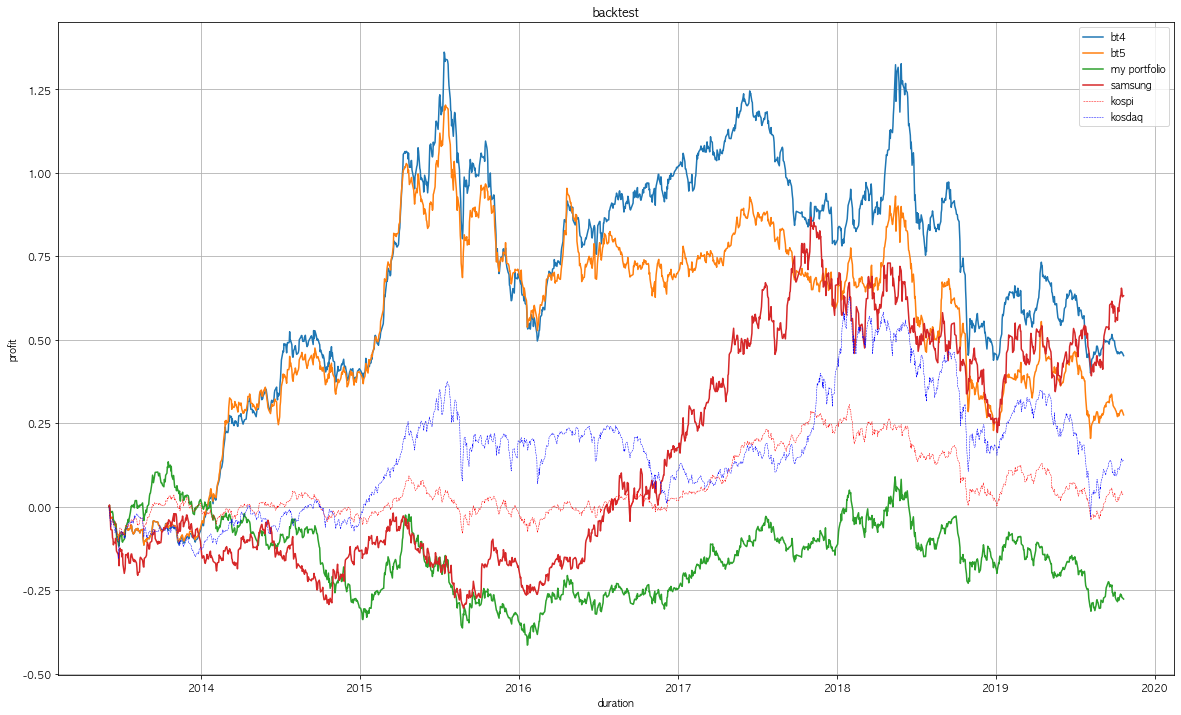

In [51]:
plt.rc('font', size=10)
plt.figure(figsize=(20, 12))
# plt.plot(bt1.index, bt1['total_change_rate'], label='bt1')
# plt.plot(bt2.index, bt2['total_change_rate'], label='bt2')
# plt.plot(bt3.index, bt3['total_change_rate'], label='bt3')
plt.plot(bt4.index, bt4['total_change_rate'], label='bt4')
plt.plot(bt5.index, bt5['total_change_rate'], label='bt5')
plt.plot(my.index, my['total_change_rate'], label='my portfolio')
plt.plot(samsung.index, samsung['total_change_rate'], label='samsung')
plt.plot(kospi_df.index, kospi_df['total_change_rate'], label='kospi', color='red',linewidth=0.5, linestyle='dashed')
plt.plot(kosdaq_df.index, kosdaq_df['total_change_rate'], label='kosdaq', color='blue',linewidth=0.5, linestyle='dashed')
plt.title('backtest')
plt.xlabel("duration")
plt.ylabel("profit")
plt.legend(loc='upper right')
plt.grid()
plt.show()